In [1]:
from pathlib import Path

project_root_path = Path.cwd().parent
project_root_path

WindowsPath('F:/projects_ssd/tfm/tfm-rl-starcraft2')

# Model paths

In [534]:
models_path = project_root_path / "models"
random_models_path = models_path / "random"
single_random_models_path = random_models_path / "single"
buffer_models_path = models_path / "create-buffers"
dqn_models_path = models_path / "dqn"
single_dqn_models_path = dqn_models_path / "single"
# models_path = project_root_path / "models_or"
models_path

WindowsPath('F:/projects_ssd/tfm/tfm-rl-starcraft2/models')

# Utils

In [405]:
import pandas as pd
import numpy as np

def assign_phase(row):
    if row["is_exploit"]:
        return "Exploit"
    if row["is_training"]:
        return "Training"
    return "Burn-in"


def get_agent_stats(model_id: str, model_path: str | Path):
    model_path = model_path / model_id
    agent_stats_path = model_path / "agent_stats.parquet"
    
    return pd.read_parquet(agent_stats_path)

def get_aggregated_stats(model_id: str, model_path: str | Path):
    model_path = model_path / model_id
    aggregated_stats_path = model_path / "aggregated_stats.parquet"

    return pd.read_parquet(aggregated_stats_path)

def get_episode_stats(model_id: str, model_path: str | Path):
    model_path = model_path / model_id
    episode_stats_path = model_path / "episode_stats.parquet"

    episode_stats = pd.read_parquet(episode_stats_path)
    episode_stats['episode'] = np.arange(len(episode_stats))

    episode_stats["loss"] = episode_stats["losses"].apply(lambda losses: np.mean(losses))
    episode_stats['mean_loss_10ep'] = episode_stats['loss'].rolling(10, min_periods=1).mean()
    episode_stats['mean_reward_10ep'] = episode_stats['reward'].rolling(10, min_periods=1).mean()
    episode_stats['mean_adjusted_reward_10ep'] = episode_stats['adjusted_reward'].rolling(10, min_periods=1).mean()
    episode_stats['mean_score_10ep'] = episode_stats['score'].rolling(10, min_periods=1).mean()
    episode_stats['mean_emissions_10ep'] = episode_stats['emissions'].rolling(10, min_periods=1).mean()
    episode_stats["accumulated_emissions"] = np.cumsum(episode_stats["emissions"])
    
    return episode_stats

In [548]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tfm_sc2.types import AgentStage
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(18, 9)})

def plot_line(episode_stats, model_name: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
        extra_args = dict(label=label)
    else:
        extra_args = dict(hue="initial_stage")
        
    ax = sns.lineplot(data=episode_stats, x="episode", y=metric_column, **extra_args)
    ax.set_title(f"{model_name} - {label} over time", fontsize=24)
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel(label, fontsize=24)
    ax.tick_params(labelsize=18)
    mean_col = f"mean_{metric_column}_10ep"
    if mean_col in list(episode_stats):
        sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}.png" if save_prefix is None else f"{save_prefix}_{metric_column}.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
    min_value = episode_stats[metric_column].min()
    plt.ylim(bottom=min(0, min_value * 1.1))
    plt.show()
    
def plot_hist(episode_stats, model_name: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
        extra_args = dict(label=label)
    else:
        extra_args = dict(hue="initial_stage")
        
    # ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
    ax = sns.histplot(data=episode_stats, x=metric_column)
    ax.set_title(f"{model_name} - Distribution of {label} per episode", fontsize=24)
    ax.set_xlabel(label,fontsize=24)
    ax.set_ylabel("Count",fontsize=24)
    ax.tick_params(labelsize=18)
    
    plt.axvline(episode_stats[metric_column].mean(), c="orange", label=f"Mean {metric_column}", linestyle="--") ;
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}_hist.png" if save_prefix is None else f"{save_prefix}_{metric_column}_hist.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)

    min_value = episode_stats[metric_column].min()
    max_value = episode_stats[metric_column].max()
    plt.xlim(left=min(0, min_value * 1.1), right=max(100, max_value * 1.1))
    plt.legend()
    plt.show()

# Steps
def plot_steps_hist(**kwargs):
    plot_hist(label="Steps", metric_column="steps", **kwargs)

# Rewards
def plot_rewards(**kwargs):
    plot_rewards_over_time(**kwargs)
    plot_rewards_hist(**kwargs)

def plot_rewards_over_time(**kwargs):
    plot_line(label="Reward", metric_column="reward", **kwargs)

def plot_rewards_hist(**kwargs):
    plot_hist(label="Reward", metric_column="reward", **kwargs)

# Adjusted rewards
def plot_adjusted_rewards(**kwargs):
    plot_adjusted_rewards_over_time(**kwargs)
    plot_adjusted_rewards_hist(**kwargs)

def plot_adjusted_rewards_over_time(**kwargs):
    plot_line(label="Adjusted Reward", metric_column="adjusted_reward", **kwargs)

def plot_adjusted_rewards_hist(**kwargs):
    plot_hist(label="Adjusted Reward", metric_column="adjusted_reward", **kwargs)

# Scores
def plot_scores(**kwargs):
    plot_scores_over_time(**kwargs)
    plot_scores_hist(**kwargs)

def plot_scores_over_time(**kwargs):
    plot_line(label="Score", metric_column="score", **kwargs)

def plot_scores_hist(**kwargs):
    plot_hist(label="Score", metric_column="score", **kwargs)

# Emissions
def plot_emissions(**kwargs):
    plot_emissions_over_time(**kwargs)
    plot_emissions_hist(**kwargs)

def plot_emissions_over_time(**kwargs):
    plot_line(label="Emissions", metric_column="emissions", **kwargs)

def plot_emissions_hist(**kwargs):
    plot_hist(label="Emissions", metric_column="emissions", **kwargs)

# Loss
def plot_losses(episode_stats, **kwargs):
    train_episodes = episode_stats[episode_stats["initial_stage"] == AgentStage.TRAINING.name]
    if len(train_episodes) == 0:
        print("No losses to plot (there are no training episodes")
        return
    plot_losses_over_time(episode_stats=train_episodes, **kwargs)
    plot_losses_hist(episode_stats=train_episodes, **kwargs)

def plot_losses_over_time(**kwargs):
    plot_line(label="Loss", metric_column="loss", **kwargs)

def plot_losses_hist(**kwargs):
    plot_hist(label="Loss", metric_column="loss", **kwargs)

def plot_epsilon(episode_stats, **kwargs):
    train_episodes = episode_stats[episode_stats["initial_stage"] == AgentStage.TRAINING.name]
    if len(train_episodes) == 0:
        print("No epsilon to plot (there are no training episodes")
        return
    plot_line(episode_stats=train_episodes, label="Epsilon", metric_column="epsilon", **kwargs)


In [376]:
# def plot_rewards(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Reward")
#     else:
#         extra_args = dict(hue="initial_stage")
        
#     ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
#     ax.set_title(f"{title_prefix} - Reward over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Reward",fontsize=24)
#     ax.tick_params(labelsize=18)
#     sns.lineplot(data=episode_stats, x="episode", y="mean_rewards_10ep", palette=["orange"], label="Mean Reward (10ep)")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "rewards.png" if model_id is None else f"{model_id}_rewards.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     min_value = episode_stats["reward"].min()
#     plt.ylim(bottom=min(0, min_value * 1.1))
#     plt.show()

# def plot_rewards_hist(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Reward")
#     else:
#         extra_args = dict(hue="initial_stage")
        
#     # ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
#     ax = sns.histplot(data=episode_stats, x="reward")
#     ax.set_title(f"{title_prefix} - Distribution of reward per episode", fontsize=24)
#     ax.set_xlabel("Reward",fontsize=24)
#     ax.set_ylabel("Count",fontsize=24)
#     ax.tick_params(labelsize=18)
    
#     plt.axvline(episode_stats["reward"].mean(), c="orange", label="Mean reward", linestyle="--") ;
    
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "rewards_hist.png" if model_id is None else f"{model_id}_rewards_hist.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)

#     min_value = episode_stats["reward"].min()
#     max_value = episode_stats["reward"].max()
#     plt.xlim(left=min(0, min_value * 1.1), right=max(100, max_value * 1.1))
#     plt.show()


# def plot_adjusted_rewards(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Adjusted Reward")
#     else:
#         extra_args = dict(hue="initial_stage")
#     ax = sns.lineplot(data=episode_stats, x="episode", y="adjusted_reward", **extra_args)
#     ax.set_title(f"{title_prefix} - Adjusted Reward over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Adjusted Reward",fontsize=24)
#     ax.tick_params(labelsize=18)
#     sns.lineplot(data=episode_stats, x="episode", y="mean_adjusted_rewards_10ep", palette=["orange"], label="Mean Adjusted Reward (10ep)")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "adjusted_rewards.png" if model_id is None else f"{model_id}_adjusted_rewards.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     min_value = episode_stats["adjusted_reward"].min()
#     plt.ylim(bottom=min(0, min_value * 1.1))
#     plt.show()

# def plot_adjusted_rewards_hist(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Adjusted Reward")
#     else:
#         extra_args = dict(hue="initial_stage")
        
#     # ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
#     ax = sns.histplot(data=episode_stats, x="adjusted_reward")
#     ax.set_title(f"{title_prefix} - Distribution of adjusted reward per episode", fontsize=24)
#     ax.set_xlabel("Adjusted Reward",fontsize=24)
#     ax.set_ylabel("Count",fontsize=24)
#     ax.tick_params(labelsize=18)
    
#     plt.axvline(episode_stats["reward"].mean(), c="orange", label="Mean reward", linestyle="--") ;
    
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "adjusted_rewards_hist.png" if model_id is None else f"{model_id}_adjusted_rewards_hist.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)

#     min_value = episode_stats["adjusted_reward"].min()
#     max_value = episode_stats["adjusted_reward"].max()
#     plt.xlim(left=min(0, min_value * 1.1), right=max(100, max_value * 1.1))
#     plt.show()

# def plot_scores(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Score")
#     else:
#         extra_args = dict(hue="initial_stage")
#     ax =sns.lineplot(data=episode_stats, x="episode", y="score", **extra_args)
#     ax.set_title(f"{title_prefix} - Score over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Score",fontsize=24)
#     ax.tick_params(labelsize=18)
#     sns.lineplot(data=episode_stats, x="episode", y="mean_scores_10ep", palette=["orange"], label="Mean Score (10ep)")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "scores.png" if model_id is None else f"{model_id}_scores.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     min_value = episode_stats["score"].min()
#     plt.ylim(bottom=min(0, min_value * 1.1))
#     plt.show()

# def plot_emissions(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(label="Reward")
#     else:
#         extra_args = dict(hue="initial_stage")
#     ax = sns.lineplot(data=episode_stats, x="episode", y="emissions", **extra_args)
#     ax.set_title(f"{title_prefix} - Accumulated Emissions over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Emissions",fontsize=24)
#     ax.tick_params(labelsize=18)
#     # sns.lineplot(data=episode_stats, x="episode", y="mean_emissions_10ep", palette=["orange"], label="Mean Emissions (10ep)")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "emissions.png" if model_id is None else f"{model_id}_emissions.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     min_value = episode_stats["emissions"].min()
#     plt.ylim(bottom=min(0, min_value * 1.1))
#     plt.show()

# def plot_accumulated_emissions(episode_stats, title_prefix: str, use_stages: bool = True, save_path: Path = None, model_id: str = None):
#     if use_stages or len(episode_stats["initial_stage"].unique()) < 2:
#         extra_args = dict(hue="initial_stage")
#     else:
#         extra_args = dict(label="Reward")
#     sns.lineplot(data=episode_stats, x="episode", y="accumulated_emissions", label="Accumulated emissions").set_title(f"{title_prefix} - Accumulated emisisons")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "accumulated_emissions.png" if model_id is None else f"{model_id}_accumulated_emissions.png"
#         plt.savefig(save_path / filename)
#     plt.show()

# def plot_losses(episode_stats, title_prefix: str, save_path: Path = None, model_id: str = None):
#     train_episodes = episode_stats[episode_stats["initial_stage"] == AgentStage.TRAINING.name]
#     if len(train_episodes) == 0:
#         print("No losses to plot (there are no training episodes")
#         return
#     ax = sns.lineplot(data=train_episodes, x="episode", y="loss", label="Loss")
#     ax.set_title(f"{title_prefix} - Loss over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Loss",fontsize=24)
#     ax.tick_params(labelsize=18)
#     sns.lineplot(data=train_episodes, x="episode", y="mean_loss_10ep", palette=["orange"], label="Mean Loss (10ep)")
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "train_losses.png" if model_id is None else f"{model_id}_train_losses.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     min_value = episode_stats["loss"].min()
#     plt.ylim(bottom=min(0, min_value * 1.1))
#     plt.show()

# def plot_epsilon(episode_stats, title_prefix: str, save_path: Path = None, model_id: str = None):
#     train_episodes = episode_stats[episode_stats["initial_stage"] == AgentStage.TRAINING.name]
#     if len(train_episodes) == 0:
#         print("No epsilons to plot (there are no training episodes")
#         return
#     ax = sns.lineplot(data=episode_stats, x="episode", y="epsilon", label="Epsilon")
#     ax.set_title(f"{title_prefix} - Epsilon over time", fontsize=24)
#     ax.set_xlabel("Episode",fontsize=24)
#     ax.set_ylabel("Epsilon",fontsize=24)
#     ax.tick_params(labelsize=18)
#     if save_path is not None:
#         save_path.mkdir(exist_ok=True, parents=True)
#         filename = "train_epsilons.png" if model_id is None else f"{model_id}_train_epsilons.png"
#         plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
#     plt.ylim(bottom=0)
#     plt.show()

In [550]:
def plot_stats(episode_stats, model_name, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    plot_rewards(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_rewards_hist(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_adjusted_rewards(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_scores(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_emissions(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_losses(episode_stats=episode_stats, model_name=model_name, save_path=save_path, save_prefix=save_prefix) ;
    plot_epsilon(episode_stats=episode_stats, model_name=model_name, save_path=save_path, save_prefix=save_prefix) ;

In [552]:
def load_stats(model_id: str, model_name: str, model_path: str | Path, show_plots: bool = True, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    save_prefix = save_prefix or model_id
    agent_stats = get_agent_stats(model_id, model_path)
    aggregated_stats = get_aggregated_stats(model_id, model_path)
    episode_stats = get_episode_stats(model_id, model_path)
    total_episodes = len(episode_stats)
    total_training_episodes = len(episode_stats[episode_stats["initial_stage"] == "TRAINING"])
    total_exploit_episodes = len(episode_stats[episode_stats["initial_stage"] == "EXPLOIT"])
    total_burnin_episodes = len(episode_stats[episode_stats["initial_stage"] == "BURN_IN"])
    total_random_mode_episodes = len(episode_stats[episode_stats["is_random_mode"] == True])
    print(f"Total episodes: {total_episodes}")
    print(f"Total burnin episodes: {total_burnin_episodes}")
    print(f"Total random mode episodes: {total_random_mode_episodes}")
    print(f"Total episodes: {total_training_episodes}")
    print(f"Total exploit episodes: {total_exploit_episodes}")
    print("Unique maps in episode stats: ", episode_stats["map_name"].unique())

    if show_plots:
        plot_stats(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix)
    
    return episode_stats, agent_stats, aggregated_stats
    

In [408]:
base_model_id = "single_drl"
collect_minerals_model_id = f"{base_model_id}_collect_minerals"
build_marines_model_id = f"{base_model_id}_build_marines"
defeat_roaches_model_id = f"{base_model_id}_defeat_roaches"
defeat_zerglings_model_id = f"{base_model_id}_defeat_zerglings_and_banelings"
simple64_model_id = f"{base_model_id}_simple64"

# Single agent(s)

## Random

### Collect minerals - standalone

In [170]:
images_path = Path.cwd() / "images"
images_path.mkdir(exist_ok=True, parents=True)

In [529]:
collect_minerals_model_id ="collect_minerals"
save_images_path = images_path / "create_buffers"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "Random Agent - CollectMinerals Standalone"
save_prefix = f"random_standalone_{collect_minerals_model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(collect_minerals_model_id, model_path=buffer_models_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 100
Total burnin episodes: 0
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 100
Unique maps in episode stats:  ['CollectMineralsAndGas']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  \
0  CollectMineralsAndGas  3950.0          3248.24    211      1.0     []   
1  CollectMineralsAndGas  3725.0          2905.37    211      1.0     []   
2  CollectMineralsAndGas  3130.0          2666.21    211      1.0     []   
3  CollectMineralsAndGas  3950.0          3107.30    211      1.0     []   
4  CollectMineralsAndGas  4015.0          3226.26    211      1.0     []   

   emissions   score  is_burnin  is_training  ...  episode  loss  \
0   0.000469  3250.0      False         True  ...        0   NaN   
1   0.000955  2907.0      False         True  ...        1   NaN   
2   0.001384  2718.0      False         True  ...        2   NaN   
3   0.001817  3109.0      False         True  ...        3   NaN   
4   0.002310  3228.0      False         True  ...        4   NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   

   mean_reward_10ep mean_adjusted_reward_10ep mean_score_10ep  \
0       3950.000000                  3248.240     3250.000000   
1       3837.500000                  3076.805     3078.500000   
2       3601.666667                  2939.940     2958.333333   
3       3688.750000                  2981.780     2996.000000   
4       3754.000000                  3030.676     3042.400000   

   mean_emissions_10ep  accumulated_emissions  
0             0.000469               0.000469  
1             0.000712               0.001423  
2             0.000936               0.002807  
3             0.001156               0.004624  
4             0.001387               0.006934  

[5 rows x 24 columns]

Min/AVG/Max steps per episode:  211 211.0 211


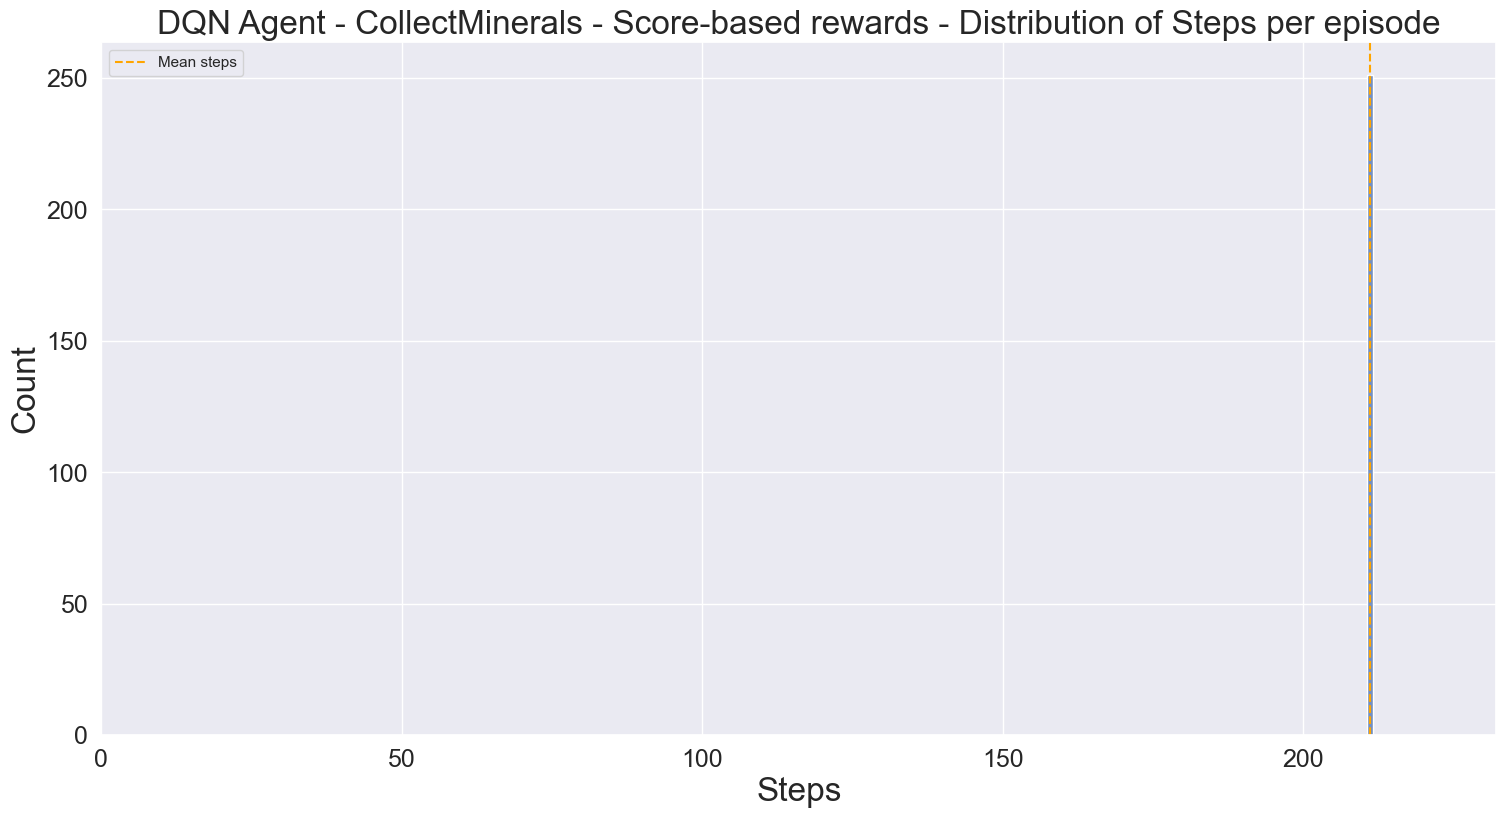

In [593]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args)

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


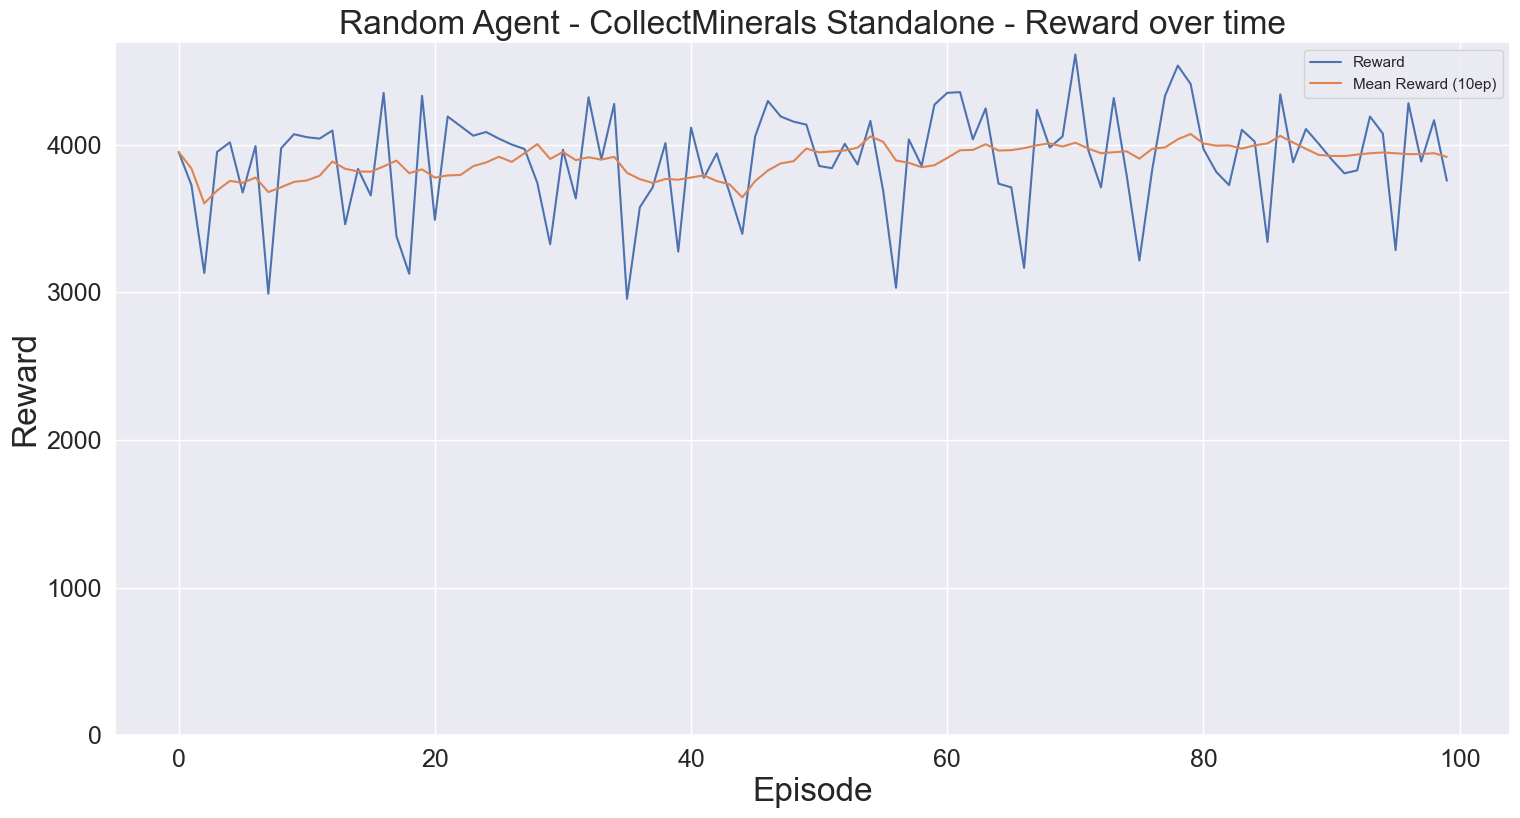

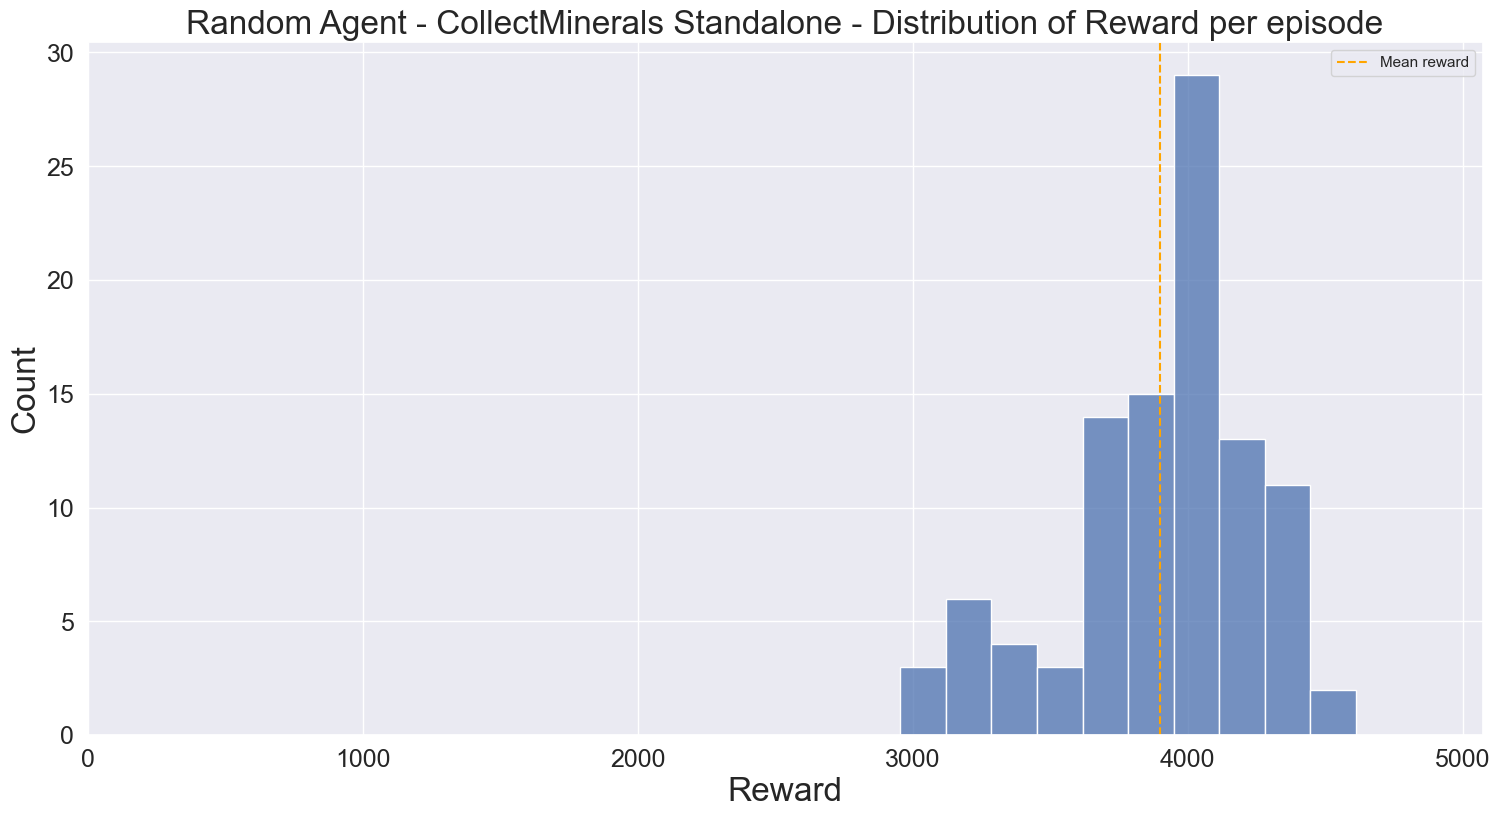

In [486]:
plot_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


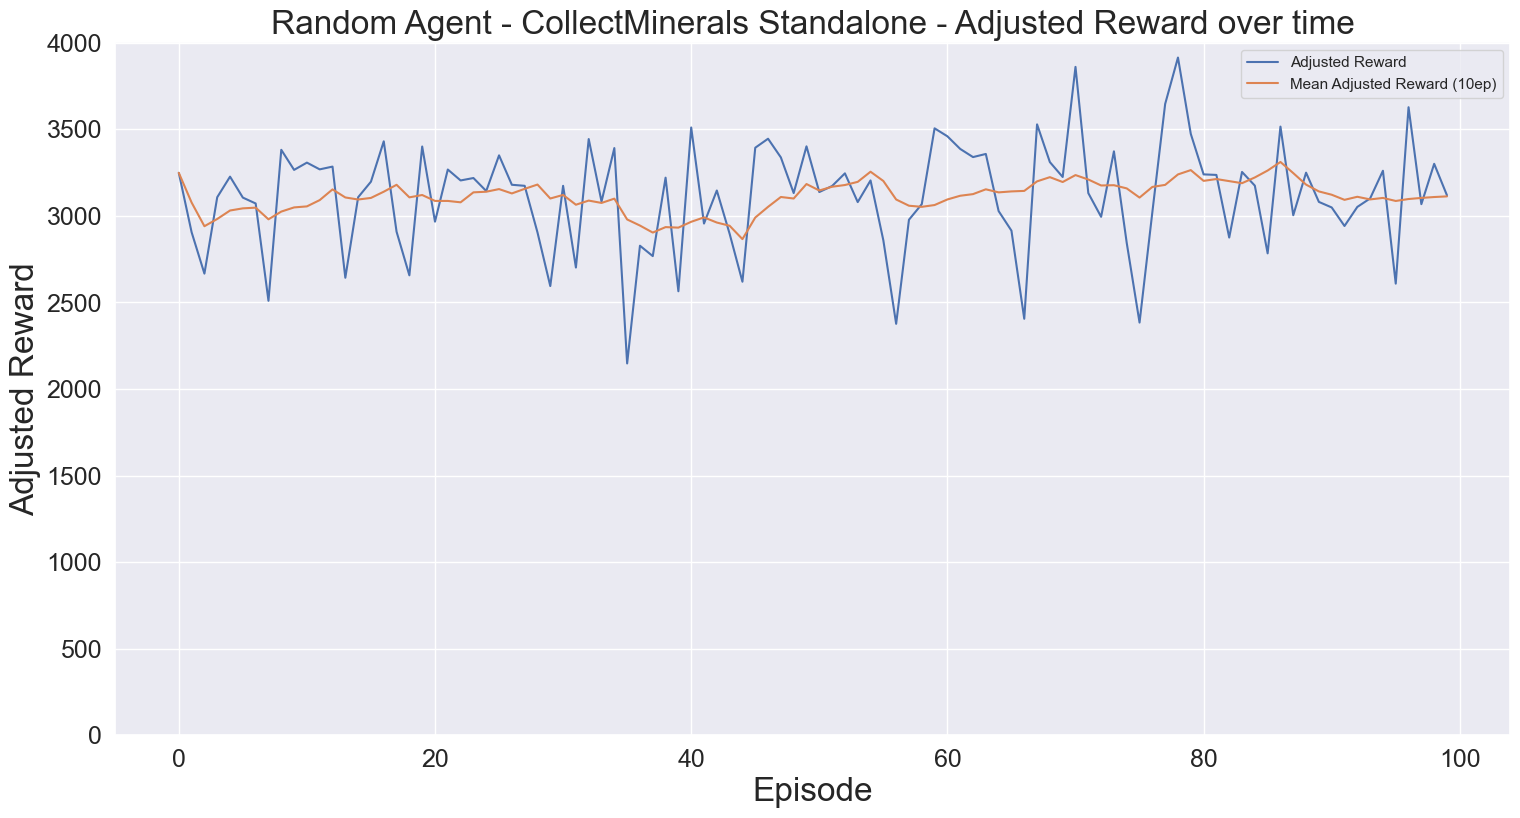

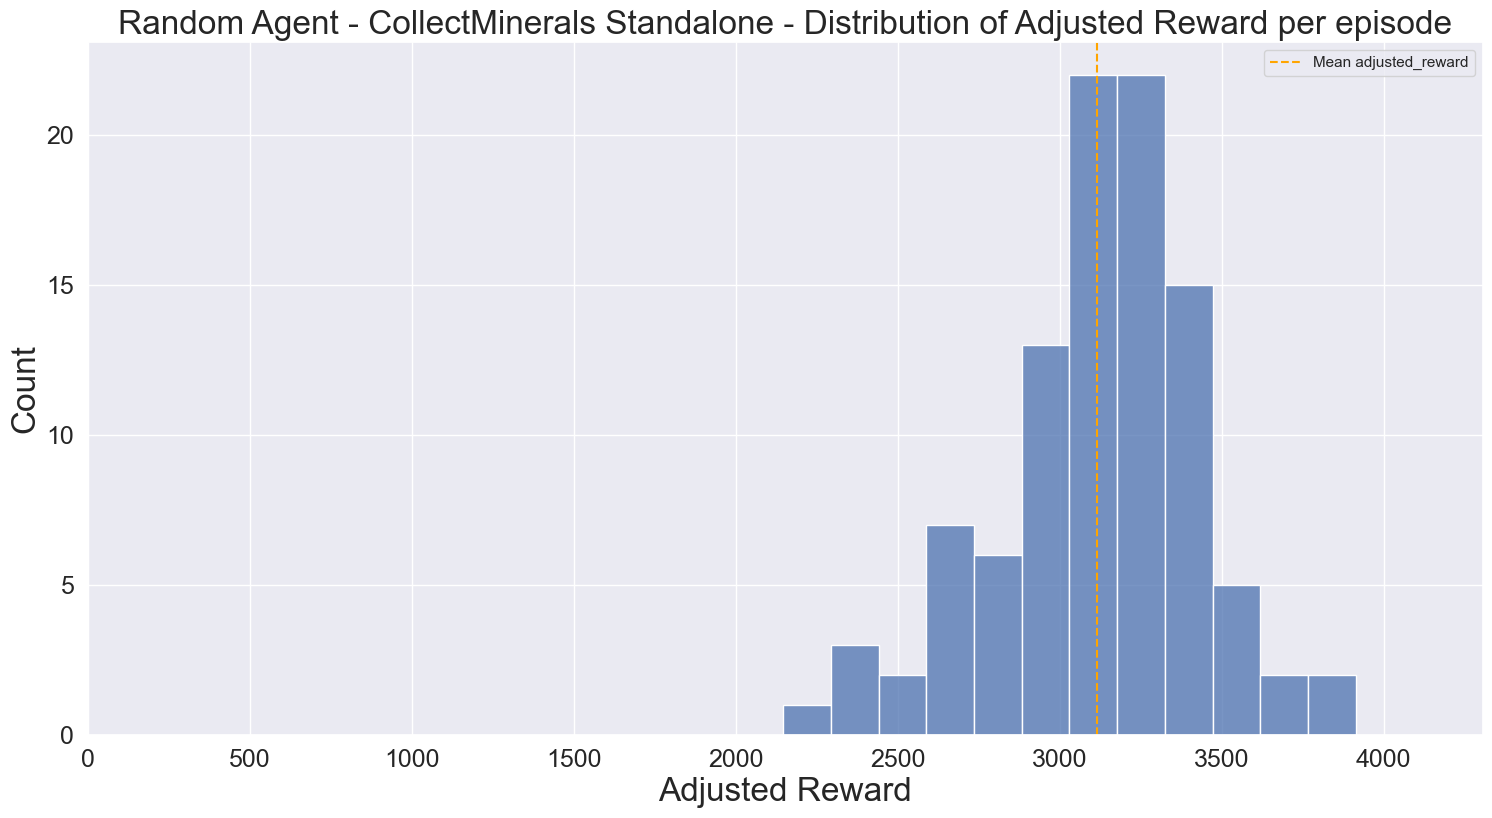

In [487]:
plot_adjusted_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


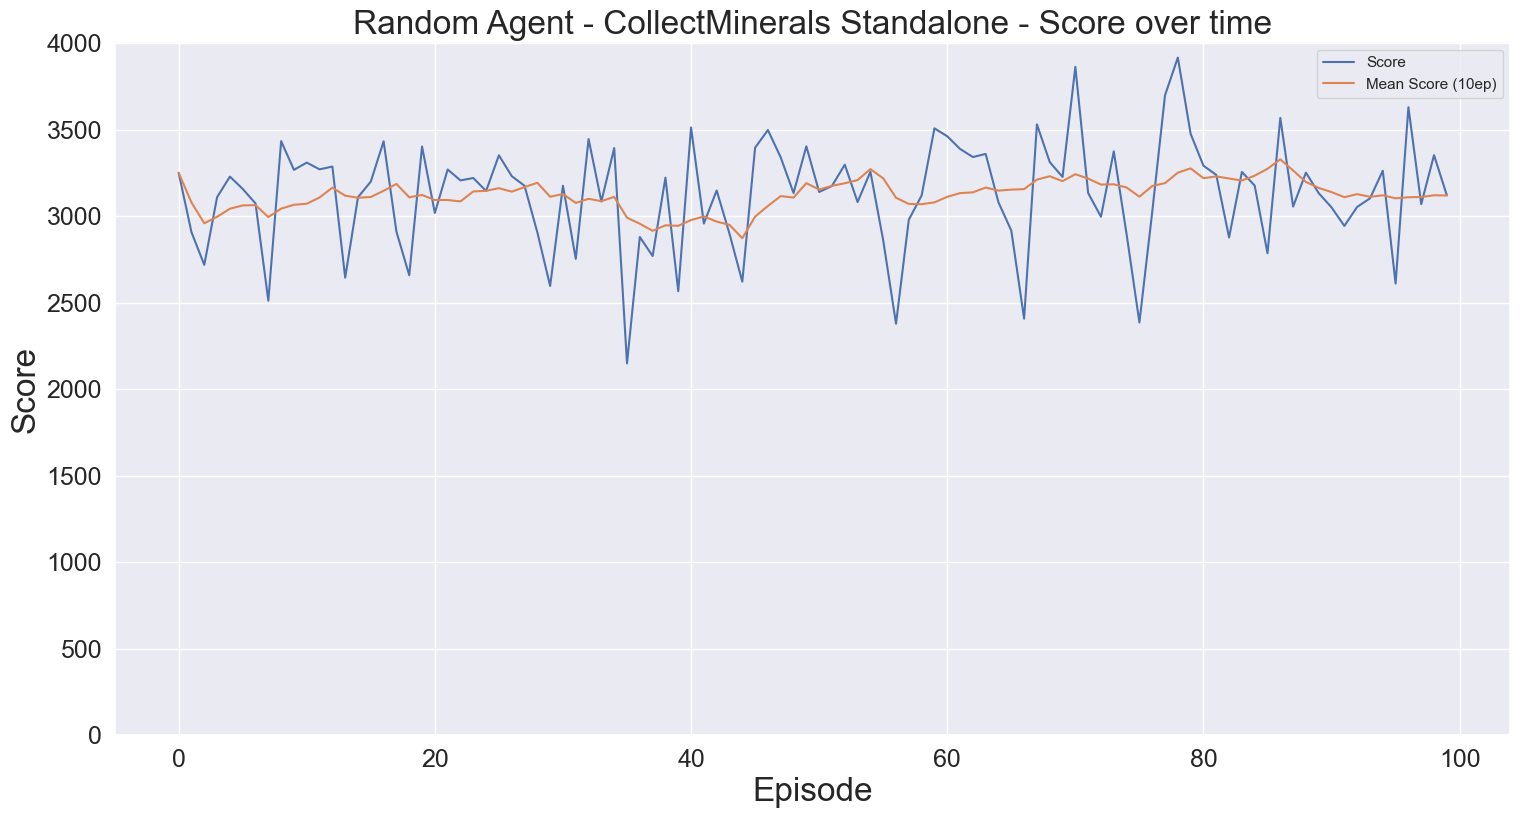

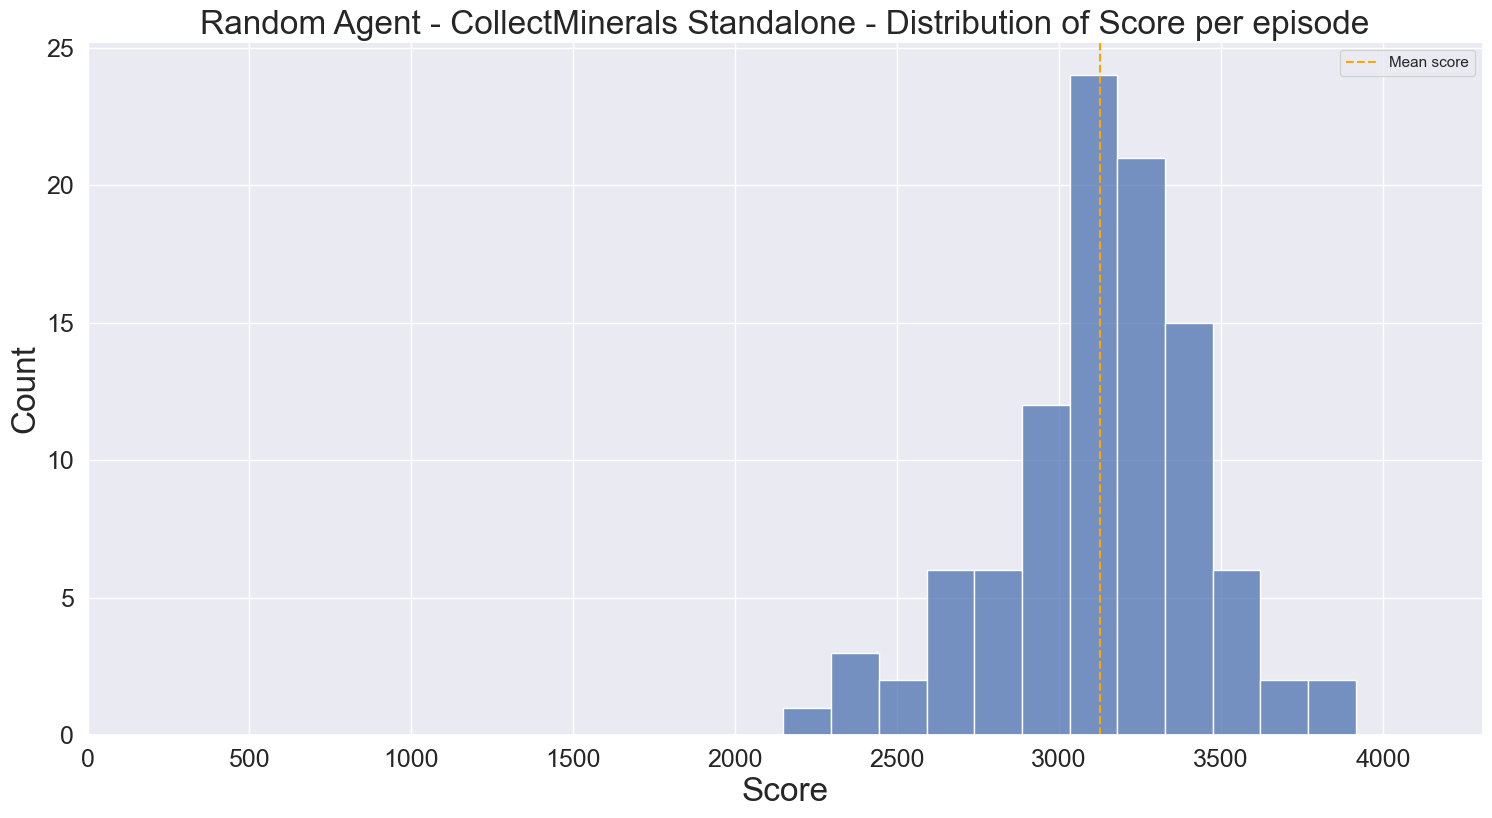

In [488]:
plot_scores(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


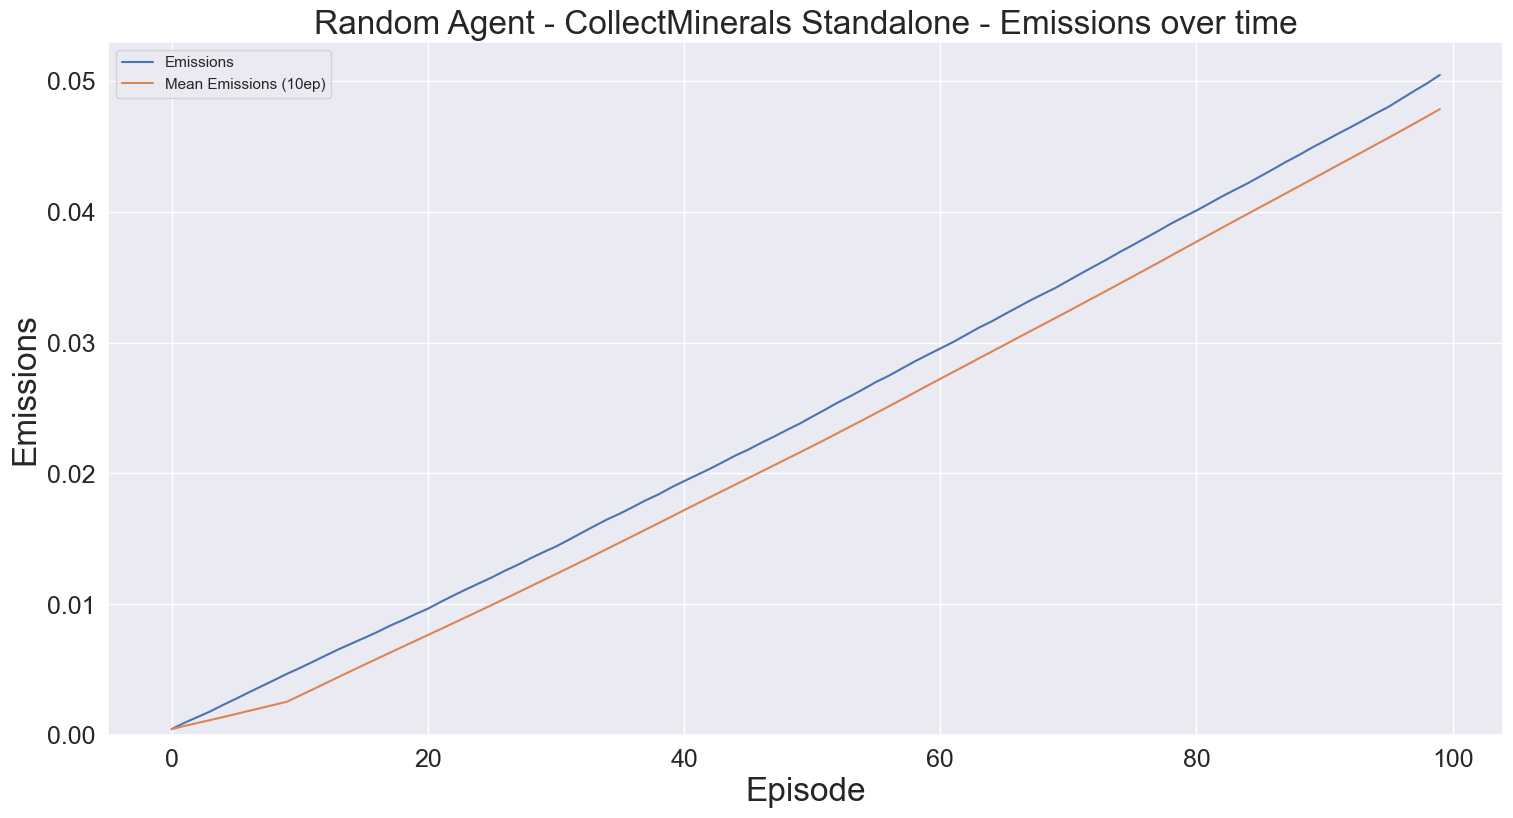

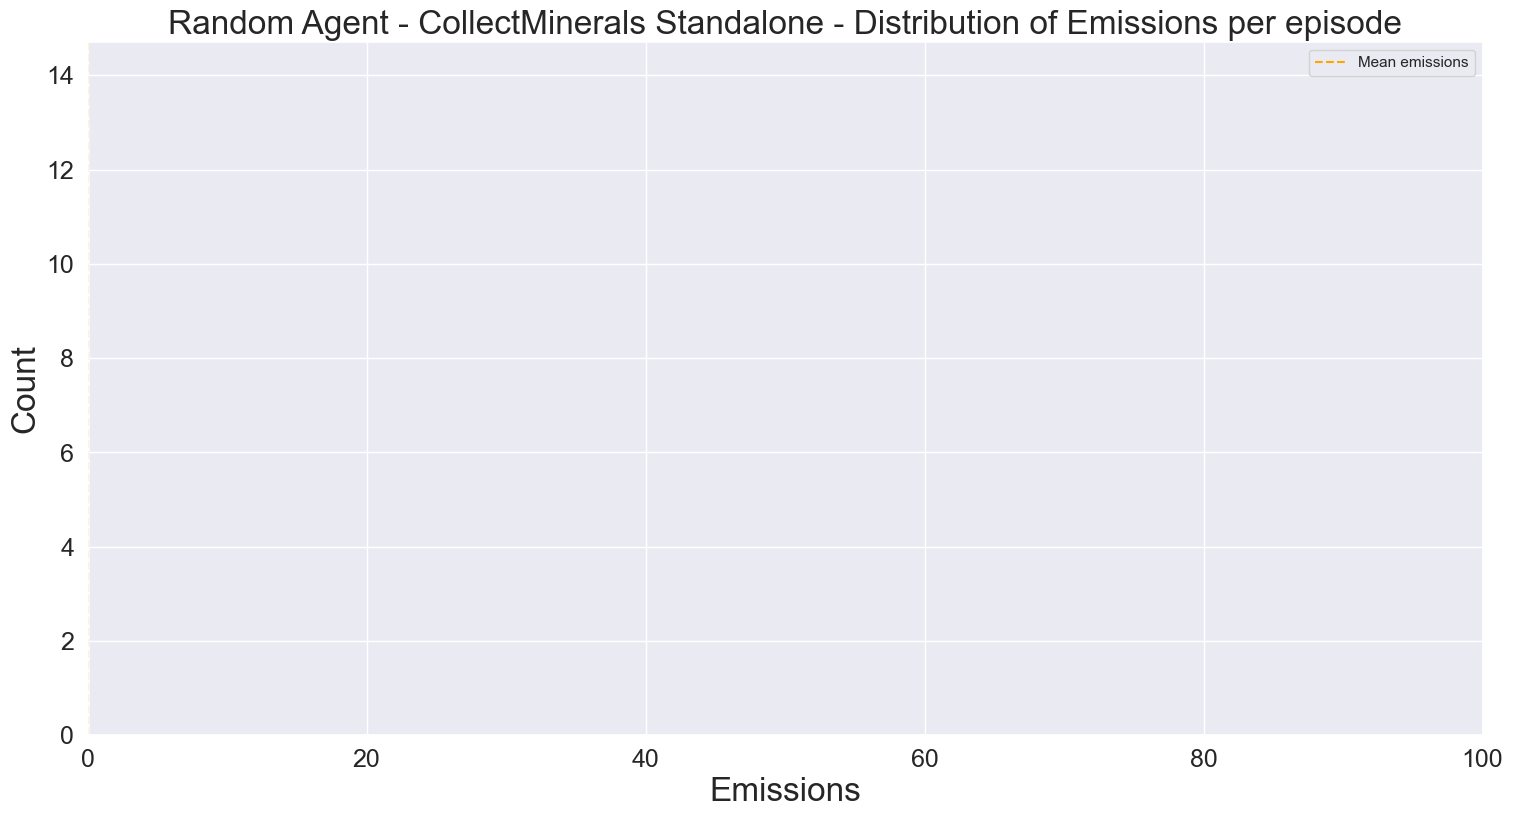

In [489]:
plot_emissions(**plot_args) ;

In [490]:
plot_losses(**plot_args) ;
plot_epsilon(**plot_args) ;

No losses to plot (there are no training episodes
No epsilon to plot (there are no training episodes


In [450]:
# from tfm_sc2.actions import AllActions
# def extract_action_counts(episode_stats):
#     values = []
#     actions = [action for action in list(AllActions) if action != AllActions.NO_OP]
#     agg_values = {
#         "valid": {action.name: 0 for action in actions},
#         "invalid": {action.name: 0 for action in actions}
#     }
            
    
#     for row_with_index in episode_stats.iterrows():
#         row = row_with_index[1]
#         invalid_action_counts = row.invalid_action_counts
#         valid_action_counts = row.valid_action_counts
#         for action in actions:
#             values.extend([
#                 dict(episode=row.episode, action=action.name, count_type="valid", value=valid_action_counts[action.name]),
#                 dict(episode=row.episode, action=action.name, count_type="invalid", value=invalid_action_counts[action.name])
#             ])
#             agg_values["valid"][action.name] += valid_action_counts[action.name]
#             agg_values["invalid"][action.name] += invalid_action_counts[action.name]

#     all_values = pd.DataFrame(values)
#     final_agg_values = []
#     for action in actions:
#         final_agg_values.extend([
#             dict(action=action.name, count_type="valid", value=agg_values["valid"][action.name]),
#             dict(action=action.name, count_type="invalid", value=agg_values["invalid"][action.name]),
#         ])

#     return all_values, pd.DataFrame(final_agg_values)

In [451]:
# all_values, agg_values = extract_action_counts(episode_stats)
# agg_values

In [452]:
# sns.barplot(agg_values, x="action", y="value", hue="count_type")

In [491]:
# episode_stats2 = extract_action_counts(episode_stats2, "valid")
# episode_stats2 = extract_action_counts(episode_stats2, "invalid")
# episode_stats2.head()

### Build marines

In [594]:
build_marines_model_id ="build_marines"
save_images_path = images_path / "create_buffers"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "Random Agent - BuildMarines Standalone"
save_prefix = f"random_standalone_{build_marines_model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(build_marines_model_id, model_path=buffer_models_path, show_plots=False, **common_args)
episode_stats.head()

Total episodes: 50
Total burnin episodes: 0
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 50
Unique maps in episode stats:  ['BuildMarines']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
0  BuildMarines    50.0           -28.87    451      1.0     []   0.001092   
1  BuildMarines    48.0           -37.78    451      1.0     []   0.003423   
2  BuildMarines    49.0           -40.74    451      1.0     []   0.005388   
3  BuildMarines    48.0           -43.73    451      1.0     []   0.007286   
4  BuildMarines    48.0           -37.72    451      1.0     []   0.009236   

   score  is_burnin  is_training  ...  episode  loss  \
0  -25.0      False         True  ...        0   NaN   
1  -34.0      False         True  ...        1   NaN   
2  -37.0      False         True  ...        2   NaN   
3  -40.0      False         True  ...        3   NaN   
4  -34.0      False         True  ...        4   NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...             NaN   

   mean_reward_10ep mean_adjusted_reward_10ep mean_score_10ep  \
0             50.00                -28.870000           -25.0   
1             49.00                -33.325000           -29.5   
2             49.00                -35.796667           -32.0   
3             48.75                -37.780000           -34.0   
4             48.60                -37.768000           -34.0   

   mean_emissions_10ep  accumulated_emissions  
0             0.001092               0.001092  
1             0.002257               0.004515  
2             0.003301               0.009903  
3             0.004297               0.017189  
4             0.005285               0.026425  

[5 rows x 24 columns]

In [595]:
plot_args = dict(episode_stats=episode_stats, **common_args)

Min/AVG/Max steps per episode:  451 451.0 451


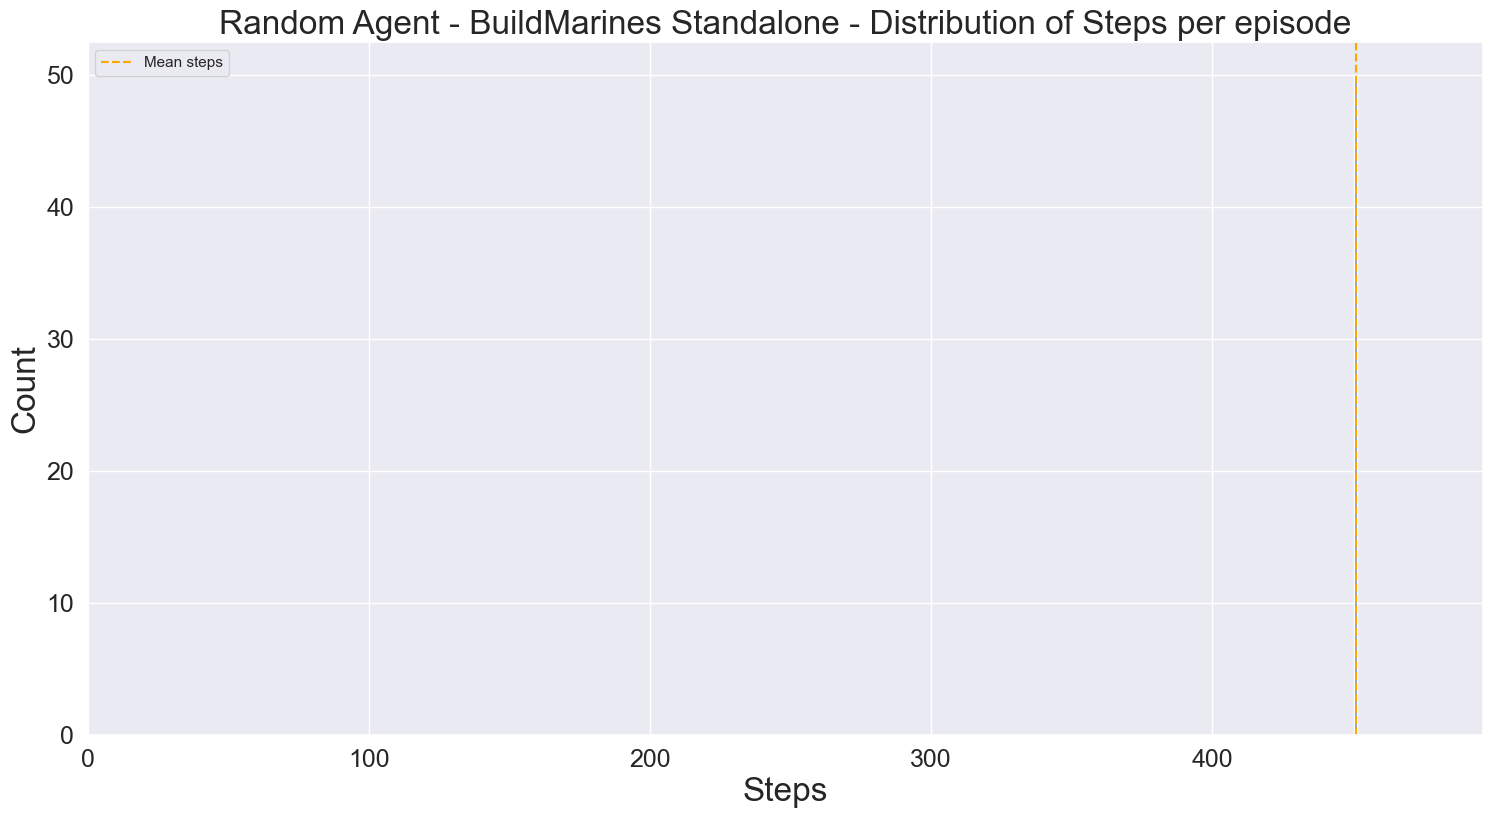

In [596]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args)

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


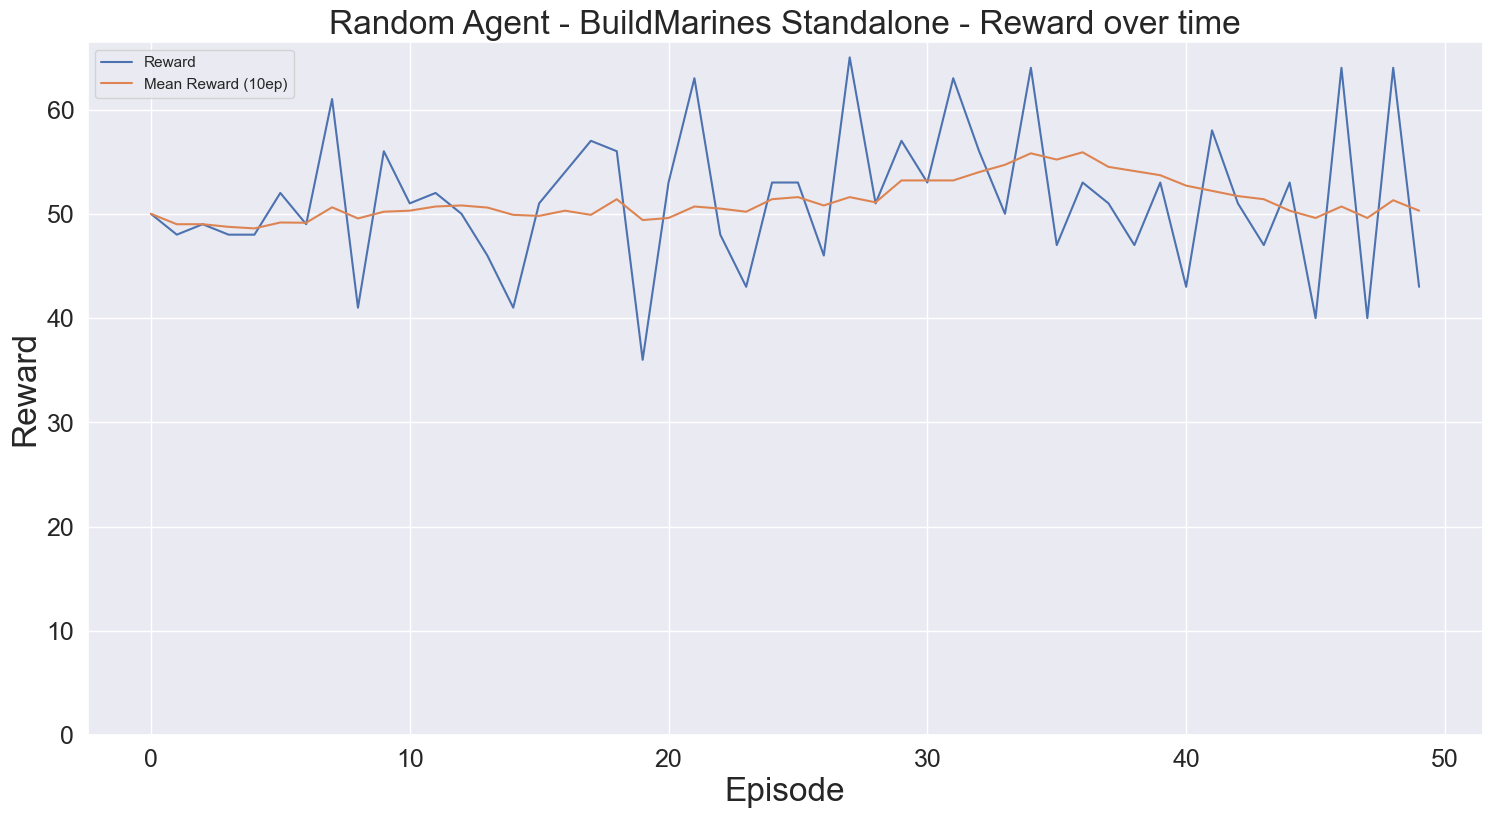

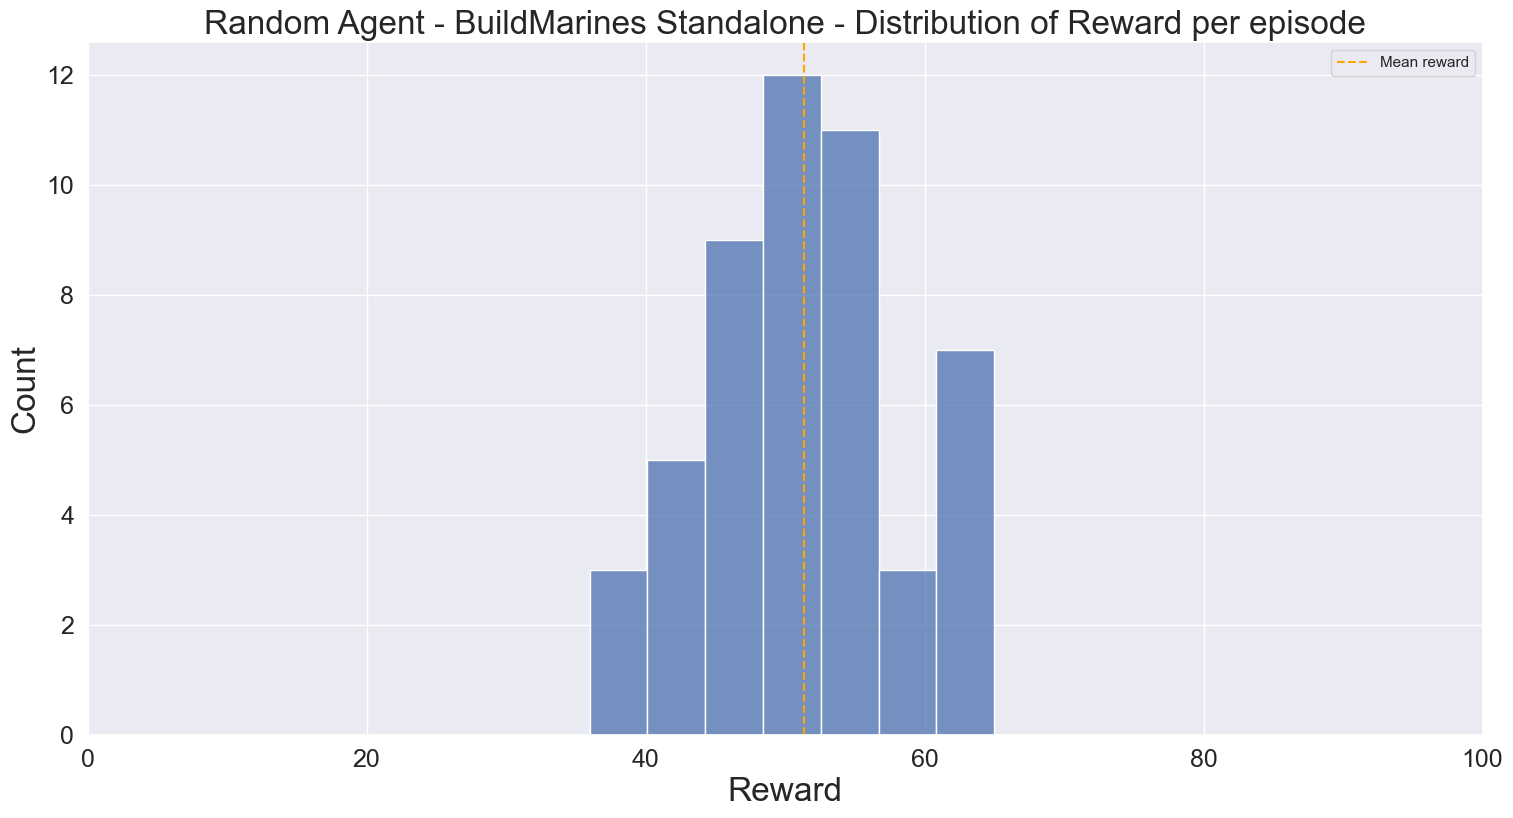

In [504]:
plot_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


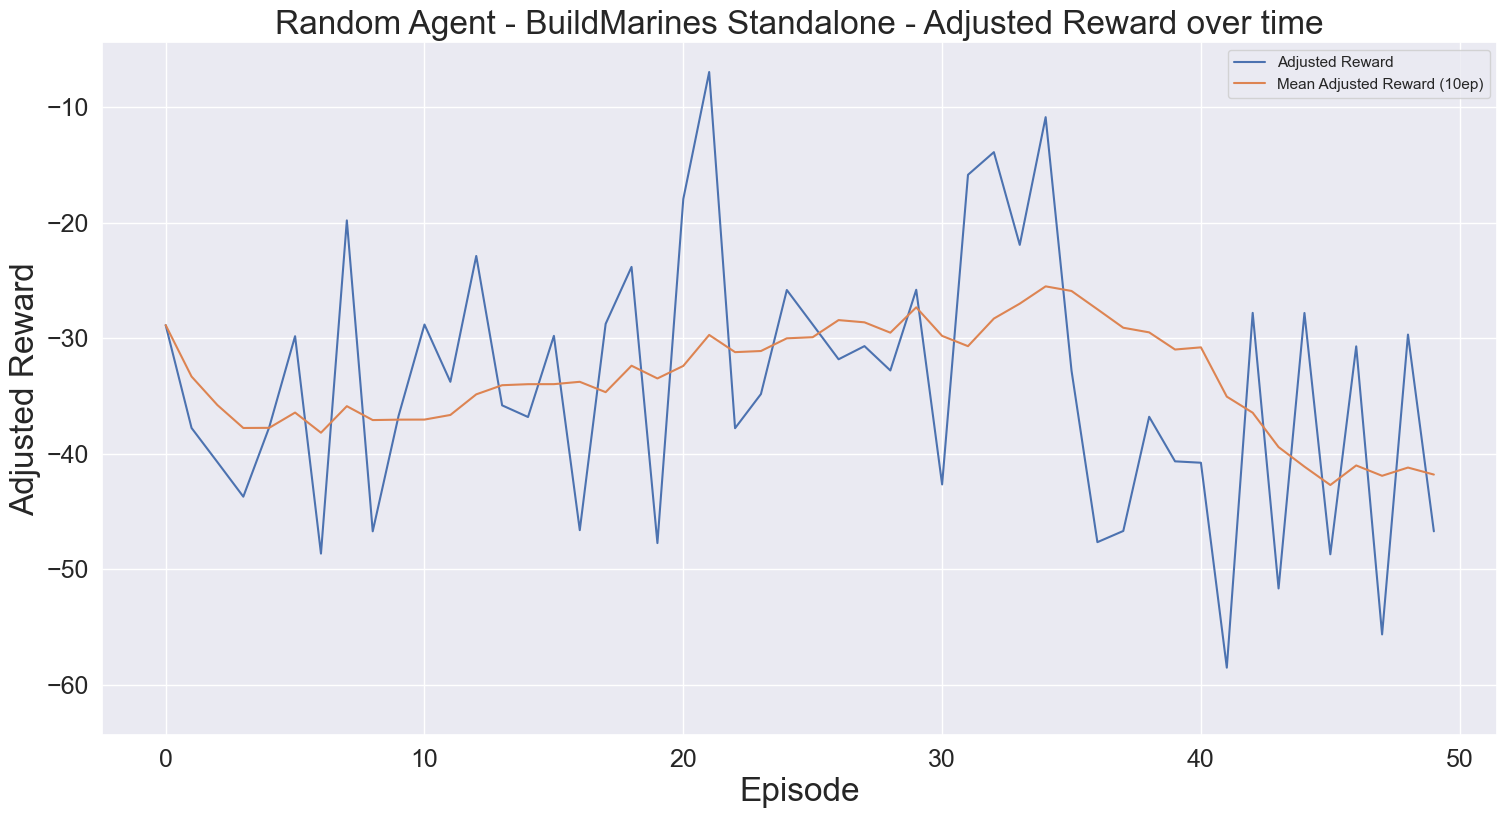

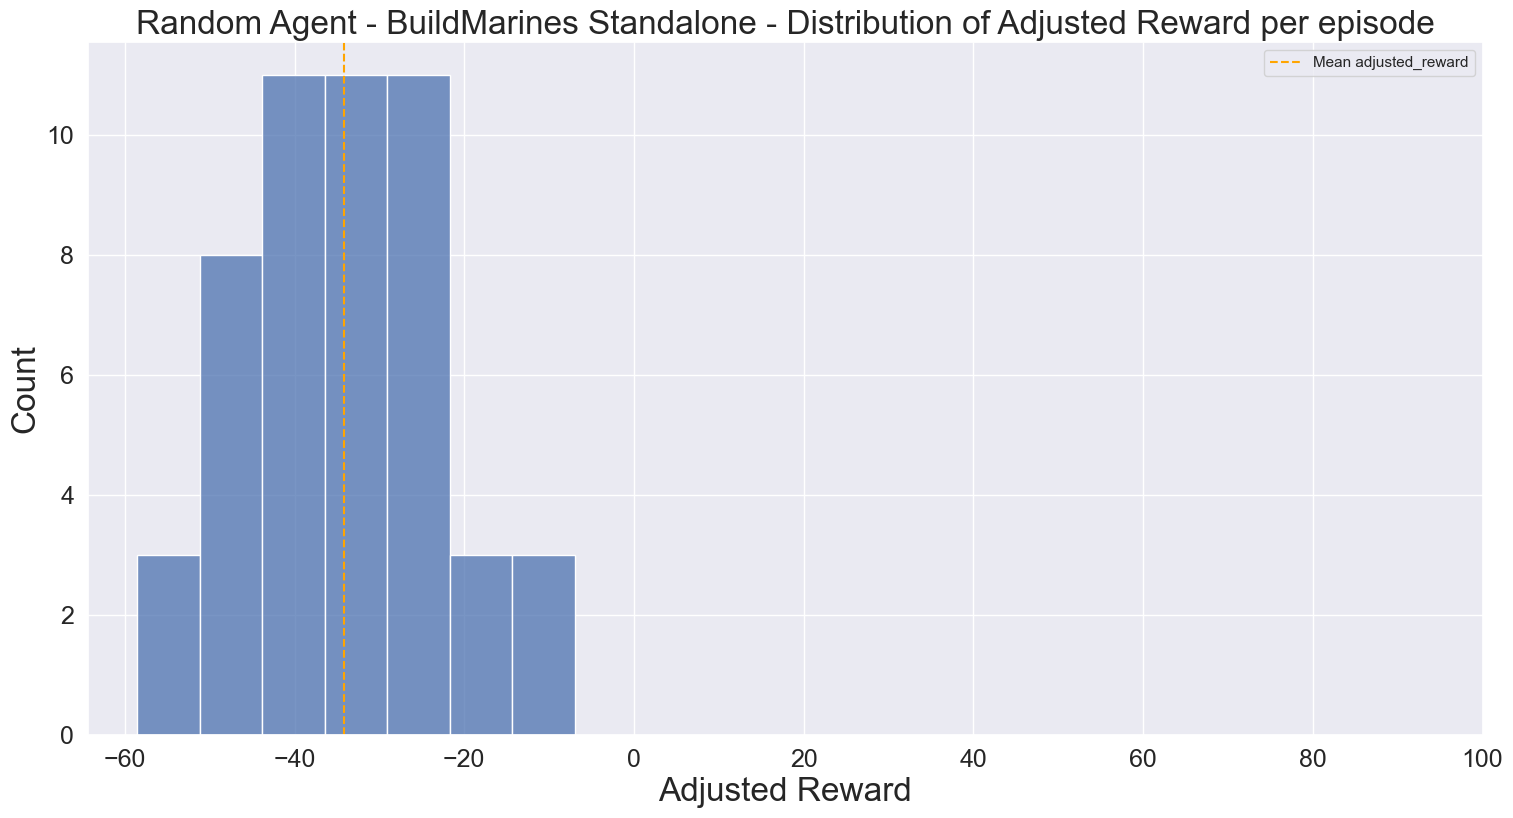

In [505]:
plot_adjusted_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


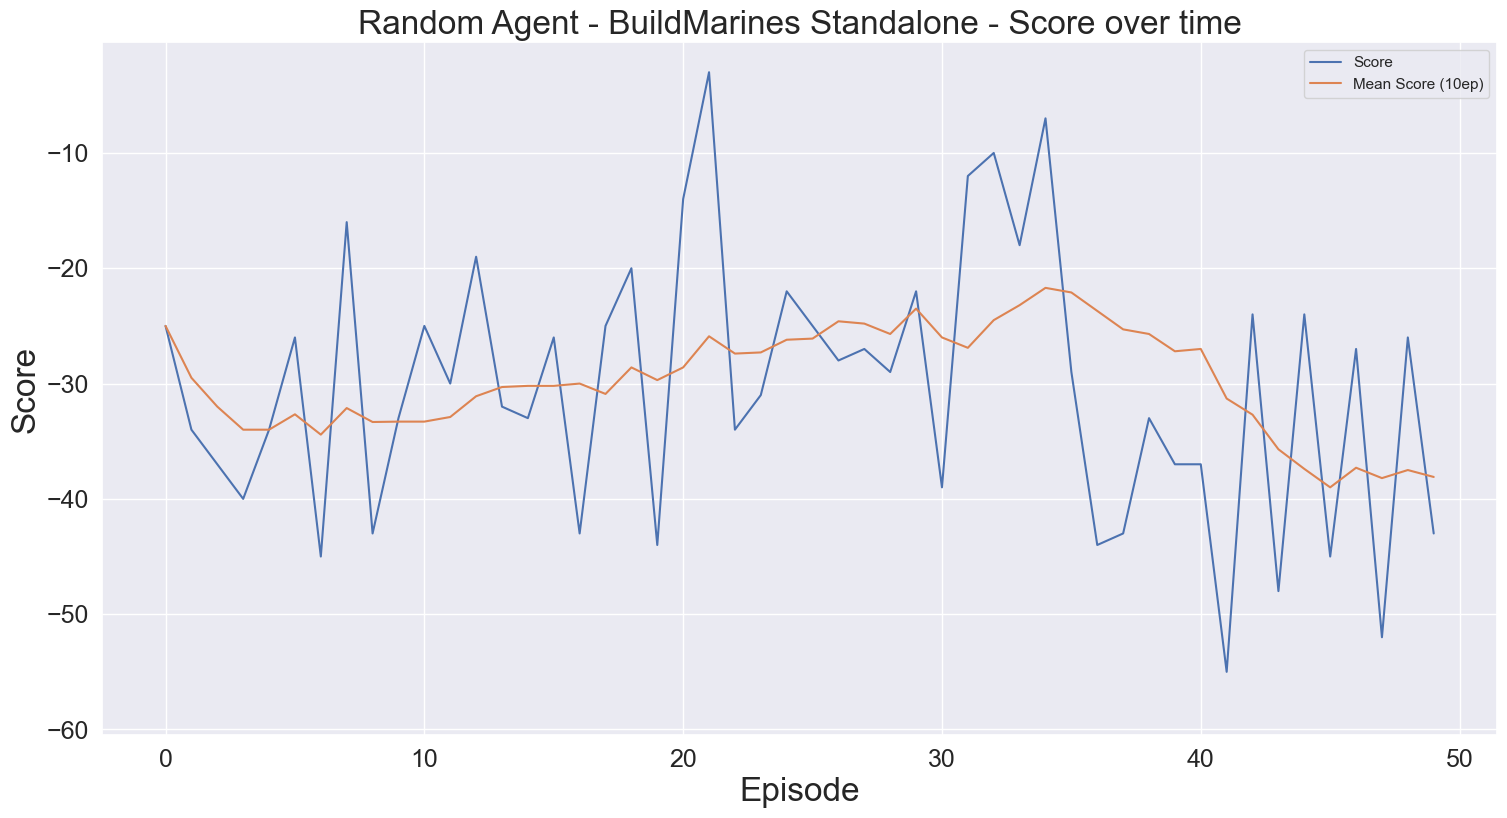

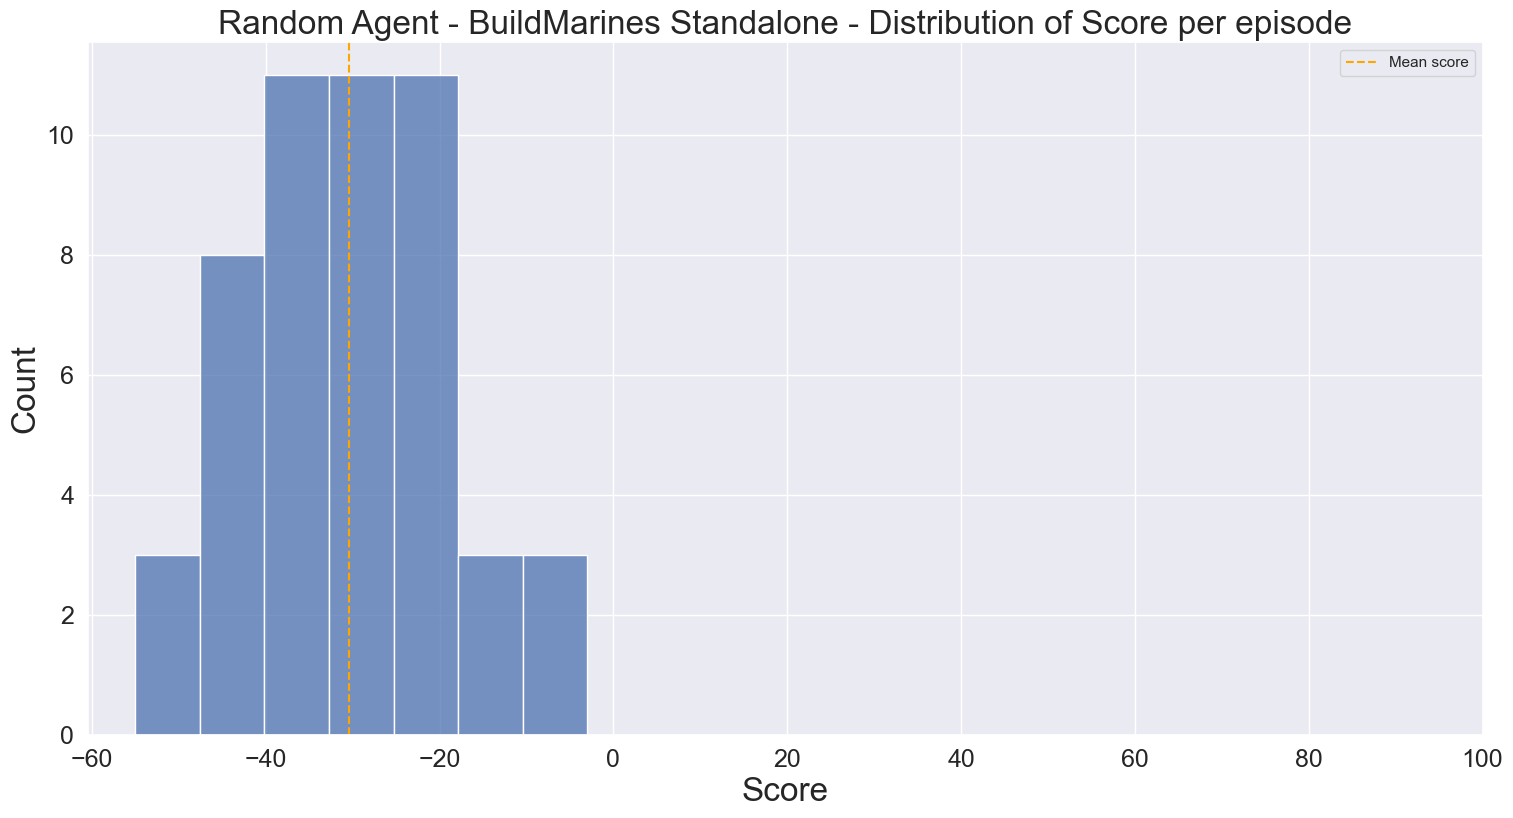

In [506]:
plot_scores(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


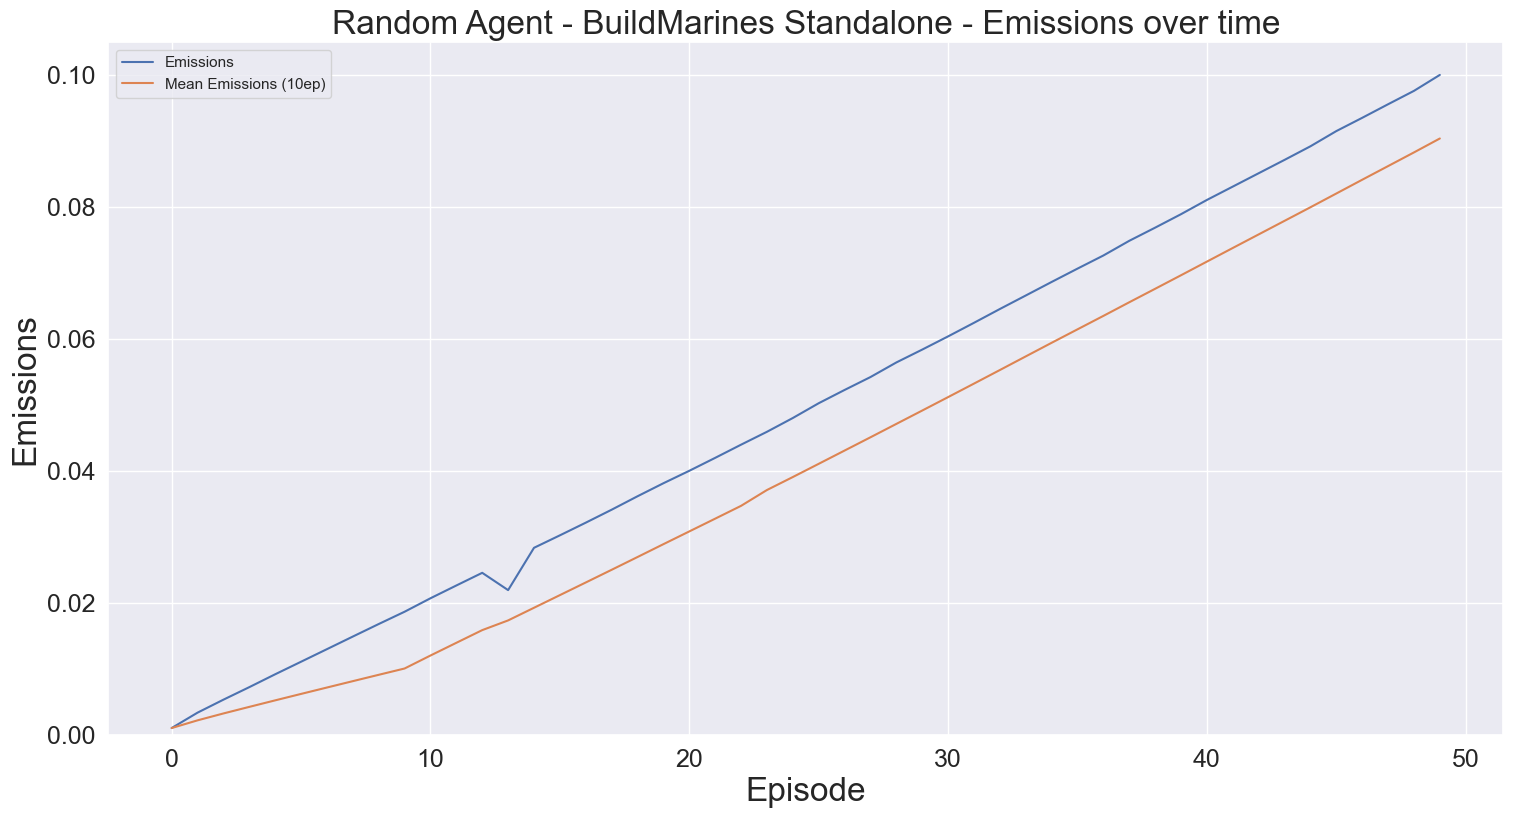

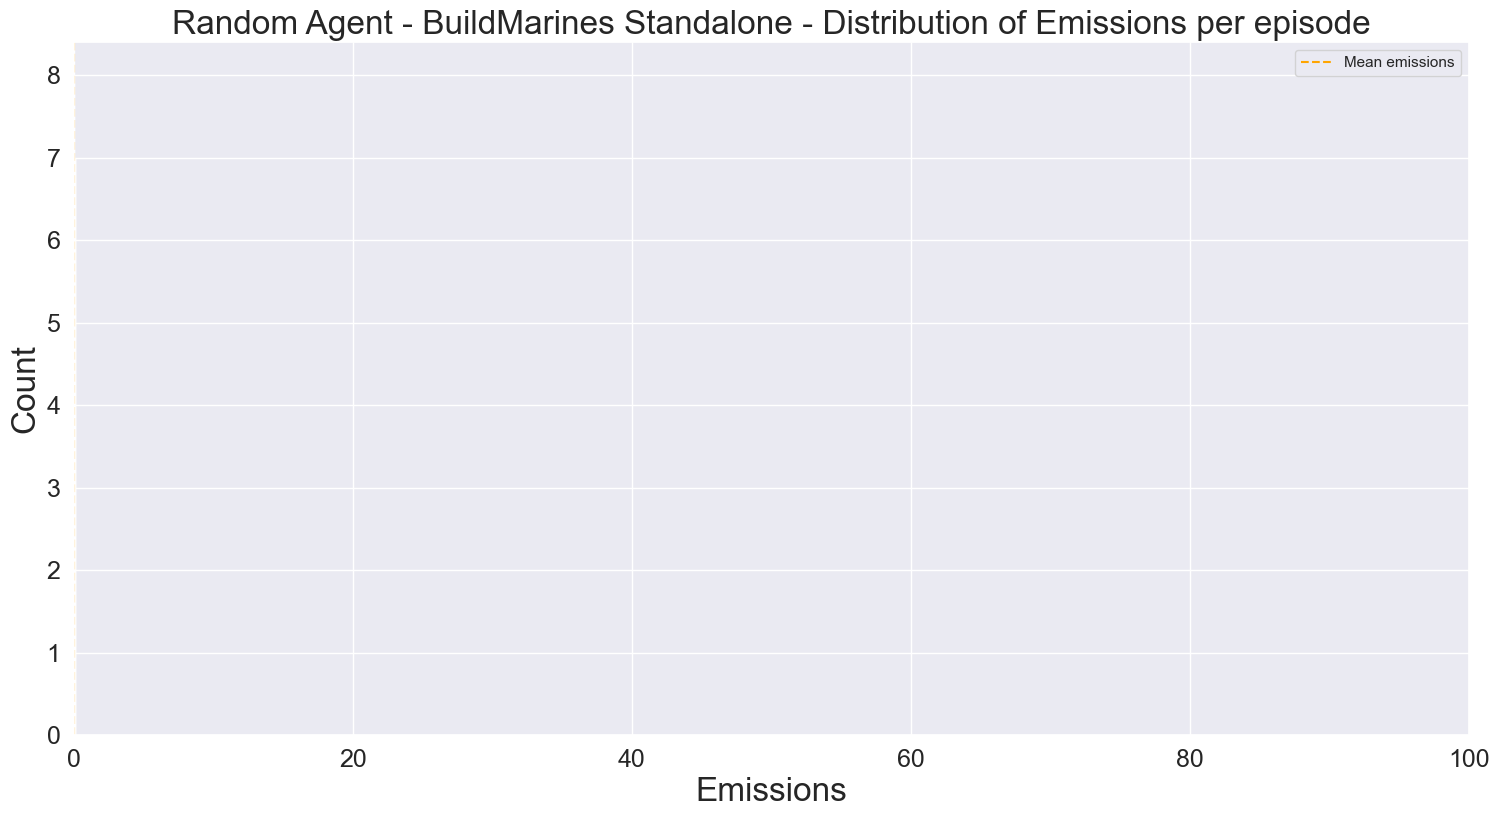

In [507]:
plot_emissions(**plot_args) ;

In [508]:
plot_losses(**plot_args) ;

No losses to plot (there are no training episodes


In [509]:
plot_epsilon(**plot_args) ;

No epsilon to plot (there are no training episodes


### Defeat Zerglings and banelings

In [597]:
defeat_zerglings_model_id ="defeat_zerglings_and_banelings"
save_images_path = images_path / "create_buffers"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "Random Agent - DefeatZerglingsAndBanelings Standalone"
save_prefix = f"random_standalone_{defeat_zerglings_model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(defeat_zerglings_model_id, model_path=buffer_models_path, show_plots=False, **common_args)
episode_stats.head()

Total episodes: 400
Total burnin episodes: 0
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 400
Unique maps in episode stats:  ['DefeatZerglingsAndBanelings']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon  \
0  DefeatZerglingsAndBanelings   196.0           103.76     35      1.0   
1  DefeatZerglingsAndBanelings    77.0            41.90     18      1.0   
2  DefeatZerglingsAndBanelings   118.0            25.89     22      1.0   
3  DefeatZerglingsAndBanelings   118.0             3.86     30      1.0   
4  DefeatZerglingsAndBanelings    67.0            15.89     20      1.0   

  losses  emissions  score  is_burnin  is_training  ...  episode  loss  \
0     []   0.000079  104.0      False         True  ...        0   NaN   
1     []   0.000154   42.0      False         True  ...        1   NaN   
2     []   0.000228   26.0      False         True  ...        2   NaN   
3     []   0.000295    4.0      False         True  ...        3   NaN   
4     []   0.000362   16.0      False         True  ...        4   NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 17, 'BUILD_BARRACK...             NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 7, 'BUILD_BARRACKS...             NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 8, 'BUILD_BARRACKS...             NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 11, 'BUILD_BARRACK...             NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 5, 'BUILD_BARRACKS...             NaN   

   mean_reward_10ep mean_adjusted_reward_10ep mean_score_10ep  \
0        196.000000                103.760000      104.000000   
1        136.500000                 72.830000       73.000000   
2        130.333333                 57.183333       57.333333   
3        127.250000                 43.852500       44.000000   
4        115.200000                 38.260000       38.400000   

   mean_emissions_10ep  accumulated_emissions  
0             0.000079               0.000079  
1             0.000117               0.000233  
2             0.000154               0.000462  
3             0.000189               0.000757  
4             0.000224               0.001119  

[5 rows x 24 columns]

In [598]:
plot_args = dict(episode_stats=episode_stats, **common_args)

Min/AVG/Max steps per episode:  9 33.185 61


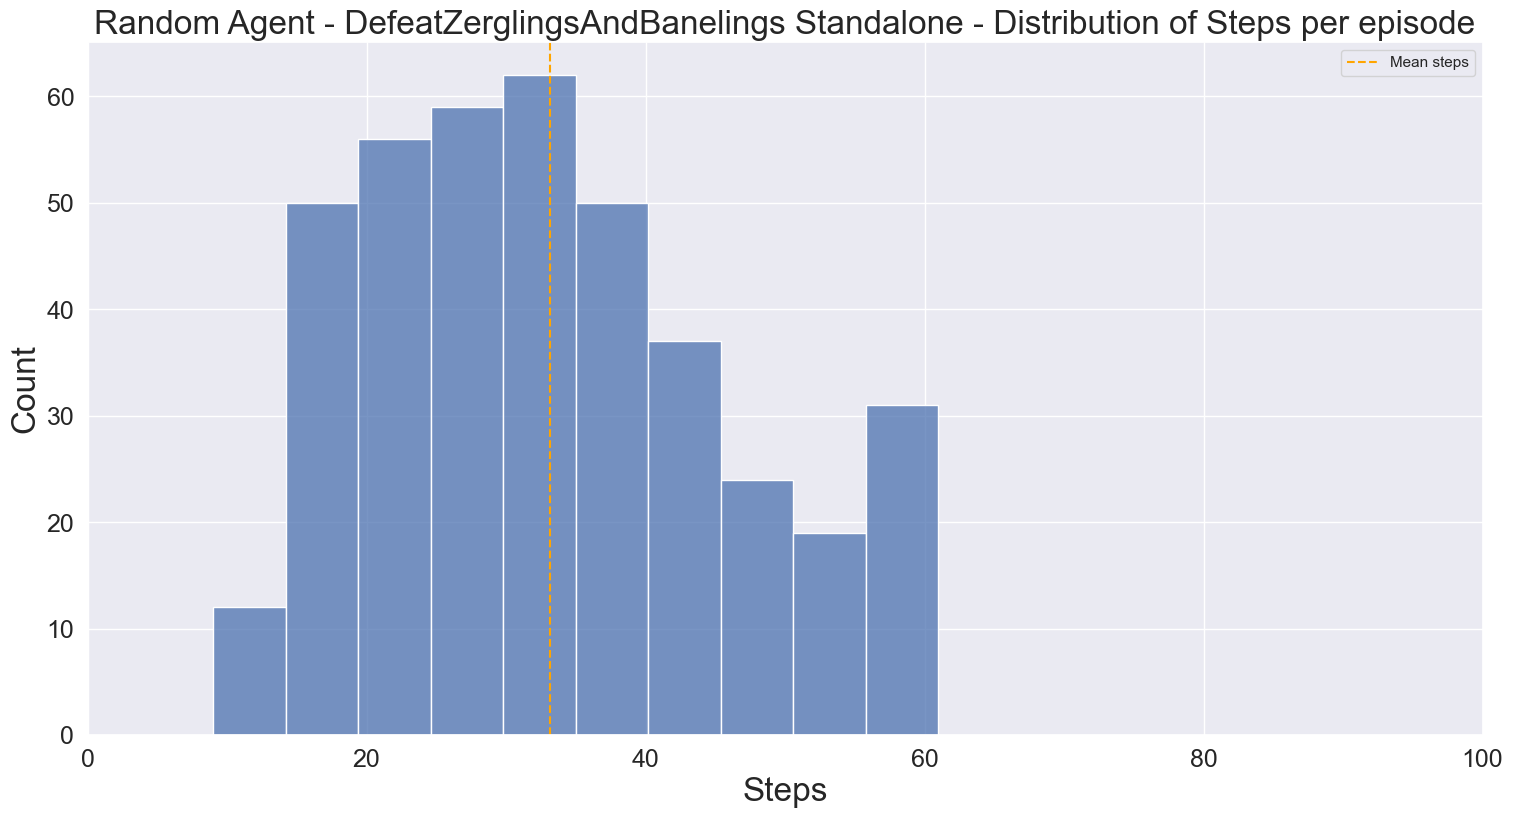

In [599]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args)

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


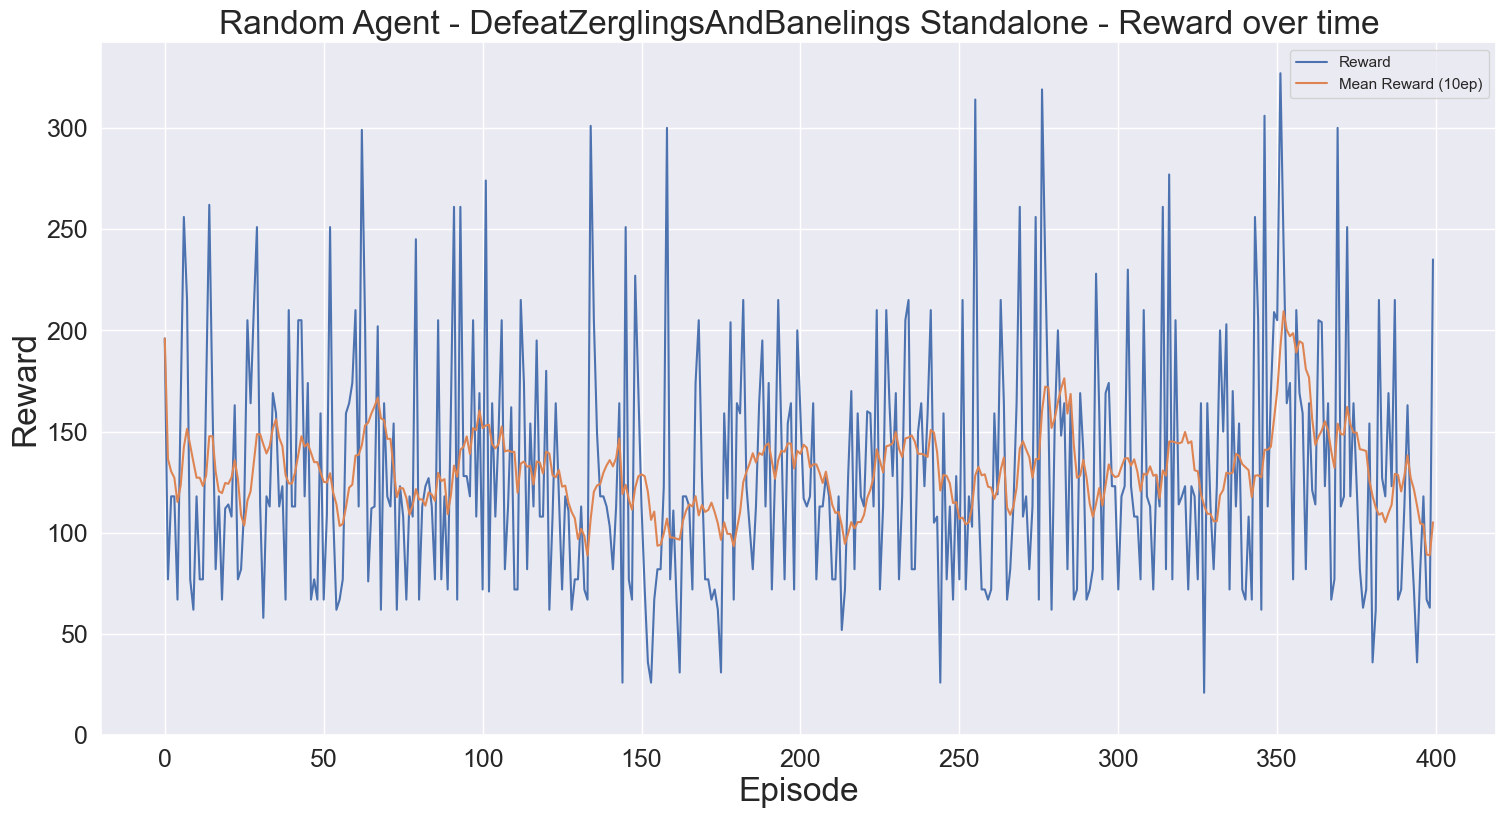

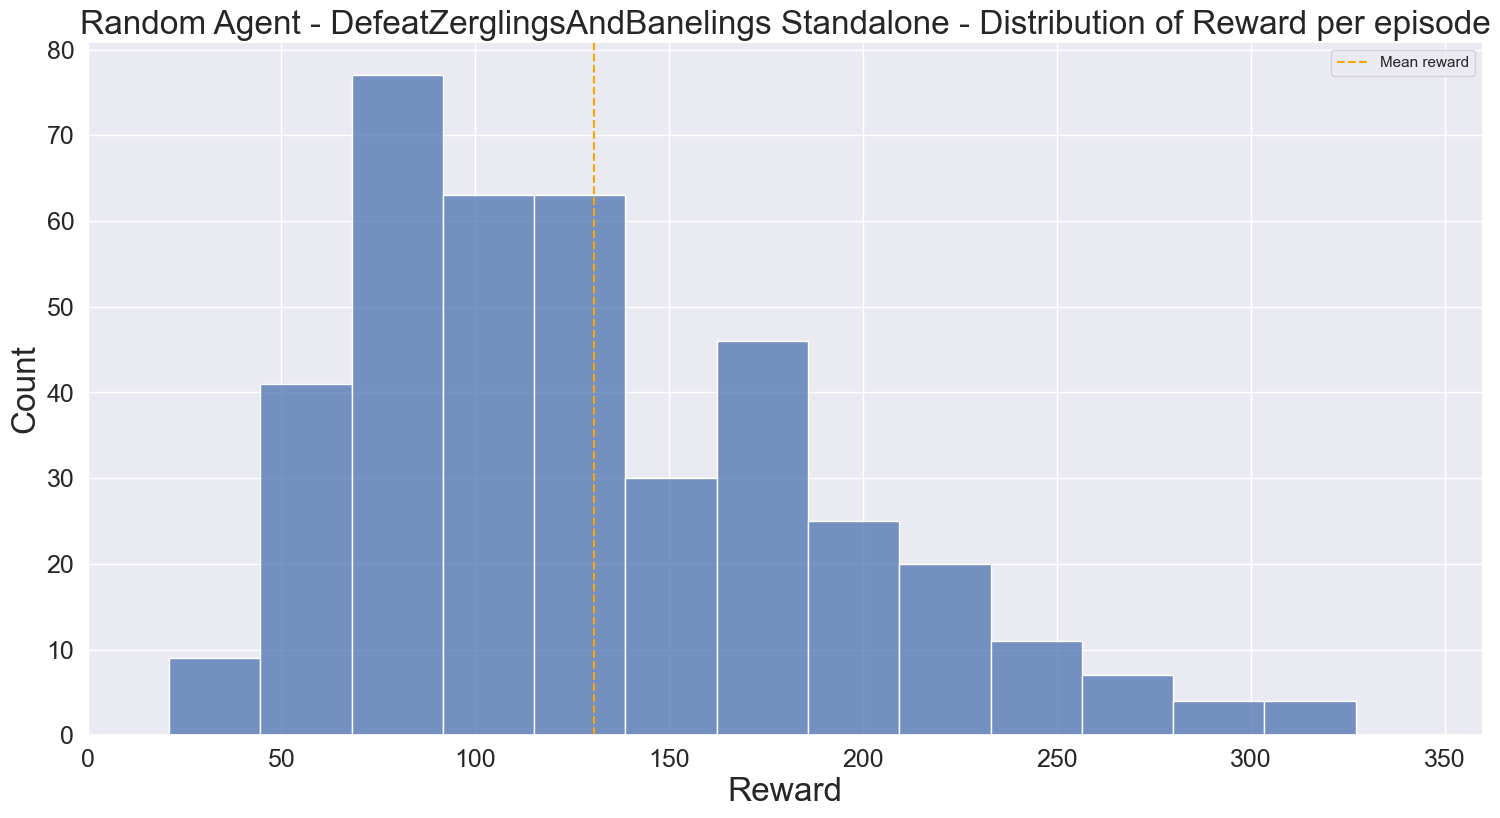

In [513]:
plot_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


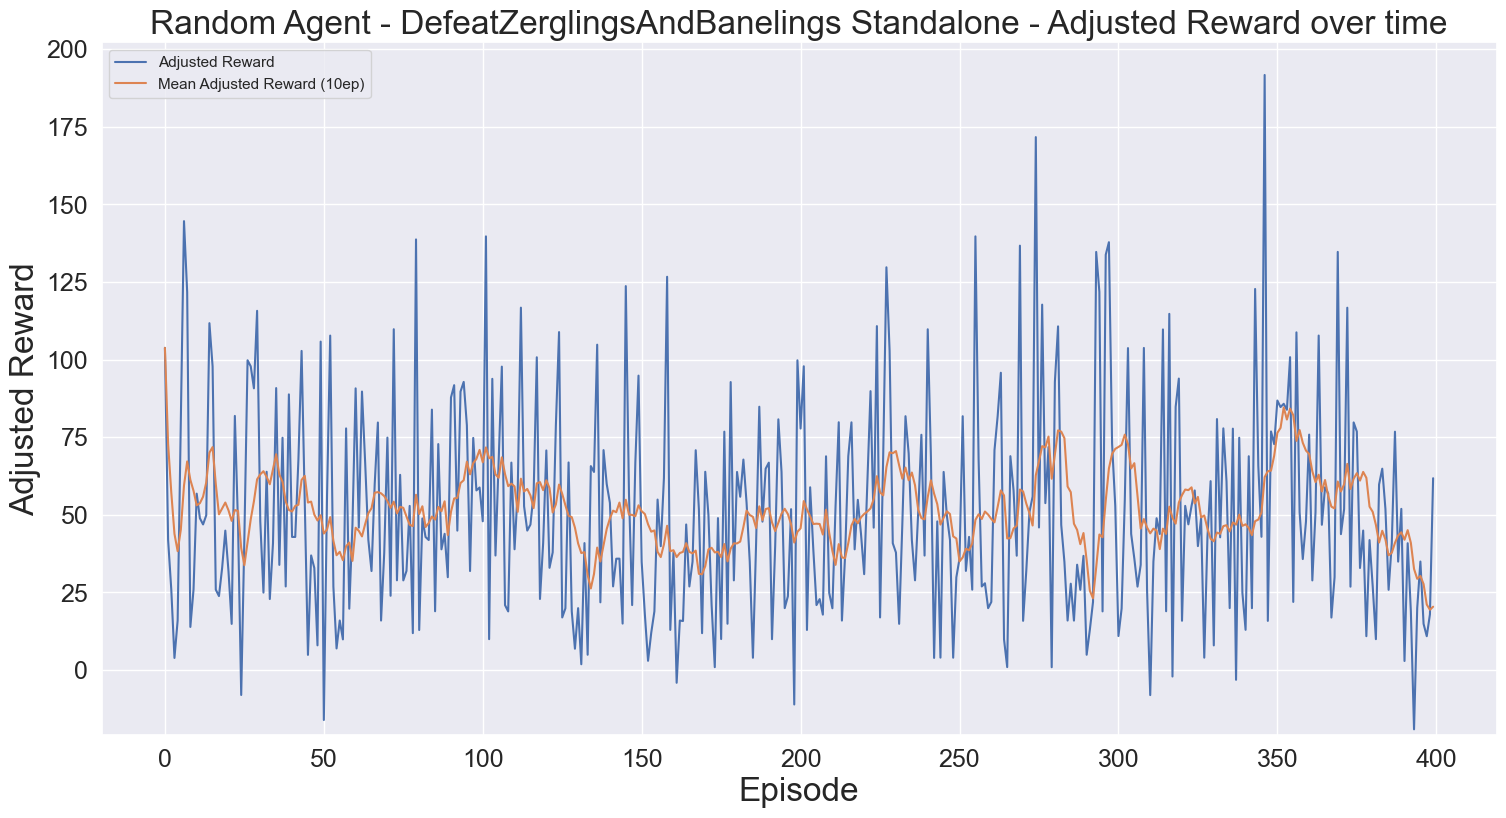

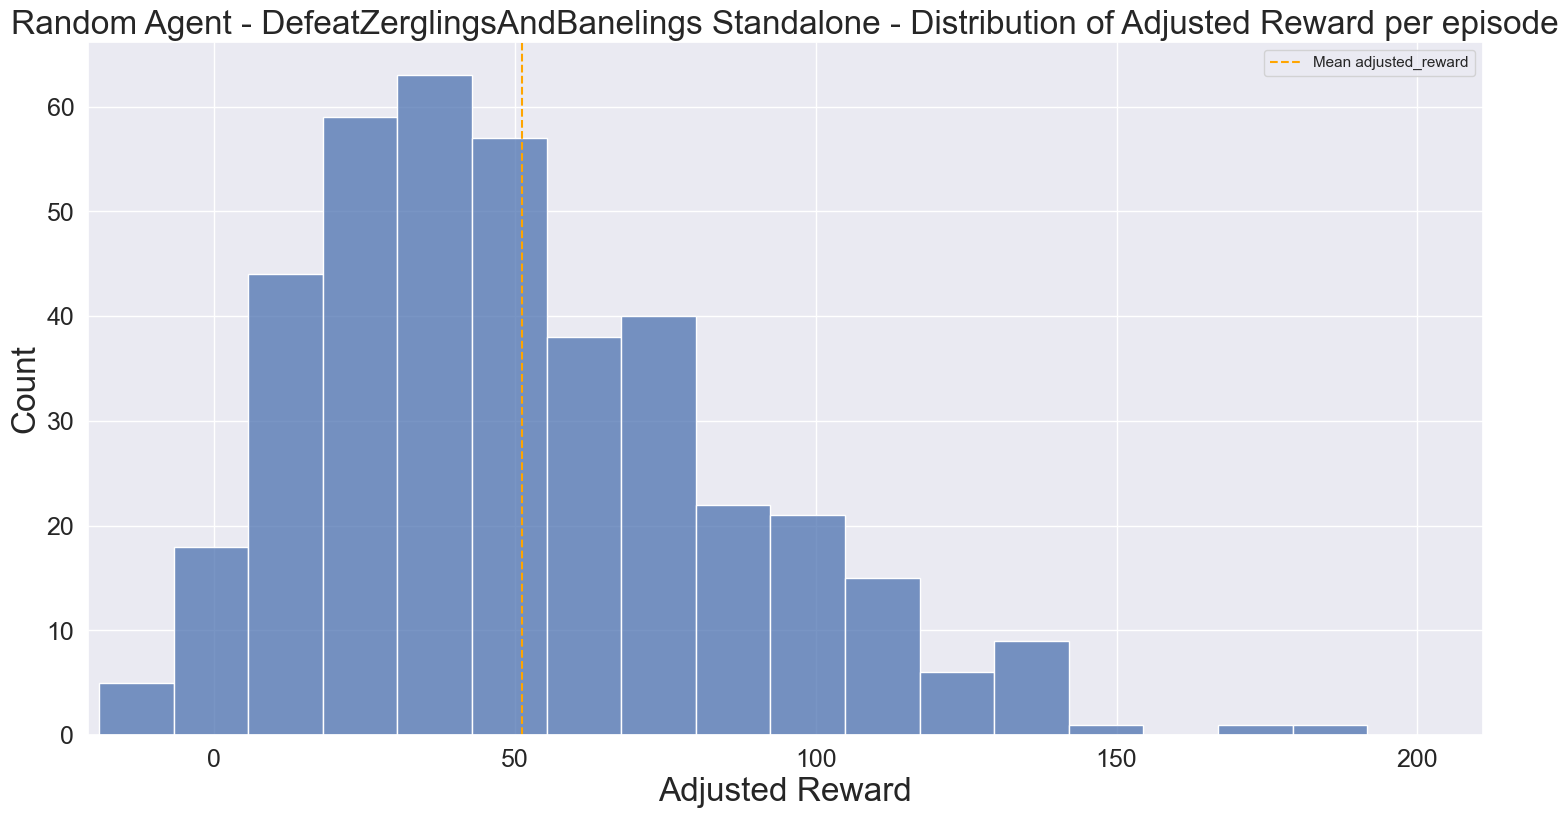

In [514]:
plot_adjusted_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


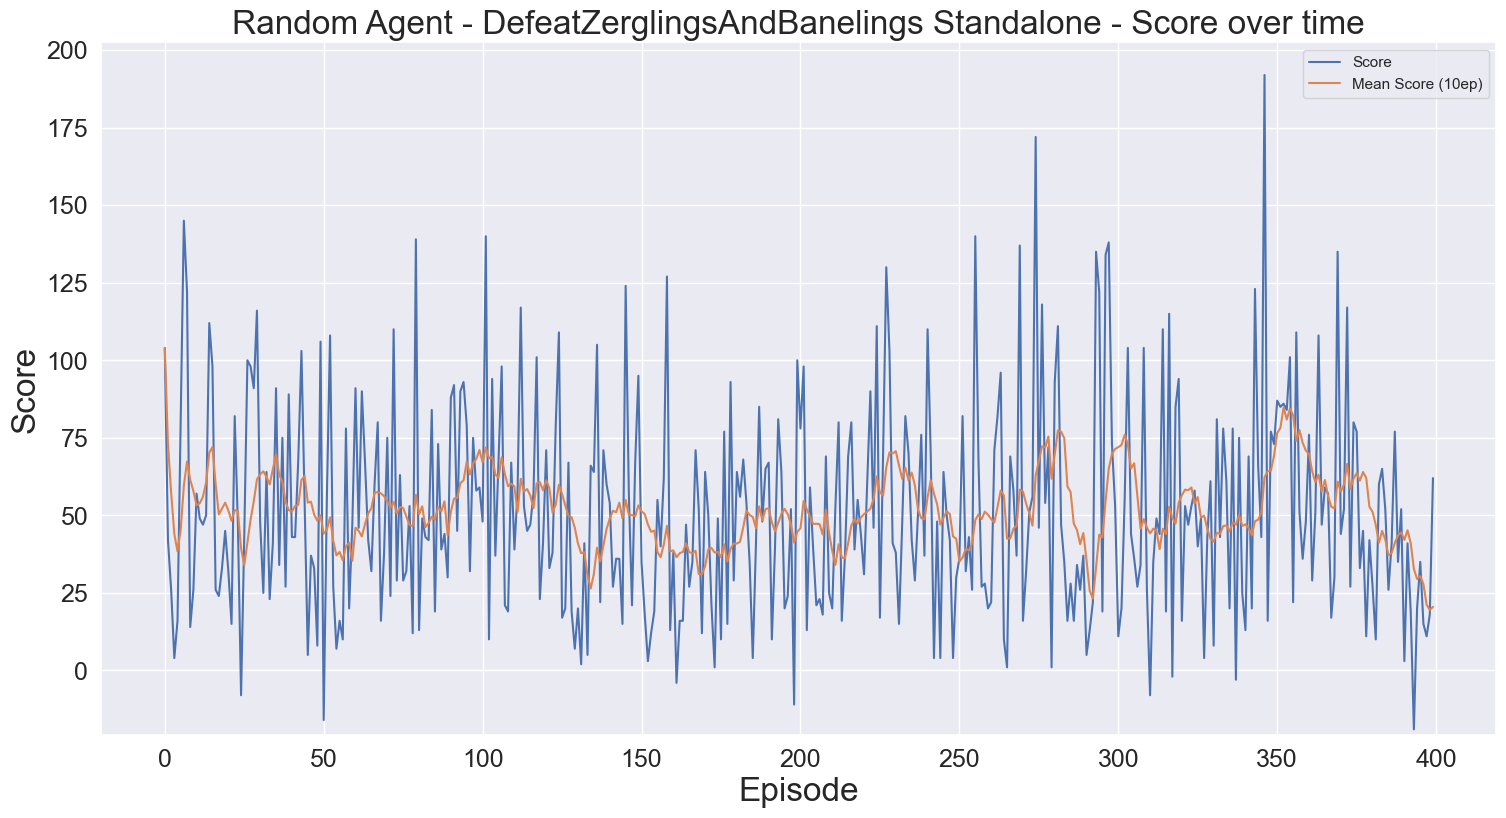

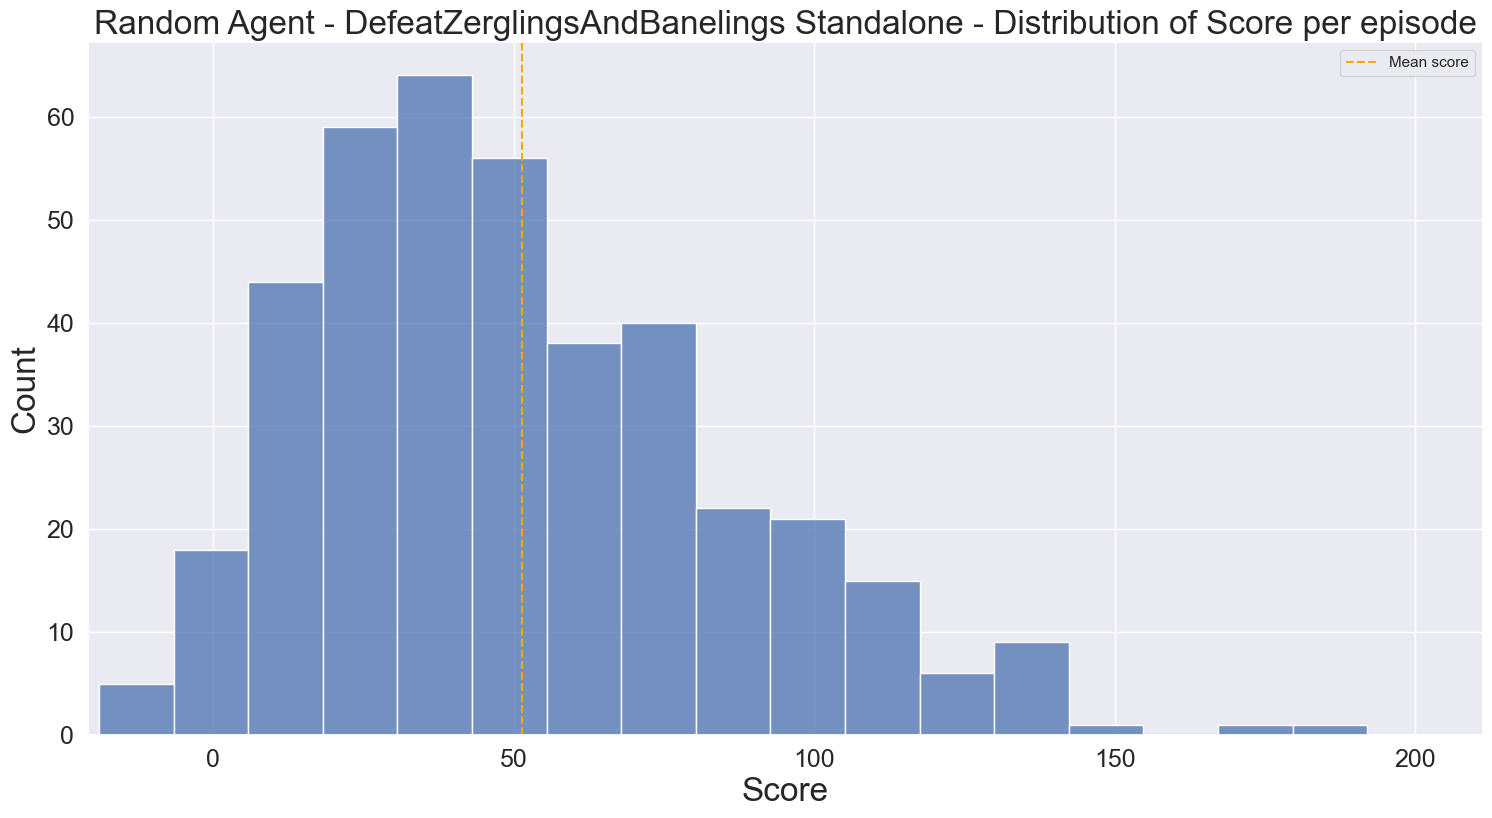

In [515]:
plot_scores(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


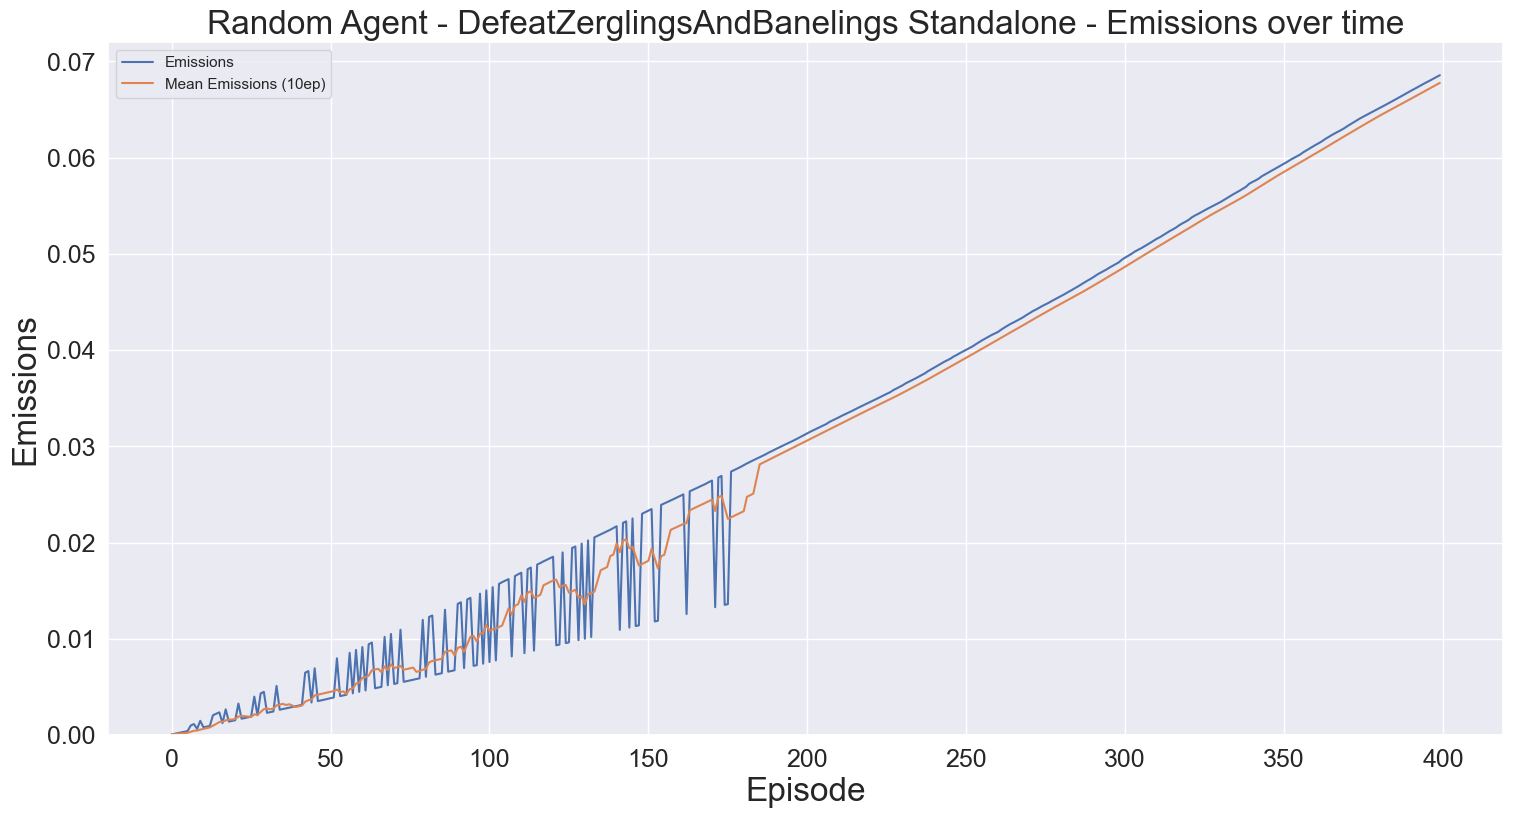

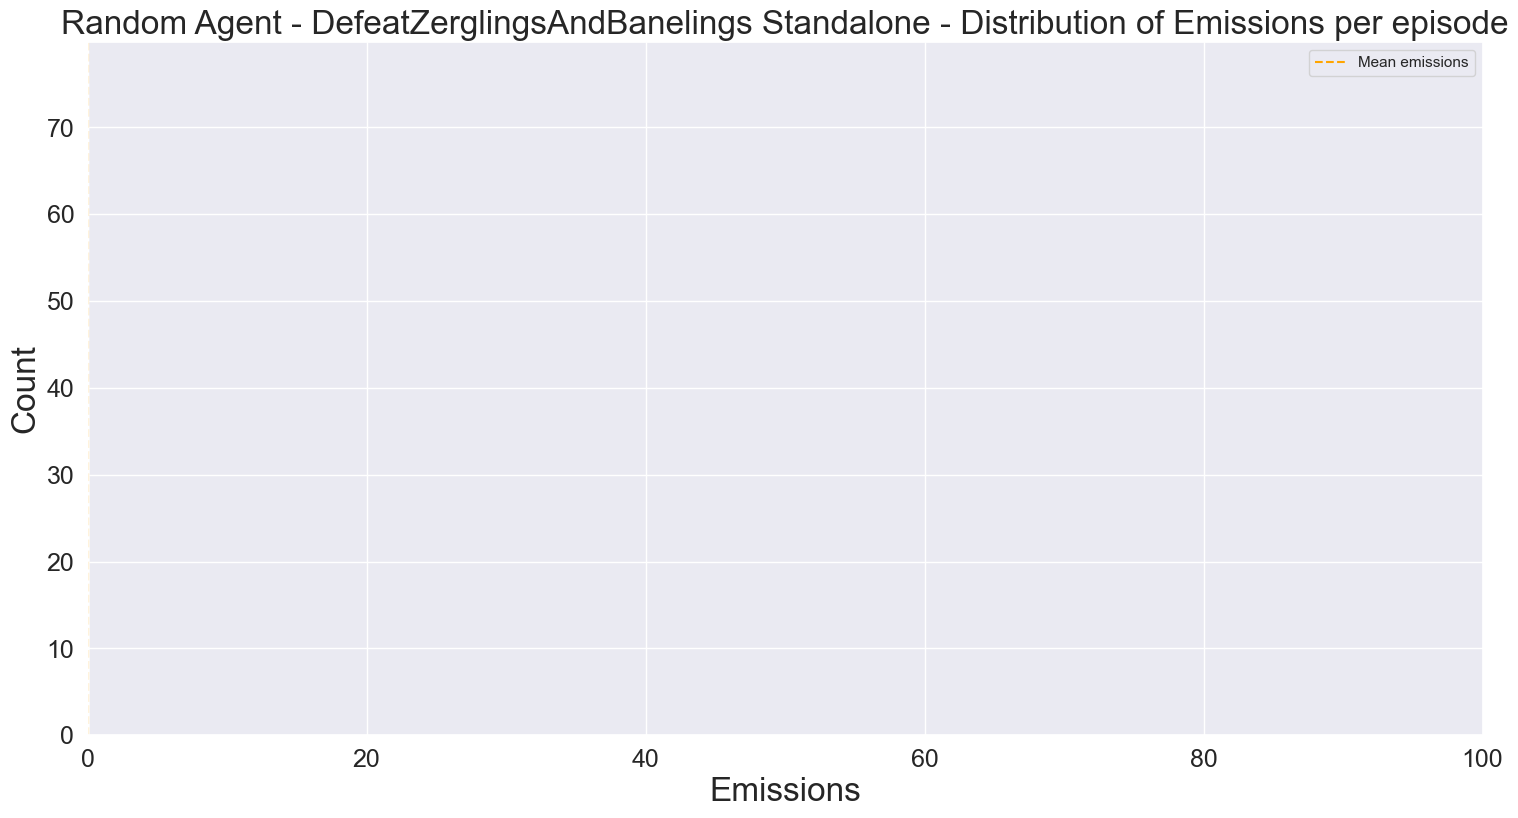

In [516]:
plot_emissions(**plot_args) ;

In [517]:
plot_losses(**plot_args) ;

No losses to plot (there are no training episodes


In [518]:
plot_epsilon(**plot_args) ;

No epsilon to plot (there are no training episodes


### Simple64

In [605]:
simple64_model_id = "simple64"
save_images_path = images_path / "create_buffers"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "Random Agent - Simple64 Standalone"
save_prefix = f"random_standalone_{simple64_model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(simple64_model_id, model_path=buffer_models_path, show_plots=False, **common_args)
episode_stats.head()

Total episodes: 50
Total burnin episodes: 0
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 50
Unique maps in episode stats:  ['Simple64']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
0  Simple64     1.0           -39.18    256      1.0     []   0.001447   
1  Simple64    -1.0          -145.63   1296      1.0     []   0.024448   
2  Simple64    -1.0           -47.66    409      1.0     []   0.016470   
3  Simple64     1.0           -32.07    238      1.0     []   0.012363   
4  Simple64    -1.0           -51.23    370      1.0     []   0.020066   

    score  is_burnin  is_training  ...  episode  loss  \
0  6052.0      False         True  ...        0   NaN   
1  -608.0      False         True  ...        1   NaN   
2  2222.0      False         True  ...        2   NaN   
3  5489.0      False         True  ...        3   NaN   
4  1268.0      False         True  ...        4   NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 15, 'BUILD_BARRACK...             NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 104, 'BUILD_BARRAC...             NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 9, 'BUILD_BARRACKS...             NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 16, 'BUILD_BARRACK...             NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 10, 'BUILD_BARRACK...             NaN   

   mean_reward_10ep mean_adjusted_reward_10ep mean_score_10ep  \
0          1.000000                   -39.180     6052.000000   
1          0.000000                   -92.405     2722.000000   
2         -0.333333                   -77.490     2555.333333   
3          0.000000                   -66.135     3288.750000   
4         -0.200000                   -63.154     2884.600000   

   mean_emissions_10ep  accumulated_emissions  
0             0.001447               0.001447  
1             0.012947               0.025895  
2             0.014122               0.042365  
3             0.013682               0.054728  
4             0.014959               0.074795  

[5 rows x 24 columns]

In [606]:
plot_args = dict(episode_stats=episode_stats, **common_args)

Min/AVG/Max steps per episode:  238 439.78 1296


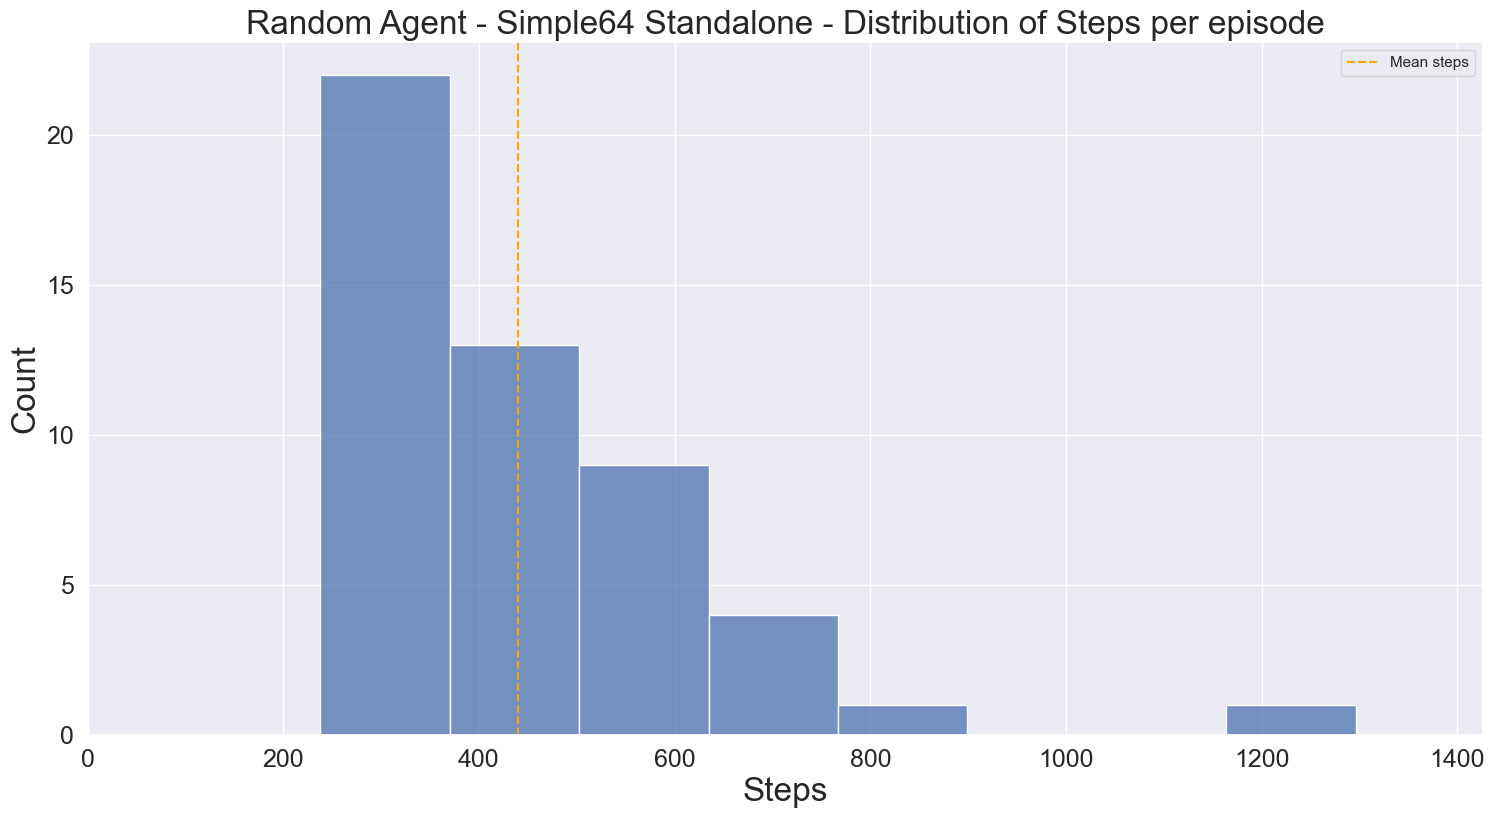

In [607]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args)

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


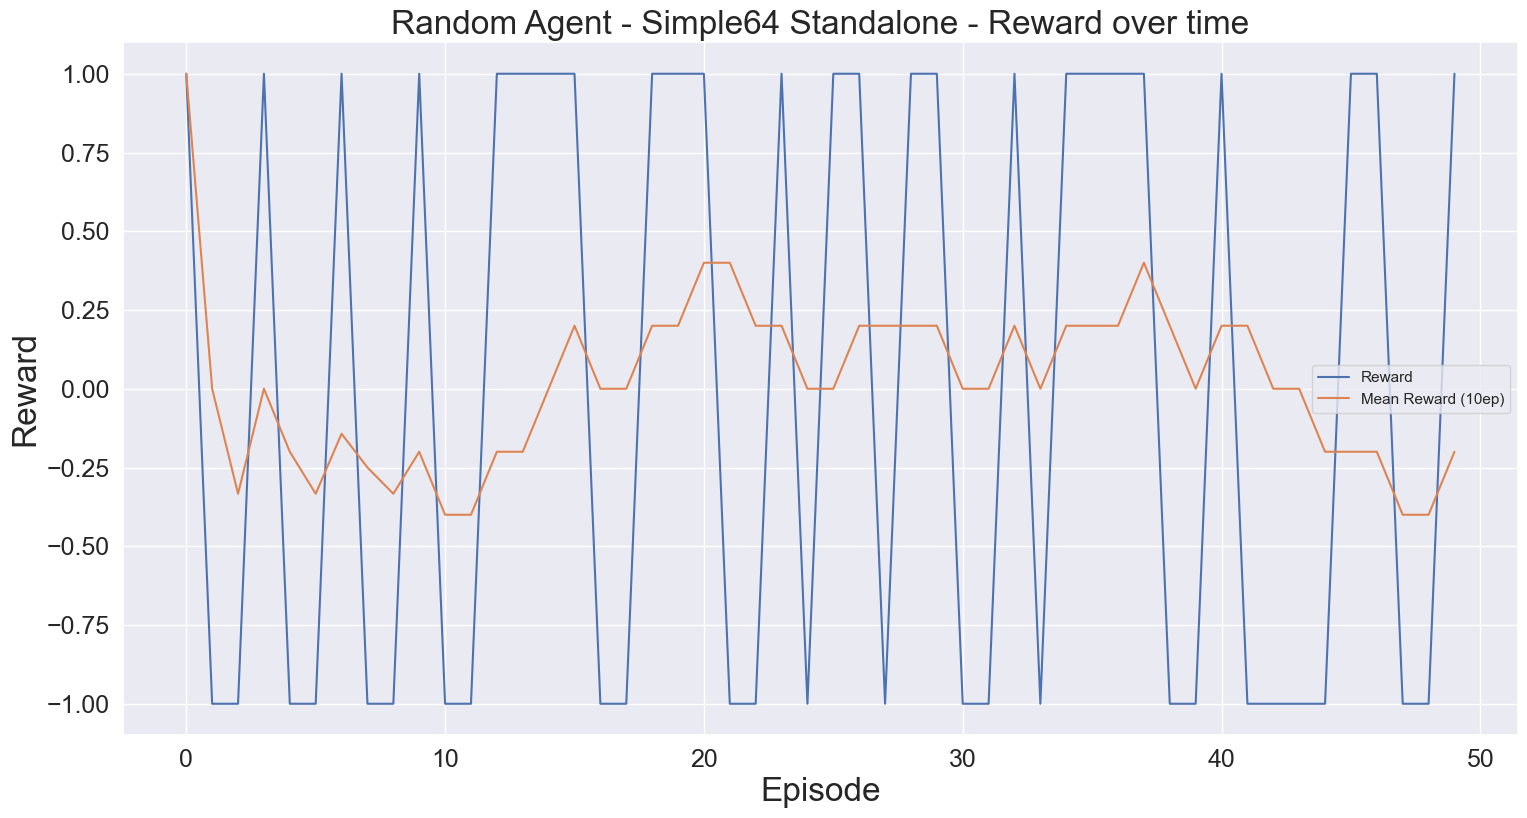

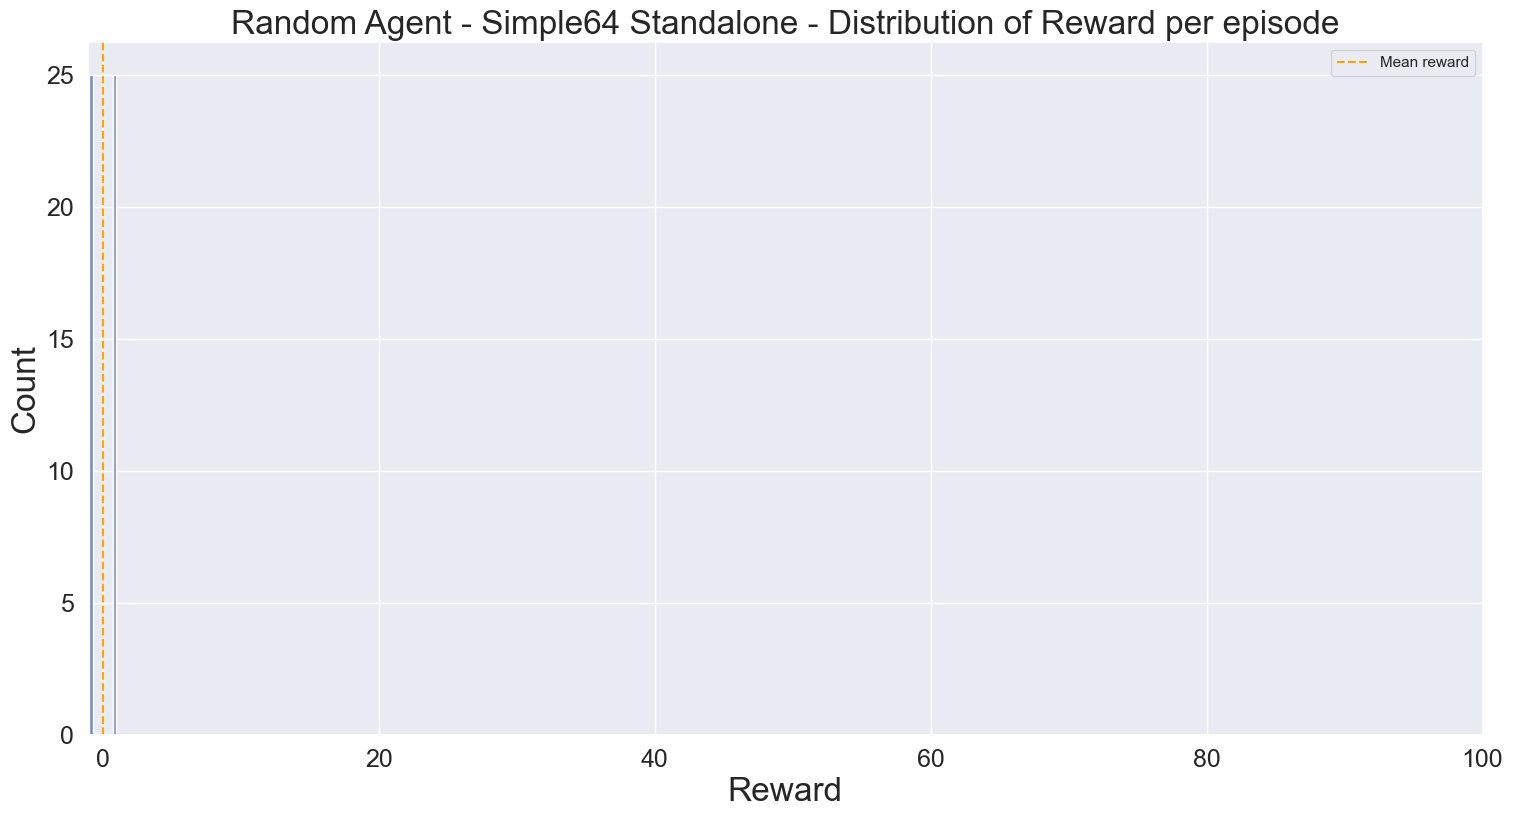

In [521]:
plot_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


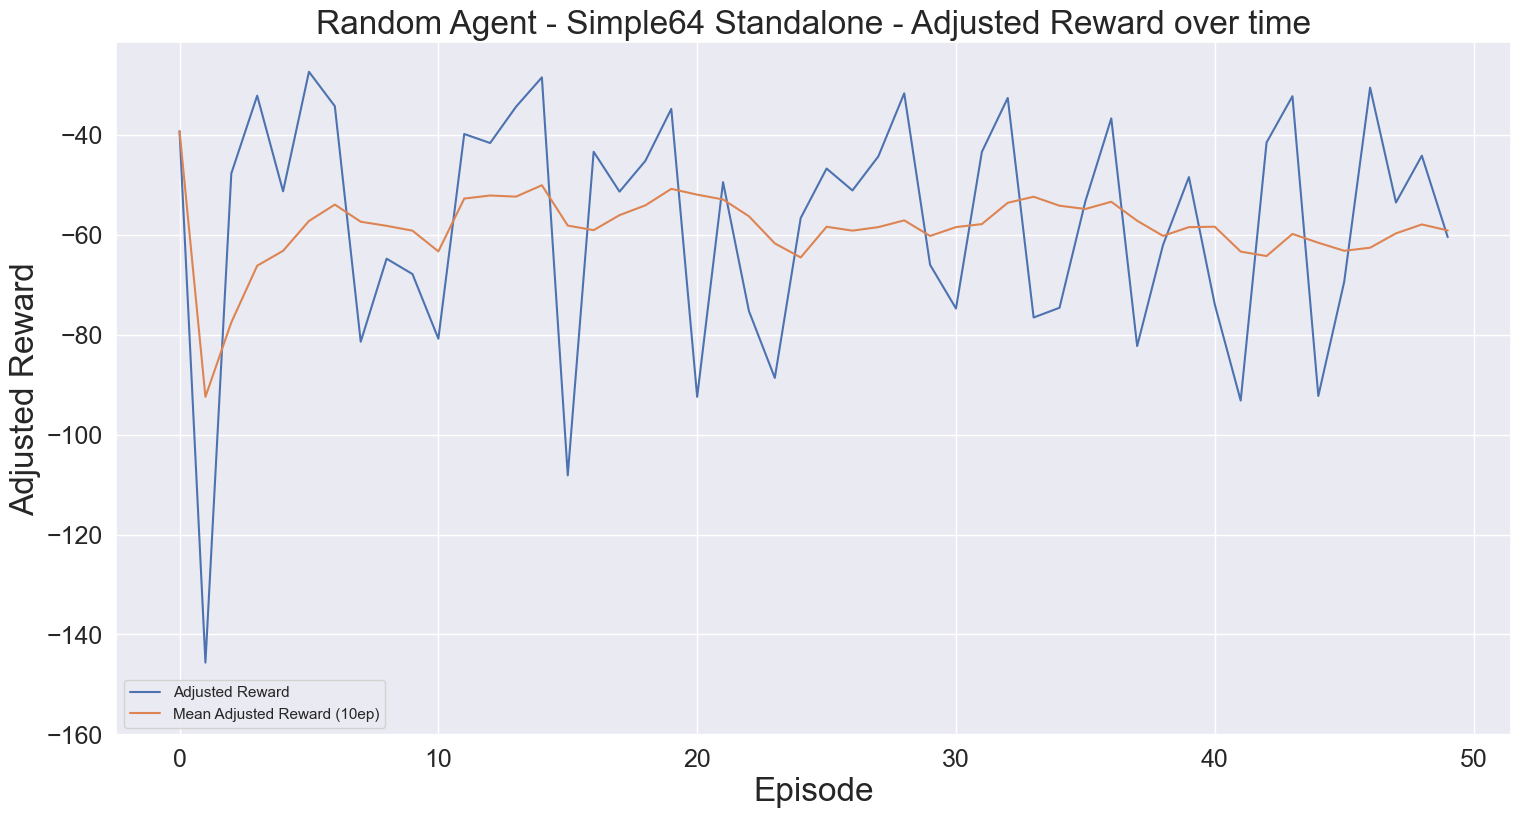

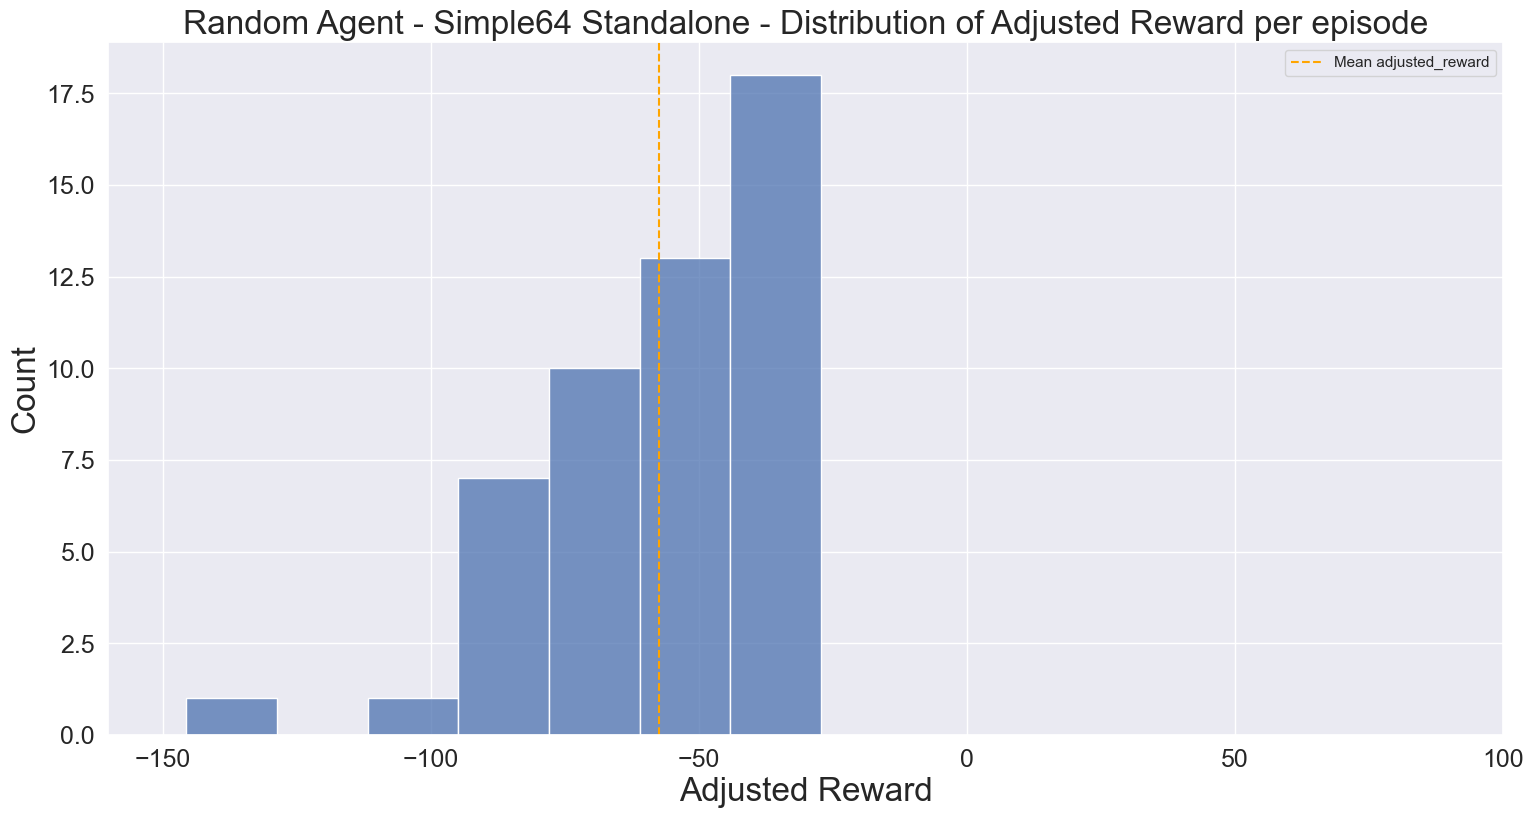

In [522]:
plot_adjusted_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


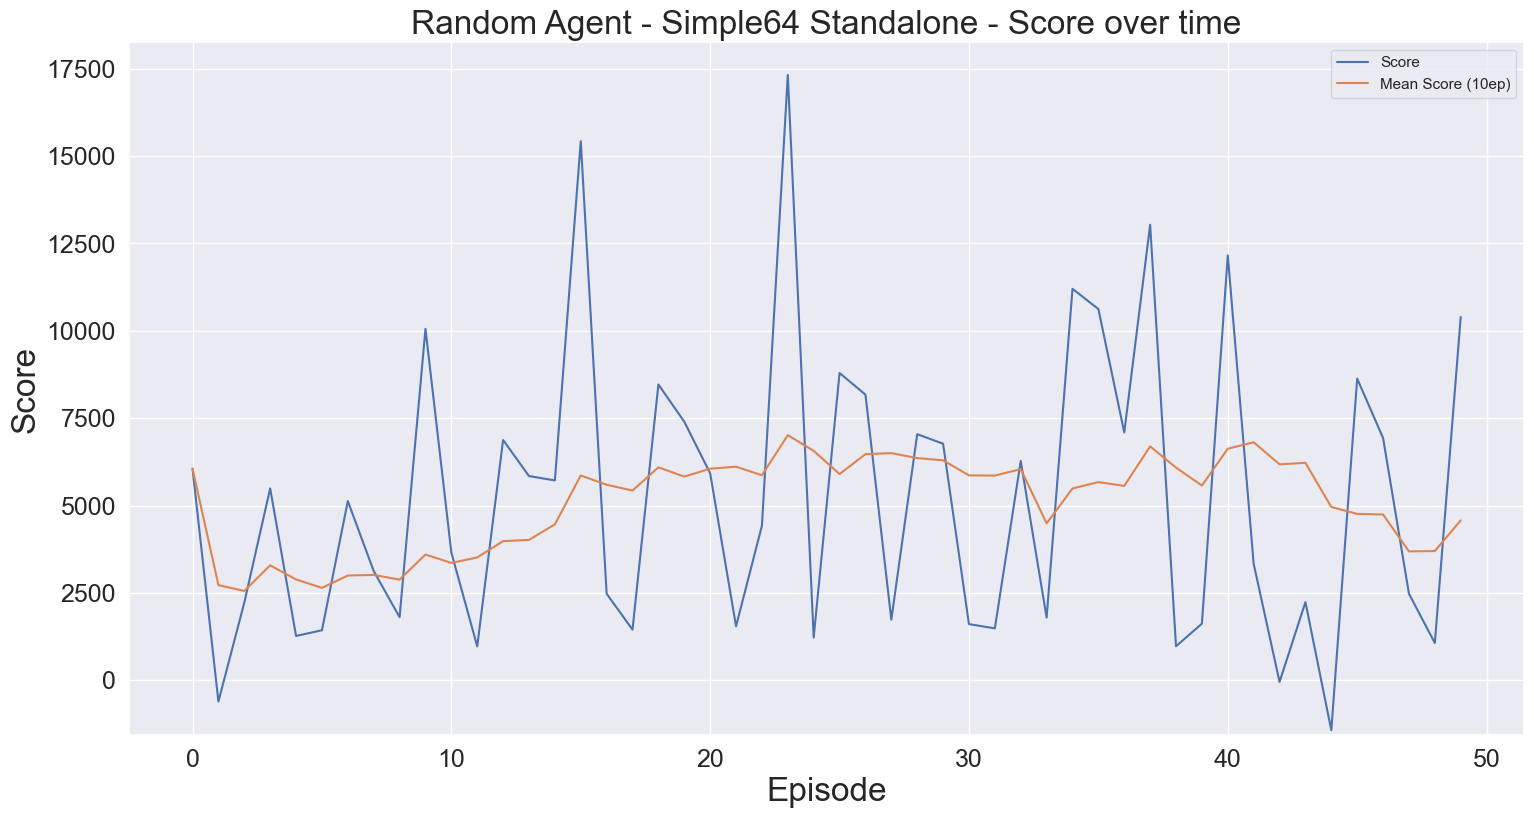

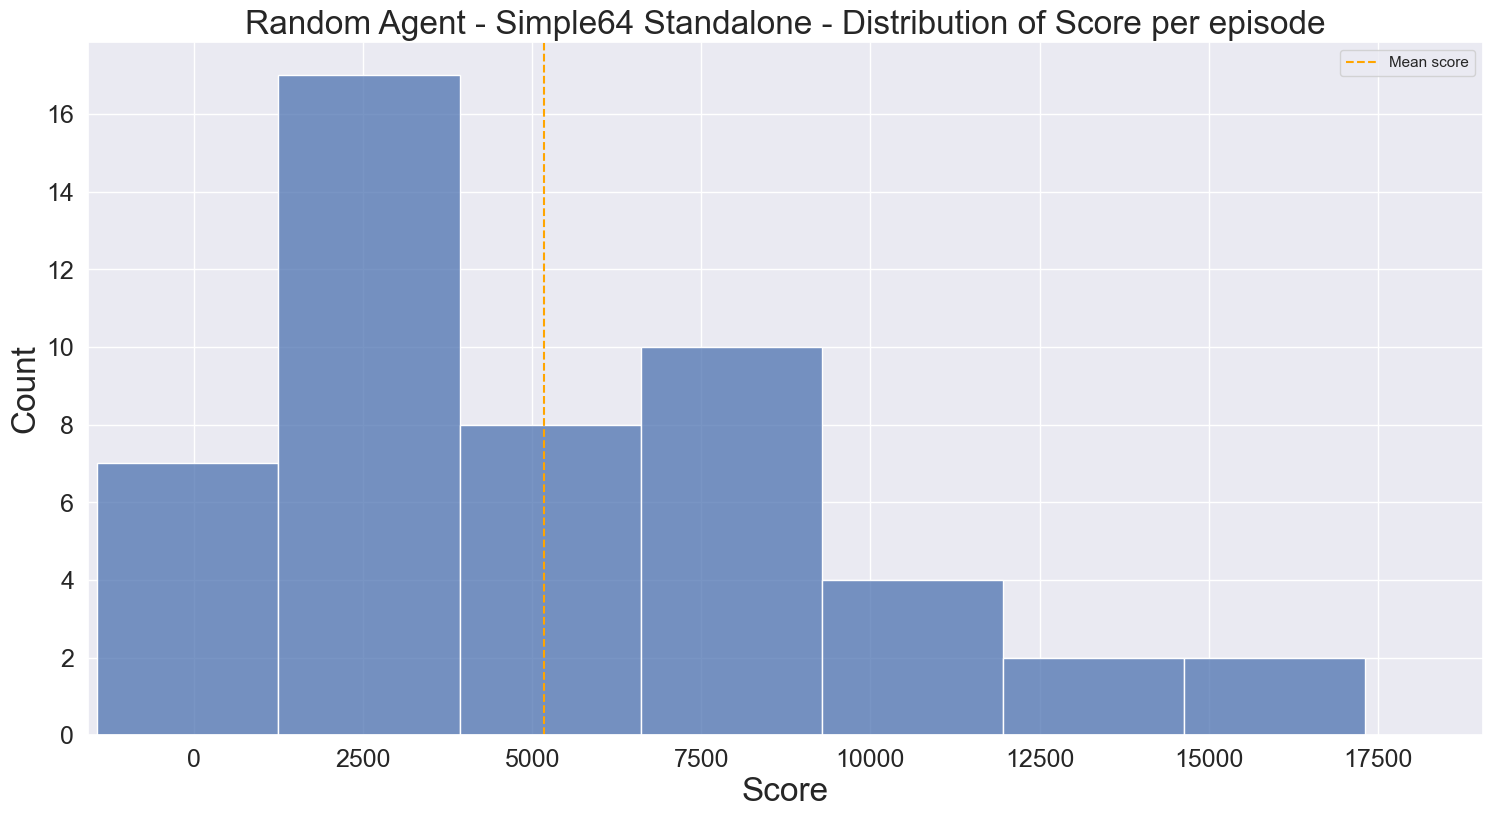

In [523]:
plot_scores(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\1052999354.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


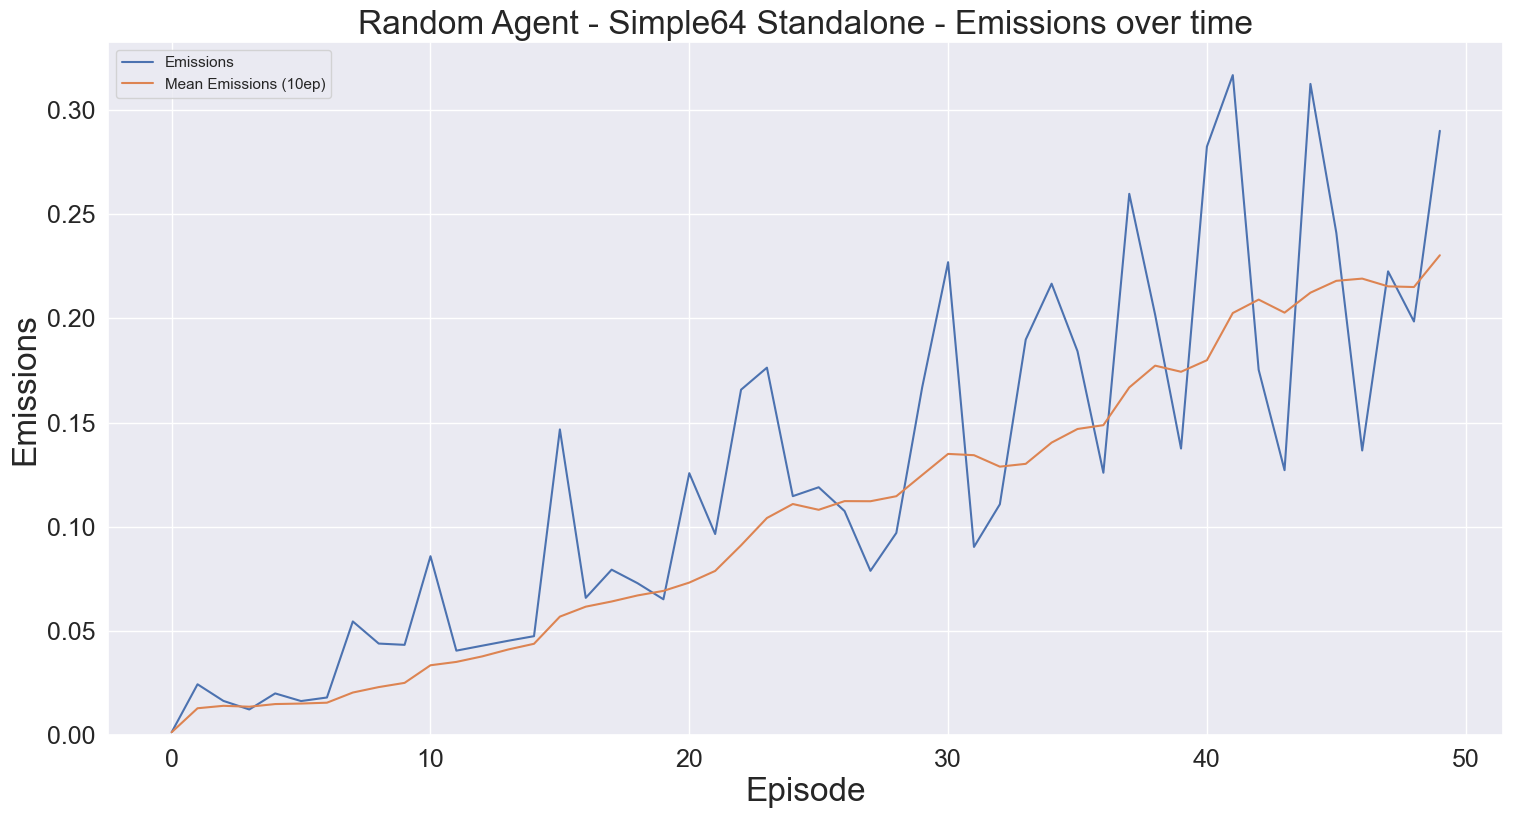

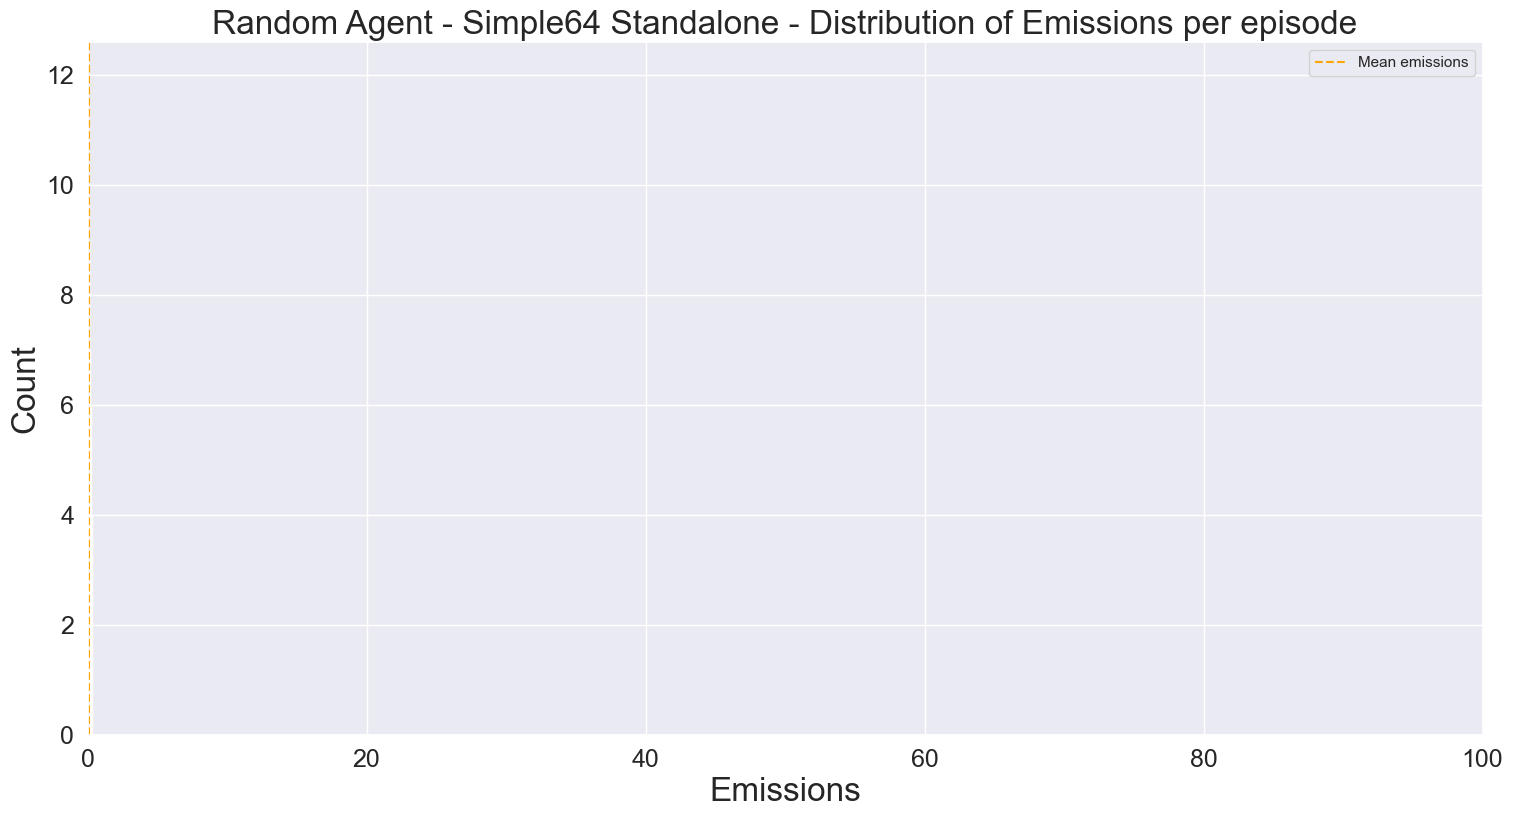

In [524]:
plot_emissions(**plot_args) ;

In [525]:
plot_losses(**plot_args) ;

No losses to plot (there are no training episodes


In [526]:
plot_epsilon(**plot_args) ;

No epsilon to plot (there are no training episodes


### Template

In [ ]:
model_id ="defeat_zerglings_and_banelings"
save_images_path = images_path / "create_buffers"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "Random Agent - DefeatZerglingsAndBanelings Standalone"
save_prefix = f"random_standalone_{model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(model_id, model_path=buffer_models_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

# One cell per line for those

plot_rewards(**plot_args) ;
plot_adjusted_rewards(**plot_args) ;
plot_scores(**plot_args) ;
plot_emissions(**plot_args) ;
plot_losses(**plot_args) ;
plot_epsilon(**plot_args) ;

## DQN Agents

### Collect Minerals - Standalone

In [608]:
model_id = "collect_minerals"
model_path = single_dqn_models_path
reward_scheme = "score"
save_images_path = images_path / "dqn" / "standalone" / reward_scheme
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = "DQN Agent - CollectMinerals - Score-based rewards"
save_prefix = f"dqn_standalone_{reward_scheme}_{model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path, save_prefix=save_prefix)
episode_stats, agent_stats, aggregated_stats = load_stats(model_id, model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 300
Total burnin episodes: 0
Total random mode episodes: 0
Total episodes: 300
Total exploit episodes: 0
Unique maps in episode stats:  ['CollectMineralsAndGas']


map_name  reward  adjusted_reward  steps   epsilon  \
0  CollectMineralsAndGas  4090.0          3066.36    211  1.000000   
1  CollectMineralsAndGas  4195.0          3191.31    211  0.990000   
2  CollectMineralsAndGas  3910.0          3080.27    211  0.980100   
3  CollectMineralsAndGas  4280.0          3428.29    211  0.970299   
4  CollectMineralsAndGas  3225.0          2428.39    211  0.960596   

                                              losses  emissions   score  \
0  [16.98892593383789, 17.20028305053711, 16.5667...   0.000494  3068.0   
1  [16.274398803710938, 17.734193801879883, 17.06...   0.001135  3193.0   
2  [18.02963638305664, 17.031883239746094, 18.512...   0.001685  3082.0   
3  [16.43059539794922, 16.259681701660156, 17.098...   0.002169  3430.0   
4  [16.989171981811523, 17.295894622802734, 16.67...   0.002679  2430.0   

   is_burnin  is_training  ...  episode       loss  \
0      False         True  ...        0  17.174823   
1      False         True  ...        1  16.891346   
2      False         True  ...        2  17.497086   
3      False         True  ...        3  16.736824   
4      False         True  ...        4  16.823049   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...       17.174823   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...       17.033084   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...       17.187752   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...       17.075020   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...       17.024626   

   mean_reward_10ep mean_adjusted_reward_10ep mean_score_10ep  \
0           4090.00               3066.360000     3068.000000   
1           4142.50               3128.835000     3130.500000   
2           4065.00               3112.646667     3114.333333   
3           4118.75               3191.557500     3193.250000   
4           3940.00               3038.924000     3040.600000   

   mean_emissions_10ep  accumulated_emissions  
0             0.000494               0.000494  
1             0.000814               0.001629  
2             0.001105               0.003314  
3             0.001371               0.005483  
4             0.001632               0.008161  

[5 rows x 24 columns]

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\3887461656.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


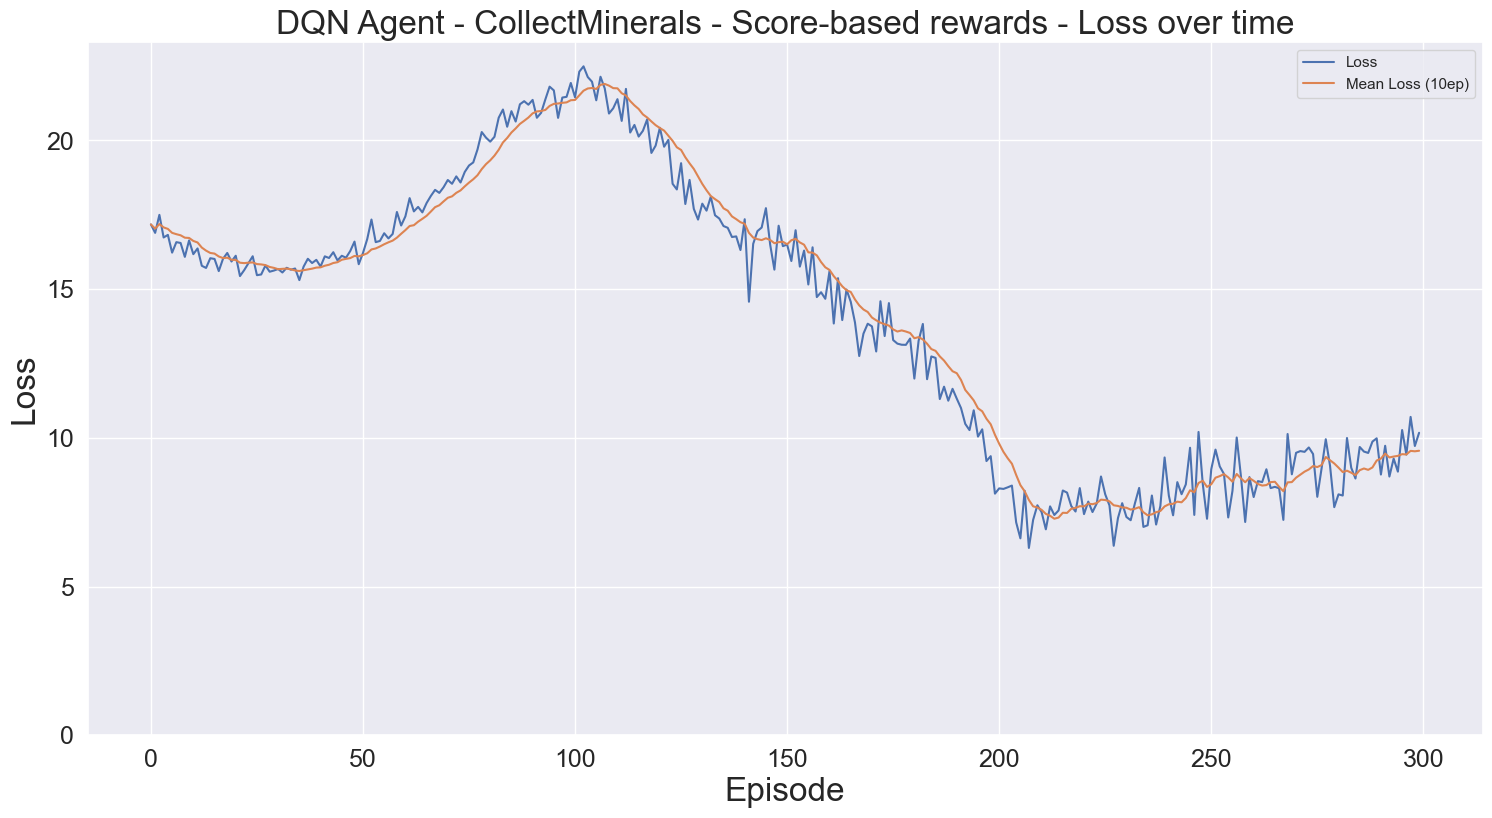

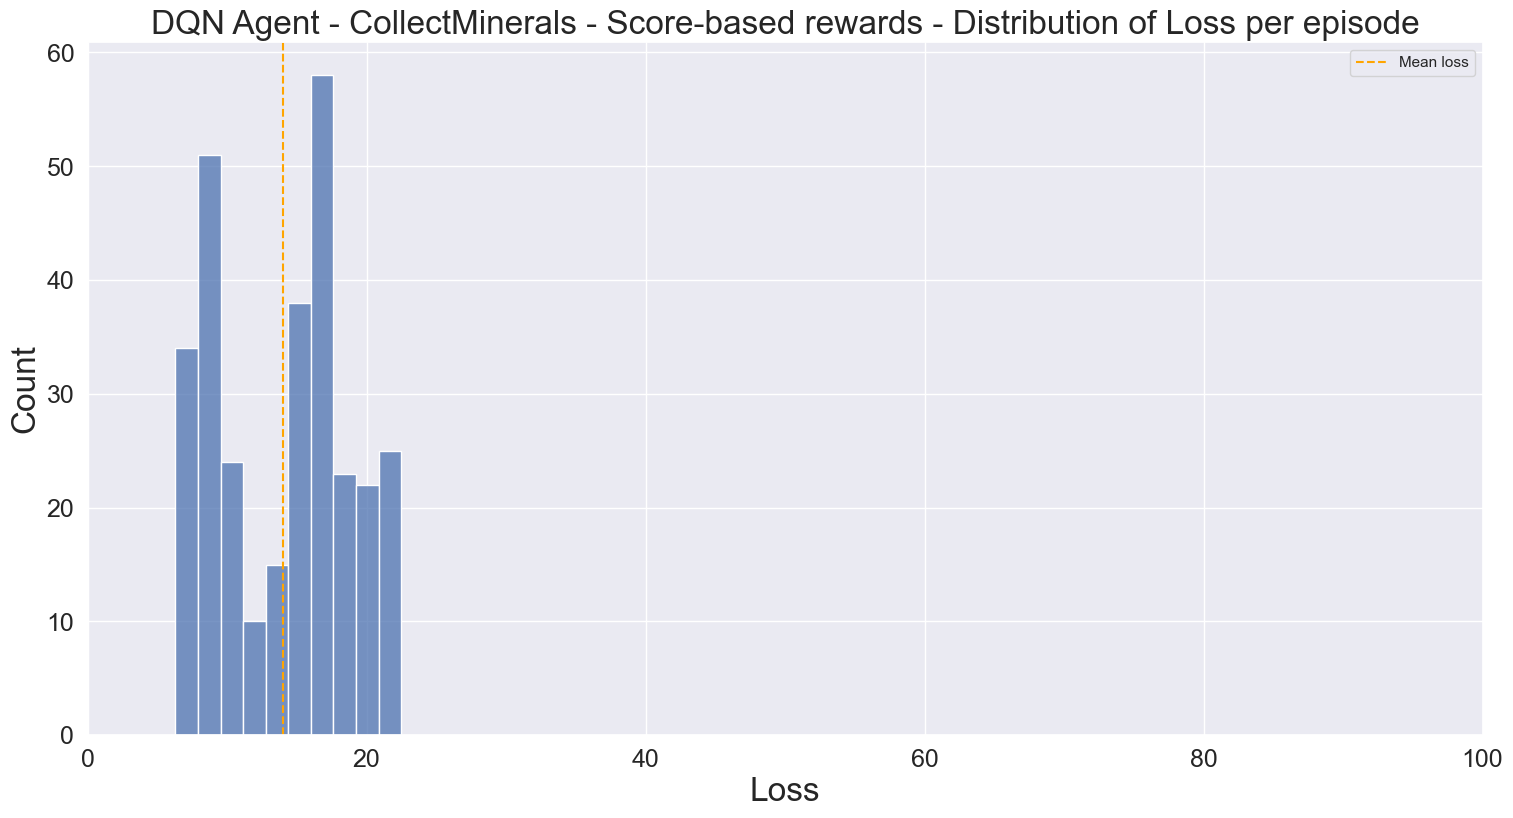

In [609]:
plot_losses(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\3887461656.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


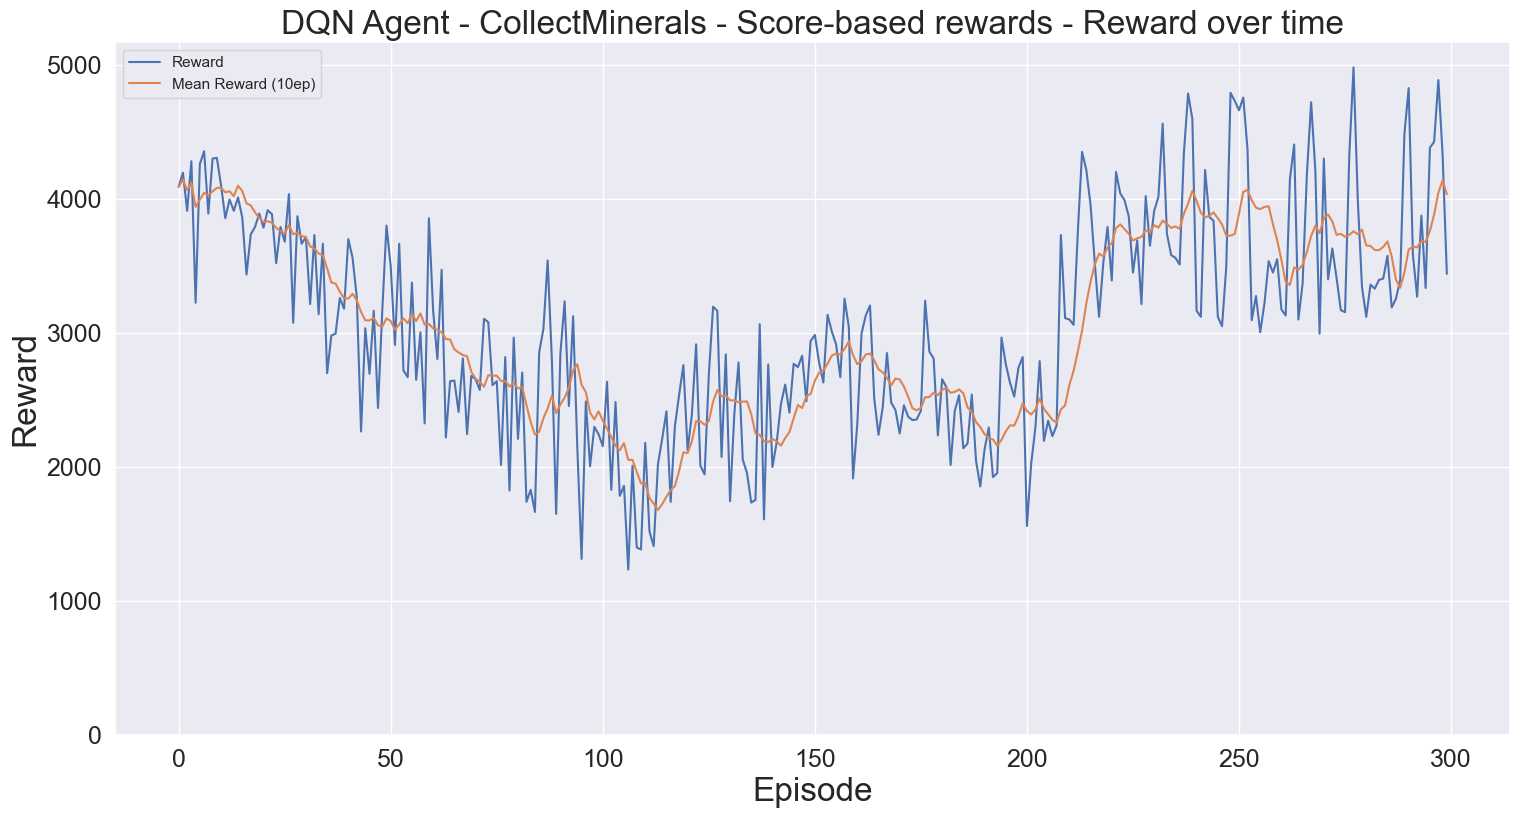

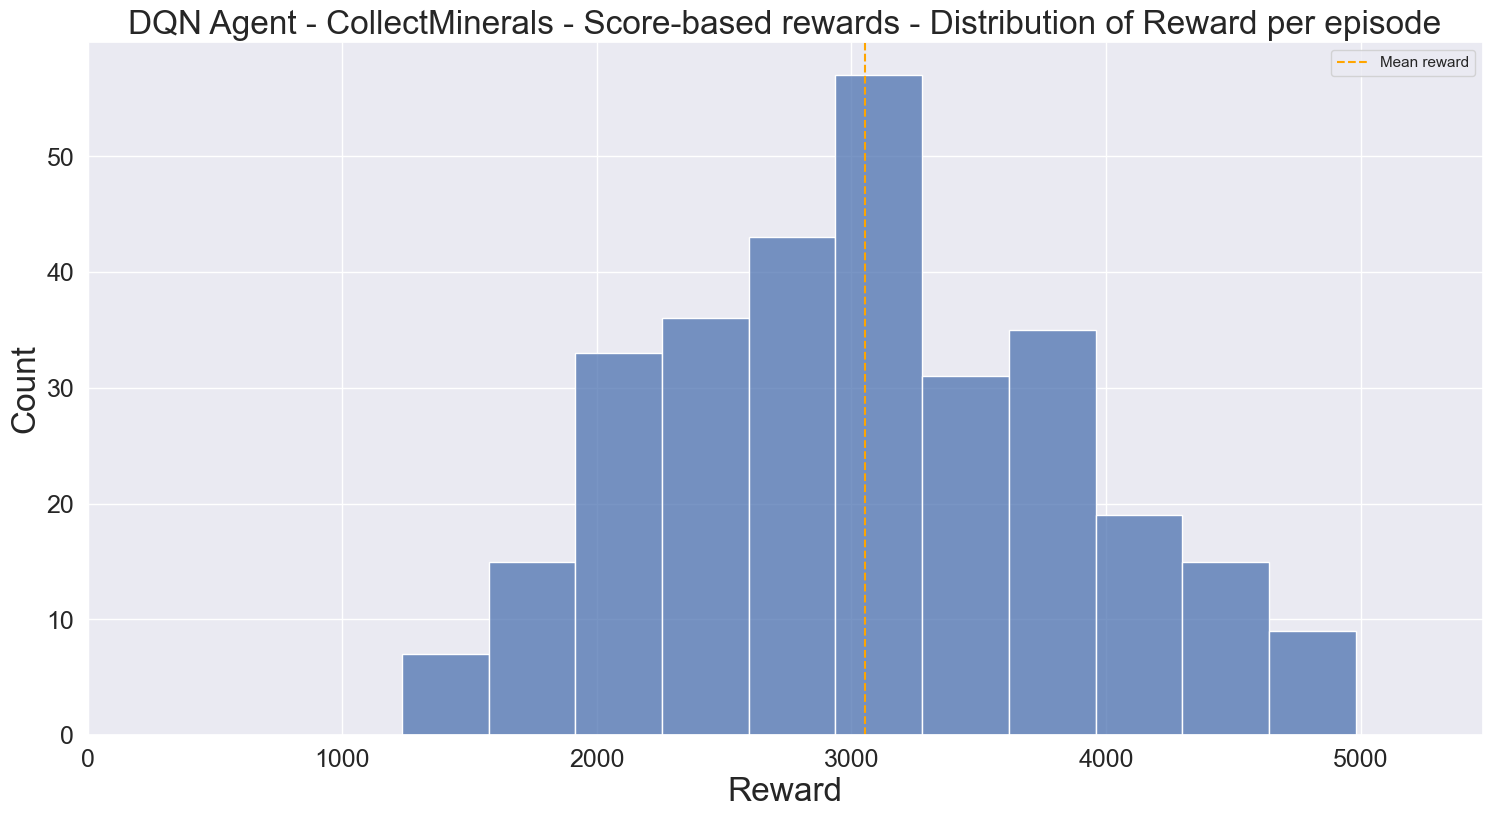

In [610]:
plot_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\3887461656.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


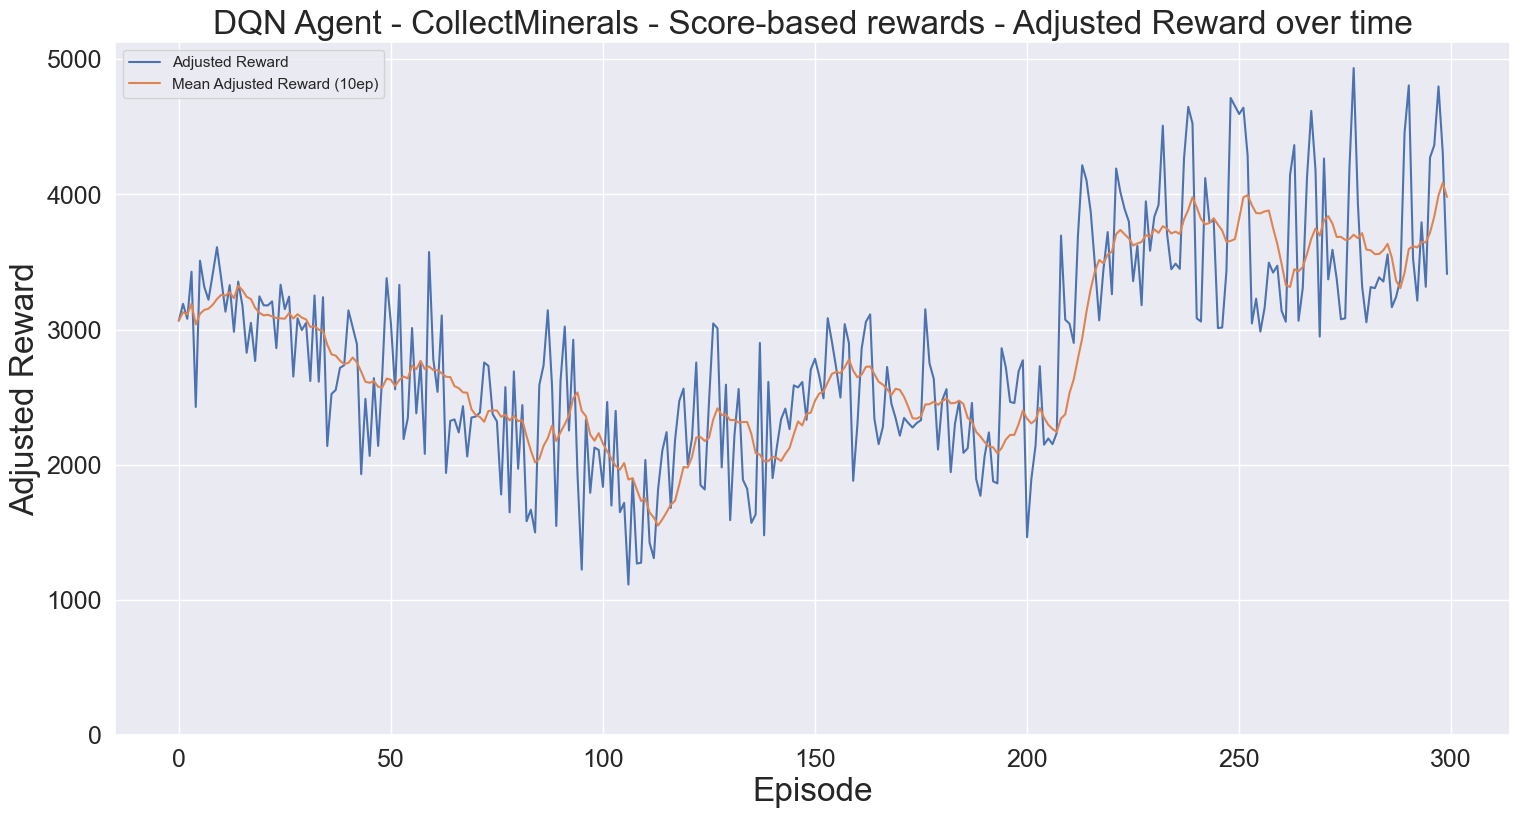

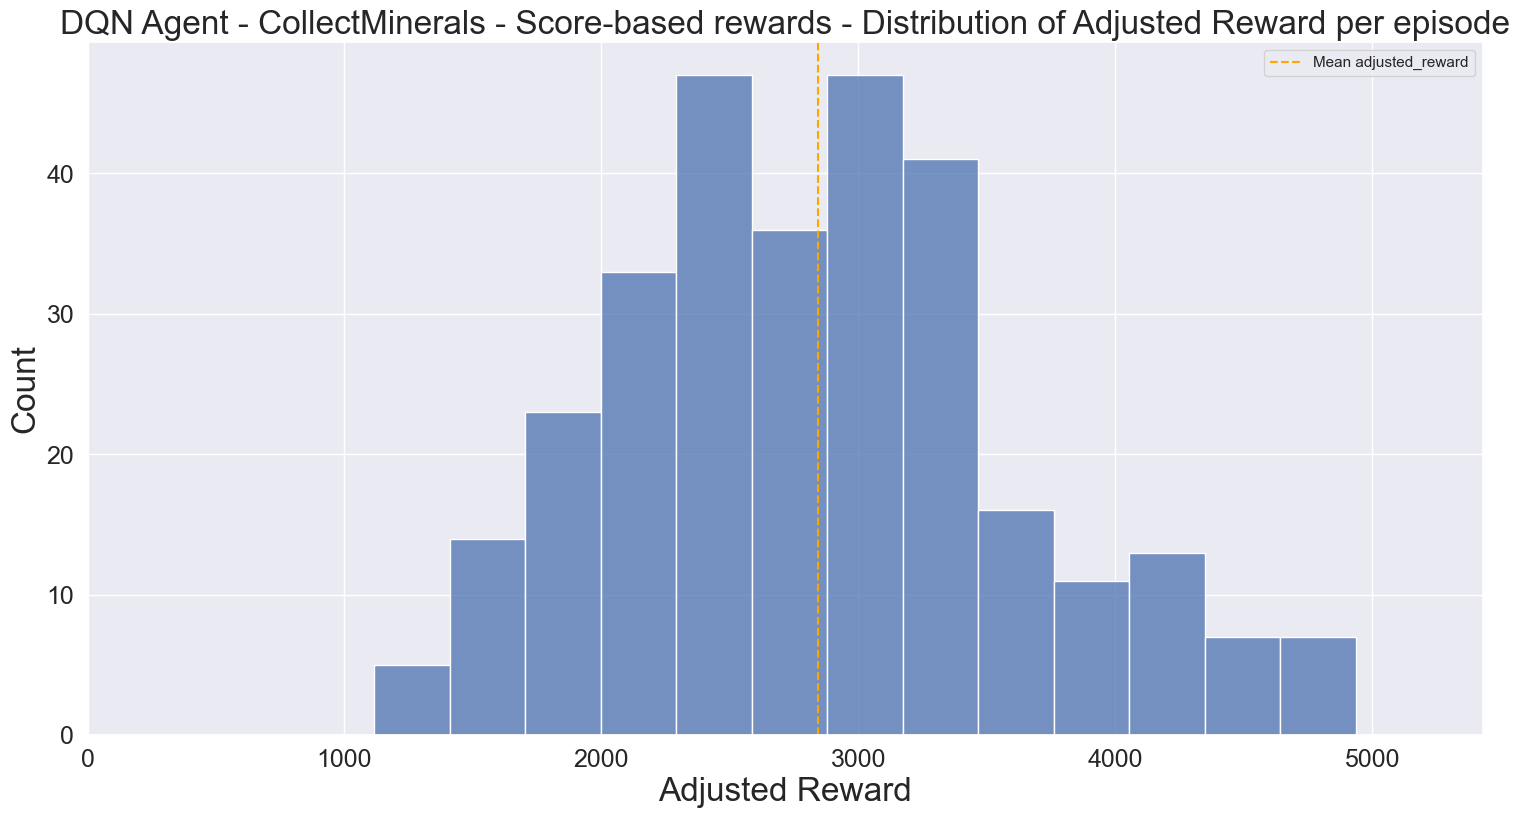

In [611]:
plot_adjusted_rewards(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\3887461656.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


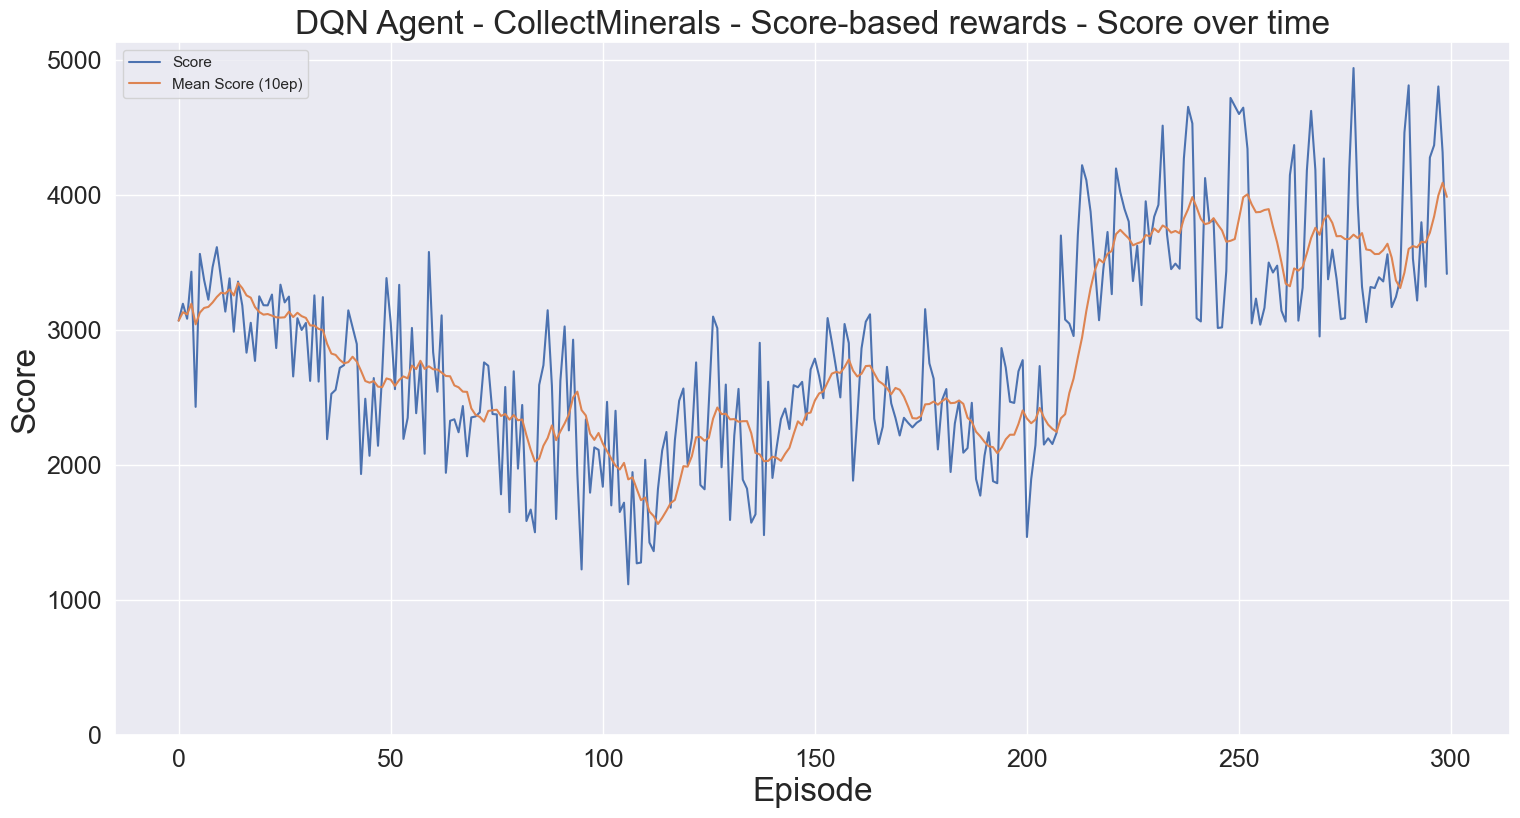

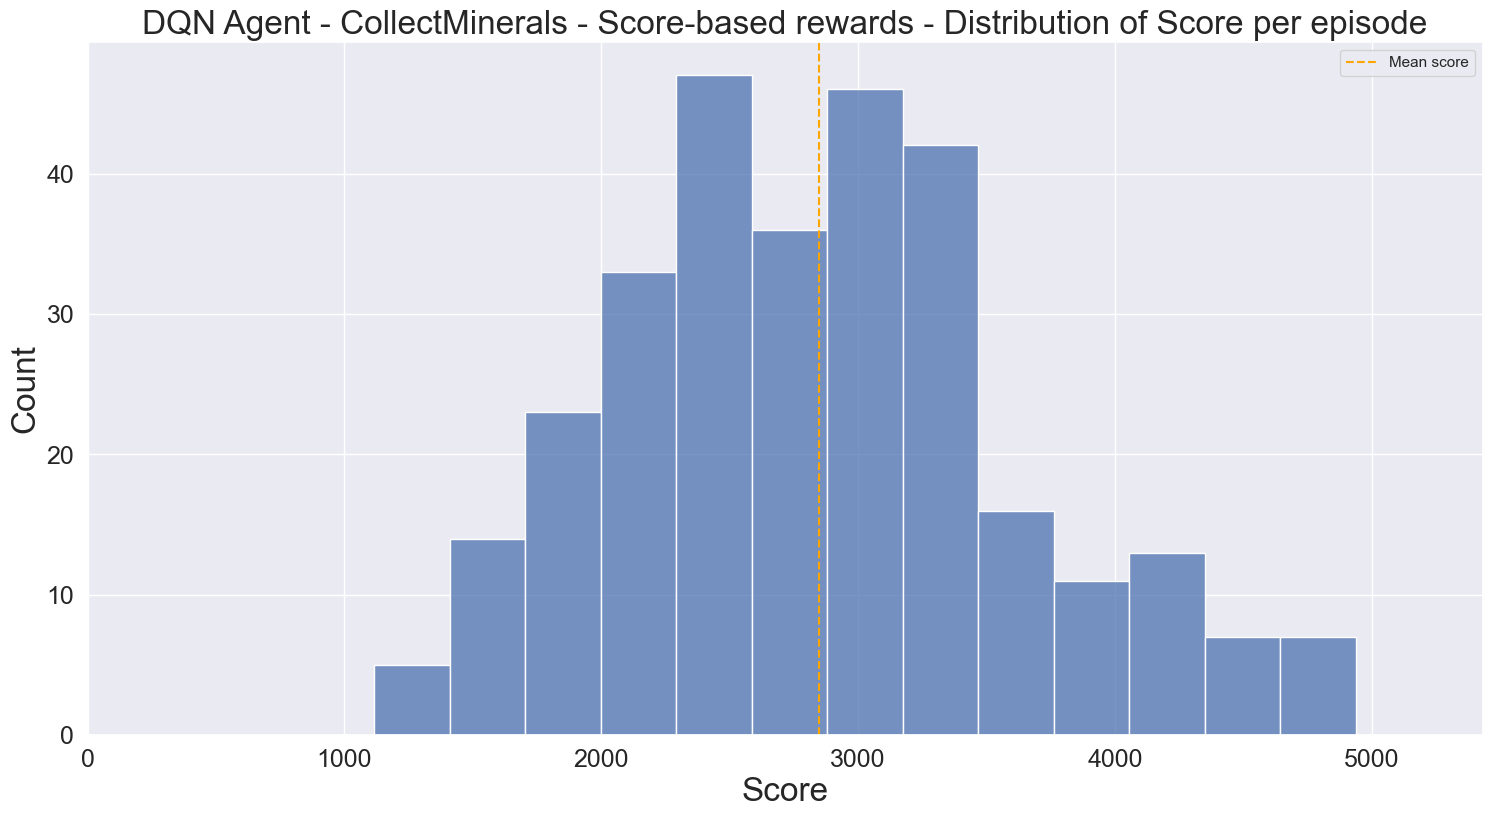

In [612]:
plot_scores(**plot_args) ;

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\3887461656.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


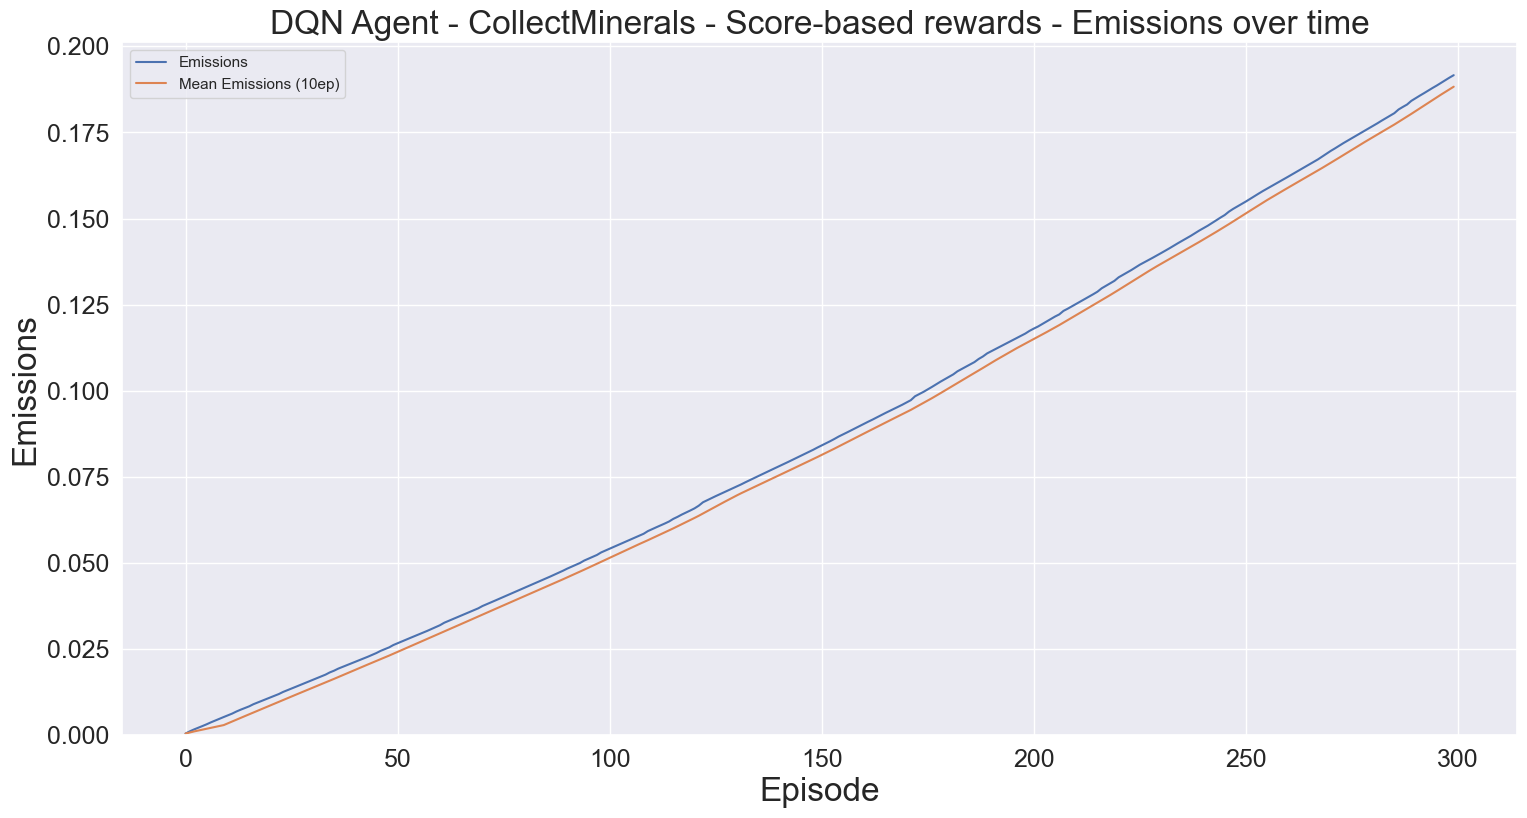

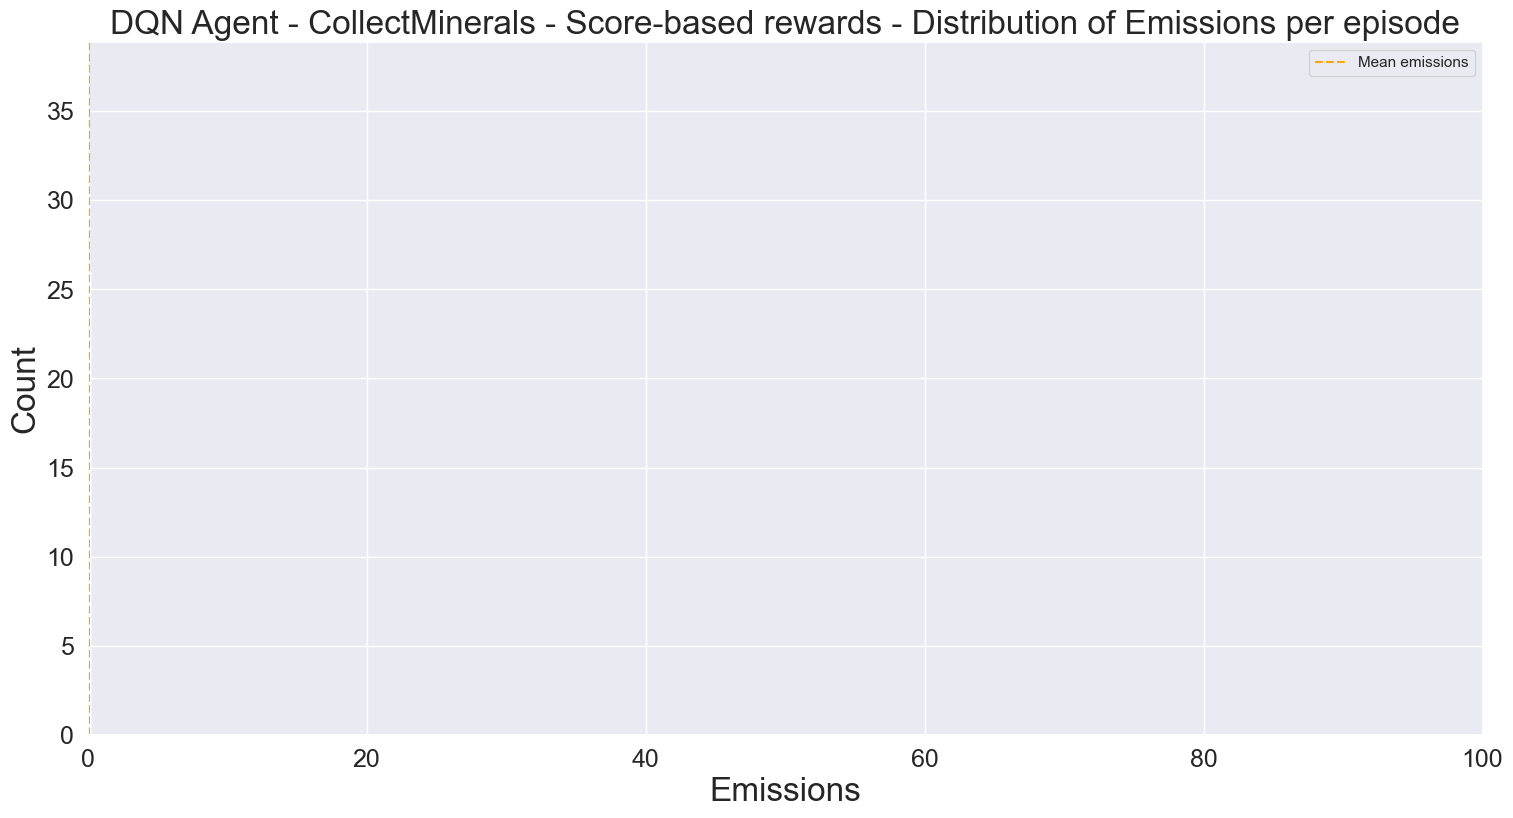

In [613]:
plot_emissions(**plot_args) ;

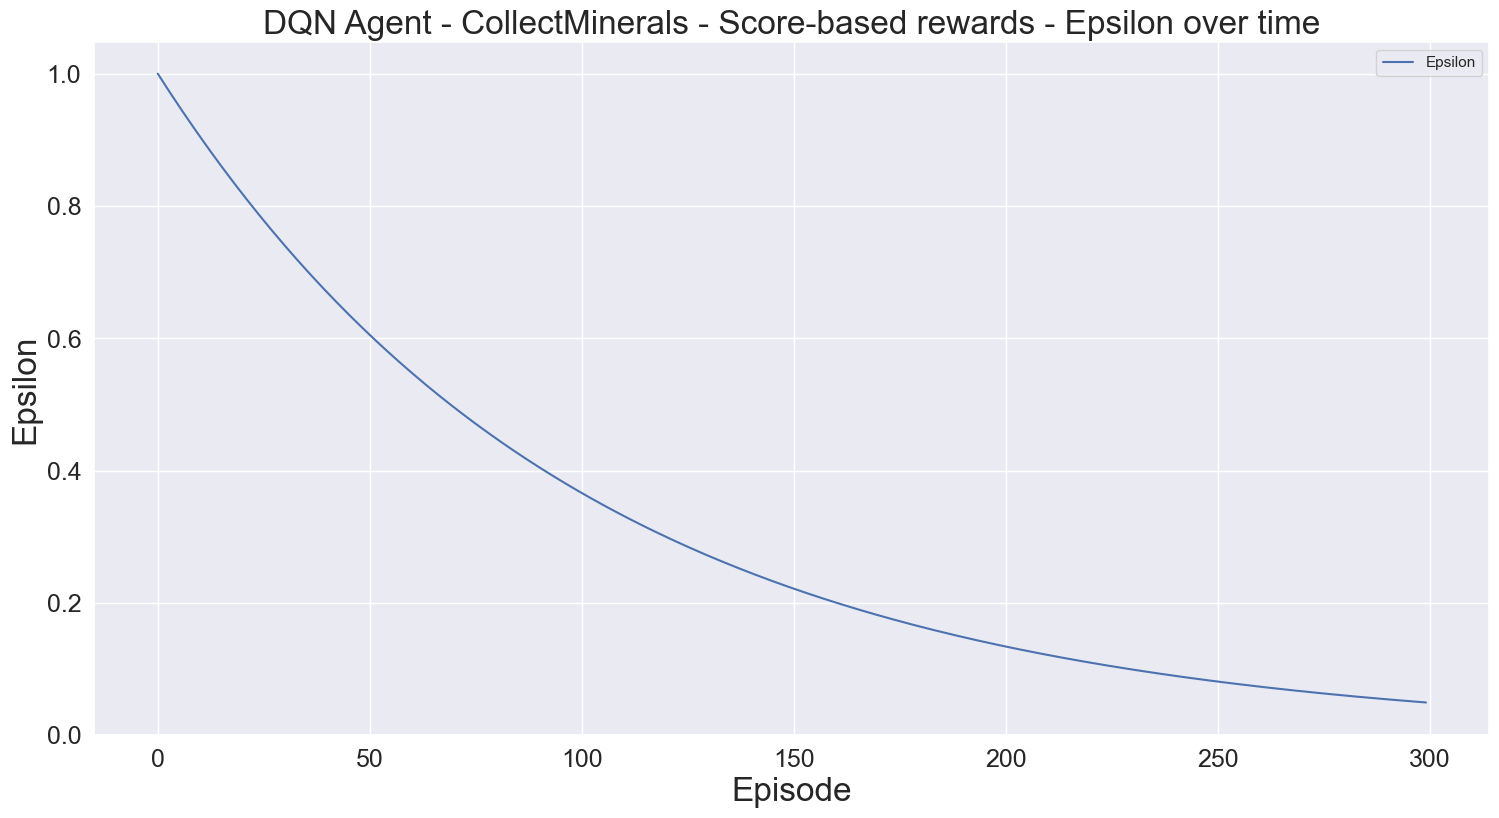

In [614]:
plot_epsilon(**plot_args) ;

0.030038275709658526


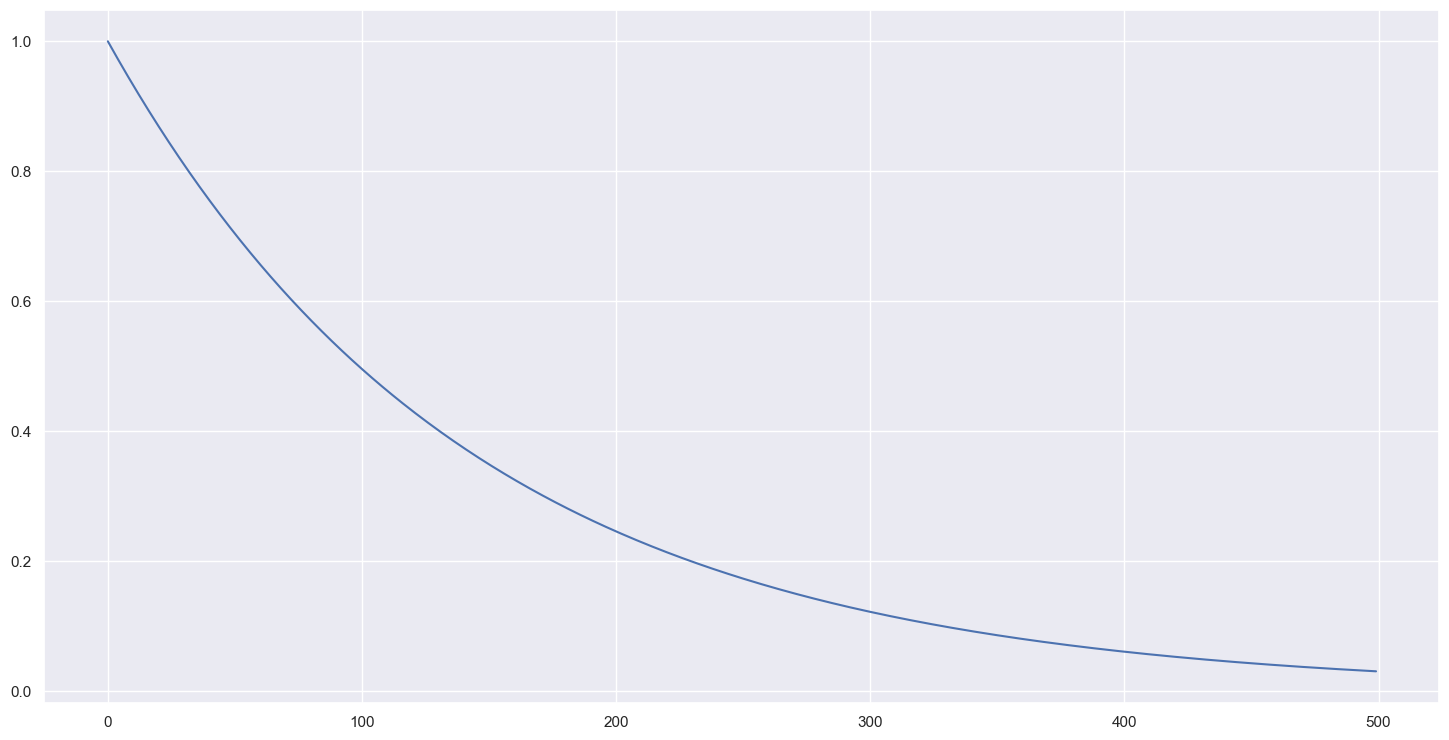

In [629]:
start_eps = 1
decay = 0.993
epsilon = start_eps
epsilons = []

episodes = 500
for i in range(episodes):
    epsilons.append(epsilon)
    epsilon *= decay
    

print(epsilons[-1])
sns.lineplot(x=list(range(episodes)), y=epsilons) ;

### Build Marines

Total episodes: 24
Total burnin episodes: 24
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 0
Unique maps in episode stats:  ['BuildMarines']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_rewards_10ep", palette=["orange"], label="Mean Reward (10ep)")


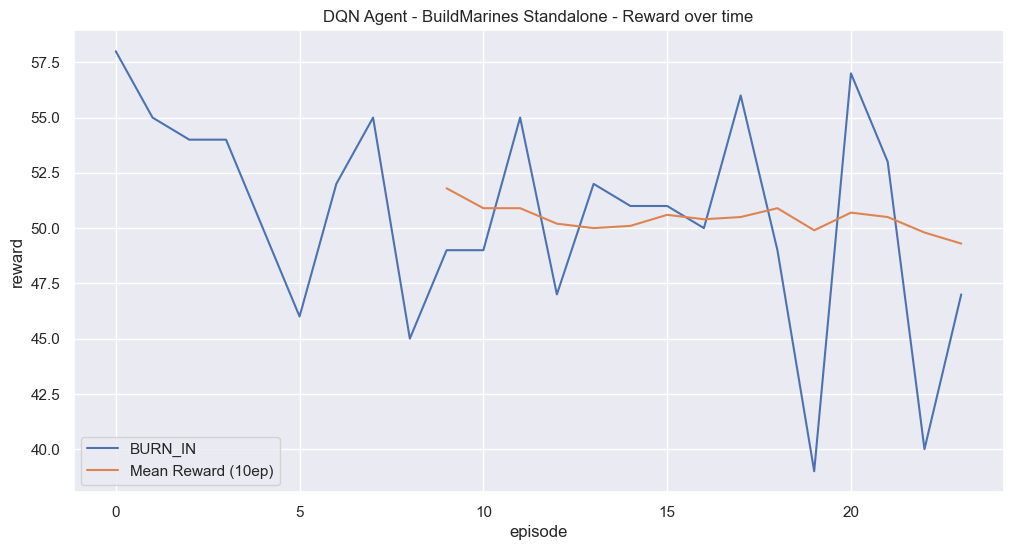

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_adjusted_rewards_10ep", palette=["orange"], label="Mean Adjusted Reward (10ep)")


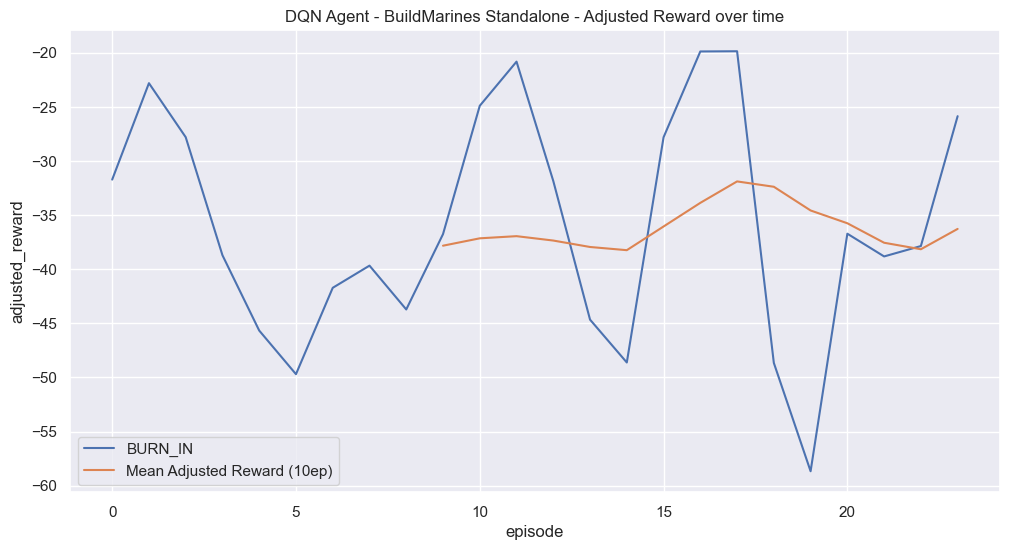

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_scores_10ep", palette=["orange"], label="Mean Score (10ep)")


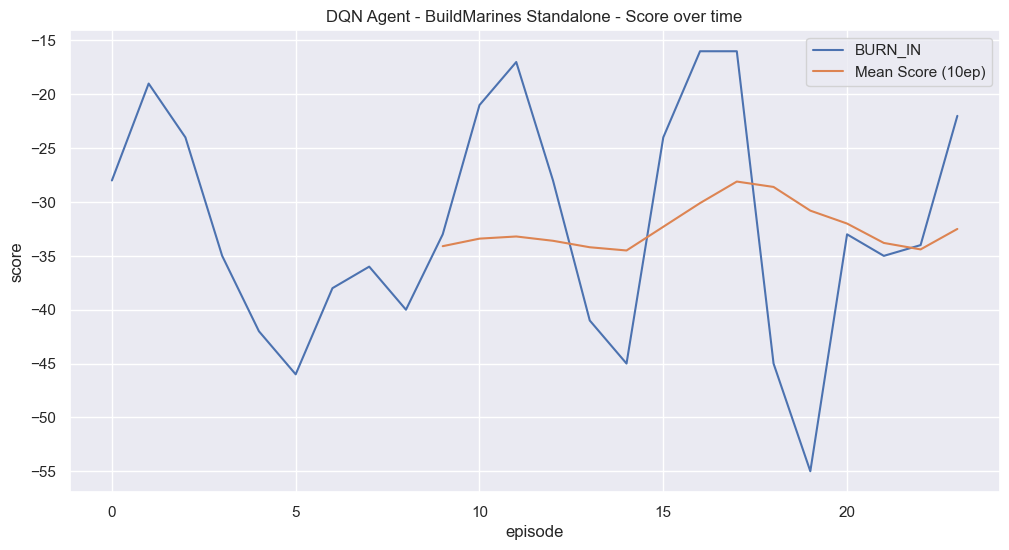

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_loss_10ep", palette=["orange"], label="Mean Loss (10ep)")


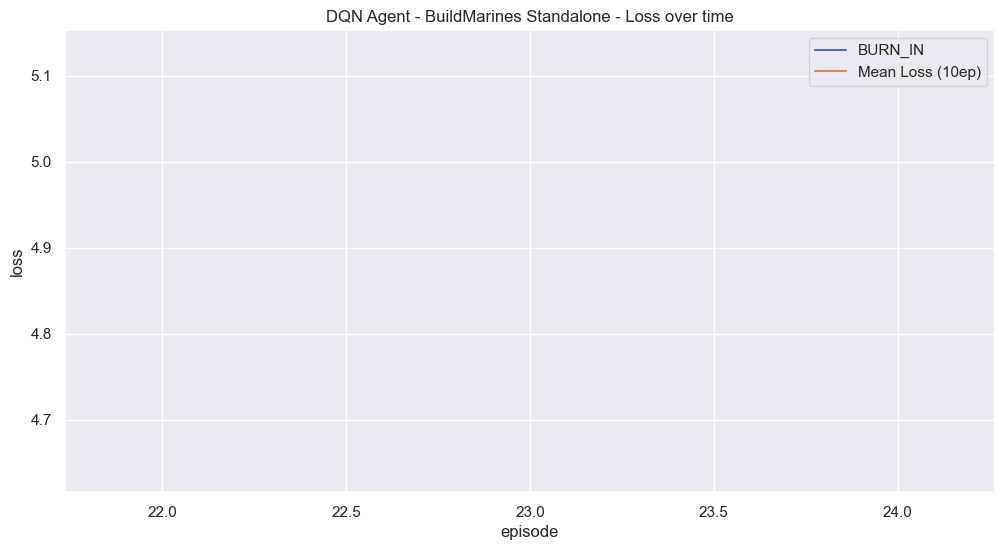

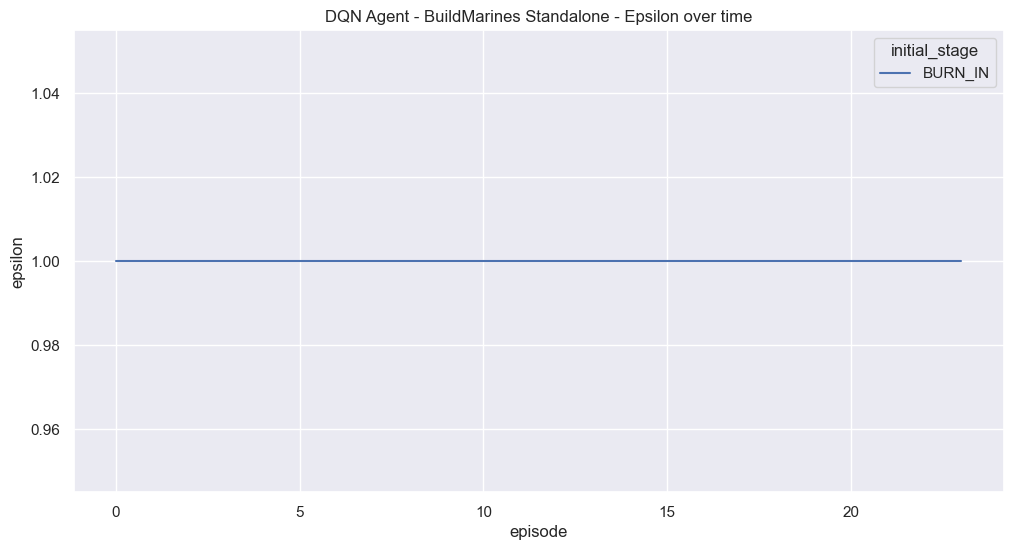

map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
0  BuildMarines    58.0           -31.72    451      1.0     []   0.001341   
1  BuildMarines    55.0           -22.81    451      1.0     []   0.003217   
2  BuildMarines    54.0           -27.80    451      1.0     []   0.005118   
3  BuildMarines    54.0           -38.71    451      1.0     []   0.007044   
4  BuildMarines    50.0           -45.67    451      1.0     []   0.008944   

   score  is_burnin  is_training  ...  initial_stage  final_stage episode  \
0  -28.0       True        False  ...        BURN_IN      BURN_IN       0   
1  -19.0       True        False  ...        BURN_IN      BURN_IN       1   
2  -24.0       True        False  ...        BURN_IN      BURN_IN       2   
3  -35.0       True        False  ...        BURN_IN      BURN_IN       3   
4  -42.0       True        False  ...        BURN_IN      BURN_IN       4   

  loss                              invalid_action_counts  \
0  NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...            NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...            NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...            NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...            NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...            NaN   

  mean_rewards_10ep  mean_adjusted_rewards_10ep  mean_scores_10ep  
0               NaN                         NaN               NaN  
1               NaN                         NaN               NaN  
2               NaN                         NaN               NaN  
3               NaN                         NaN               NaN  
4               NaN                         NaN               NaN  

[5 rows x 22 columns]

In [118]:
build_marines_model_id ="build_marines"
episode_stats, agent_stats, aggregated_stats = load_stats(build_marines_model_id, model_path=single_dqn_models_path, model_name="DQN Agent - BuildMarines Standalone")
episode_stats.head()

### Defeat Zerglings and banelings

Total episodes: 314
Total burnin episodes: 314
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 0
Unique maps in episode stats:  ['DefeatZerglingsAndBanelings']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_rewards_10ep", palette=["orange"], label="Mean Reward (10ep)")


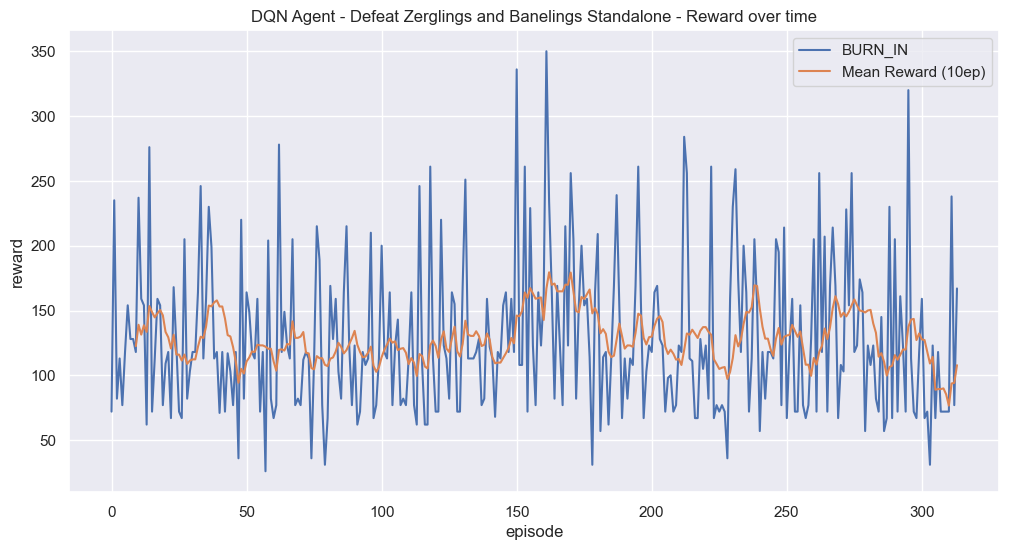

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_adjusted_rewards_10ep", palette=["orange"], label="Mean Adjusted Reward (10ep)")


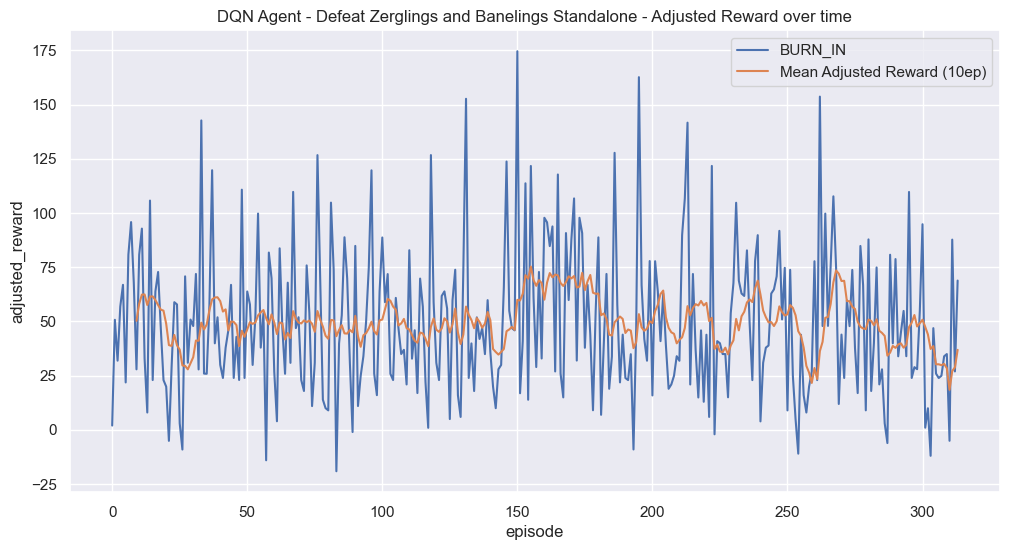

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_scores_10ep", palette=["orange"], label="Mean Score (10ep)")


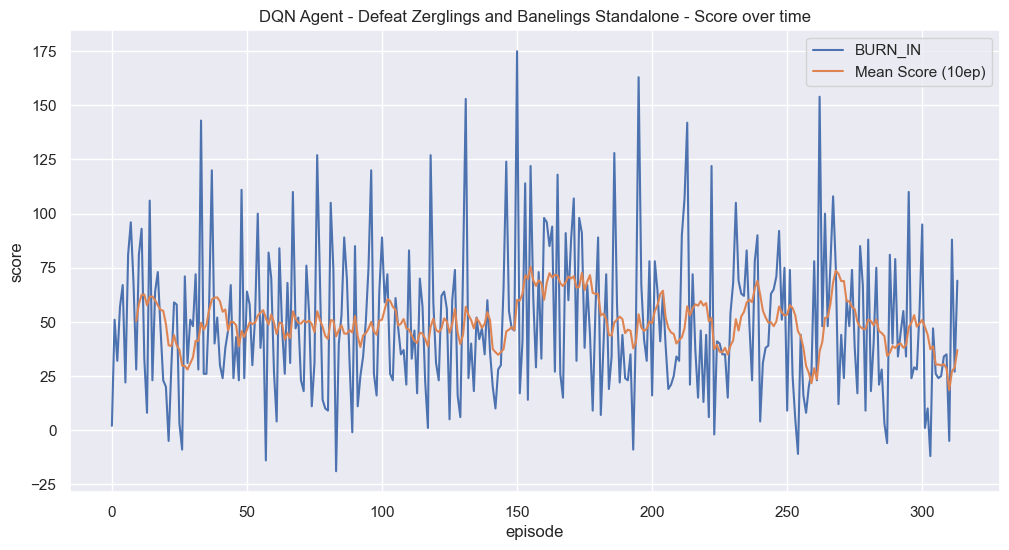

C:\Users\alghi\AppData\Local\Temp\ipykernel_32840\451922844.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y="mean_loss_10ep", palette=["orange"], label="Mean Loss (10ep)")


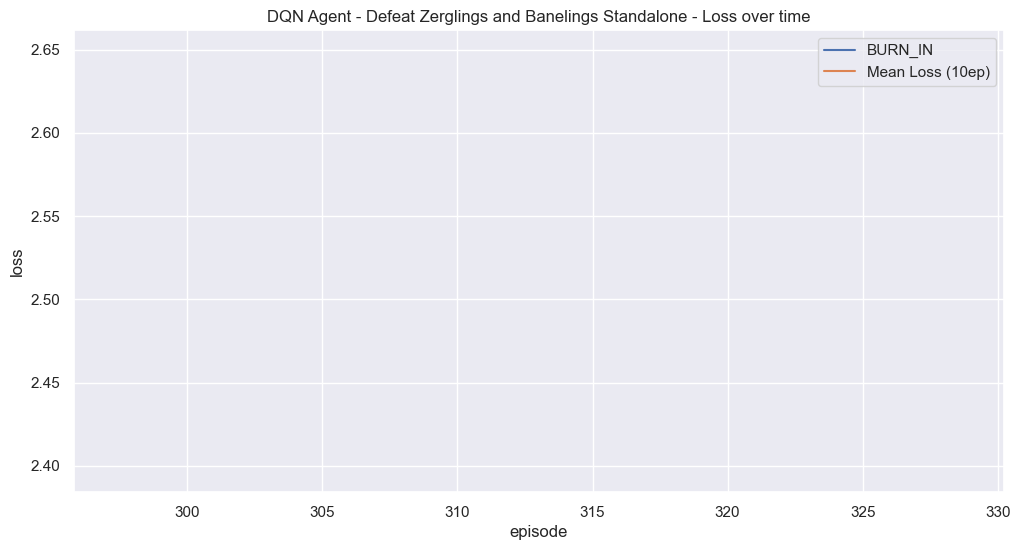

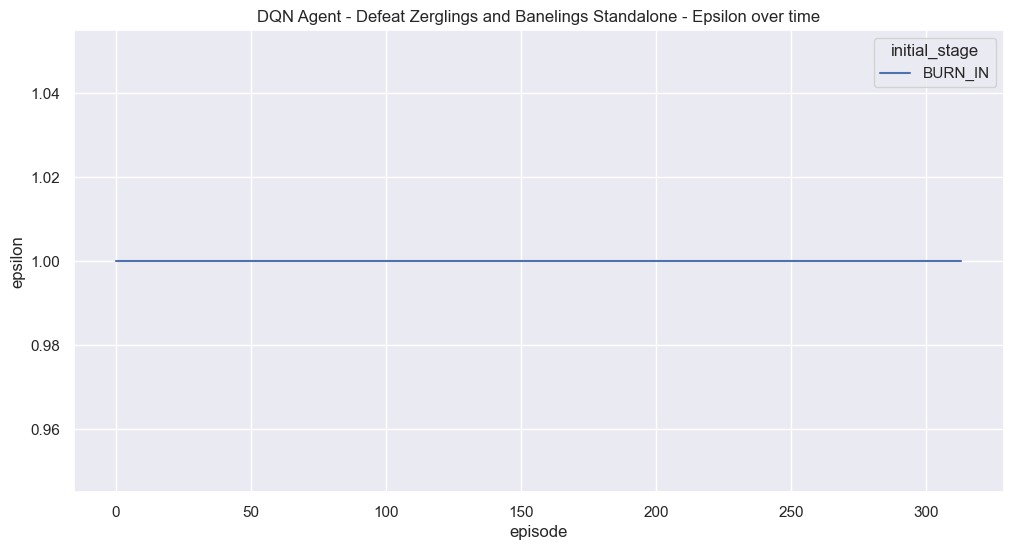

map_name  reward  adjusted_reward  steps  epsilon  \
0  DefeatZerglingsAndBanelings    72.0             1.90     26      1.0   
1  DefeatZerglingsAndBanelings   235.0            50.71     61      1.0   
2  DefeatZerglingsAndBanelings    82.0            31.85     27      1.0   
3  DefeatZerglingsAndBanelings   113.0            56.86     27      1.0   
4  DefeatZerglingsAndBanelings    77.0            66.85     22      1.0   

  losses  emissions  score  is_burnin  is_training  ...  initial_stage  \
0     []   0.000085    2.0       True        False  ...        BURN_IN   
1     []   0.000321   51.0       True        False  ...        BURN_IN   
2     []   0.000231   32.0       True        False  ...        BURN_IN   
3     []   0.000306   57.0       True        False  ...        BURN_IN   
4     []   0.000375   67.0       True        False  ...        BURN_IN   

   final_stage episode loss  \
0      BURN_IN       0  NaN   
1      BURN_IN       1  NaN   
2      BURN_IN       2  NaN   
3      BURN_IN       3  NaN   
4      BURN_IN       4  NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts mean_loss_10ep  \
0  {'ATTACK_WITH_SINGLE_UNIT': 7, 'BUILD_BARRACKS...            NaN   
1  {'ATTACK_WITH_SINGLE_UNIT': 24, 'BUILD_BARRACK...            NaN   
2  {'ATTACK_WITH_SINGLE_UNIT': 7, 'BUILD_BARRACKS...            NaN   
3  {'ATTACK_WITH_SINGLE_UNIT': 8, 'BUILD_BARRACKS...            NaN   
4  {'ATTACK_WITH_SINGLE_UNIT': 9, 'BUILD_BARRACKS...            NaN   

  mean_rewards_10ep  mean_adjusted_rewards_10ep  mean_scores_10ep  
0               NaN                         NaN               NaN  
1               NaN                         NaN               NaN  
2               NaN                         NaN               NaN  
3               NaN                         NaN               NaN  
4               NaN                         NaN               NaN  

[5 rows x 22 columns]

In [119]:
defeat_zerglings_model_id ="defeat_zerglings_and_banelings"
episode_stats, agent_stats, aggregated_stats = load_stats(defeat_zerglings_model_id, model_path=single_dqn_models_path, model_name="DQN Agent - Defeat Zerglings and Banelings Standalone")
episode_stats.head()

Total episodes: 68
Total burnin episodes: 48
Total random mode episodes: 0
Total episodes: 20
Total exploit episodes: 0
Unique maps in episode stats:  ['CollectMineralsAndGas']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


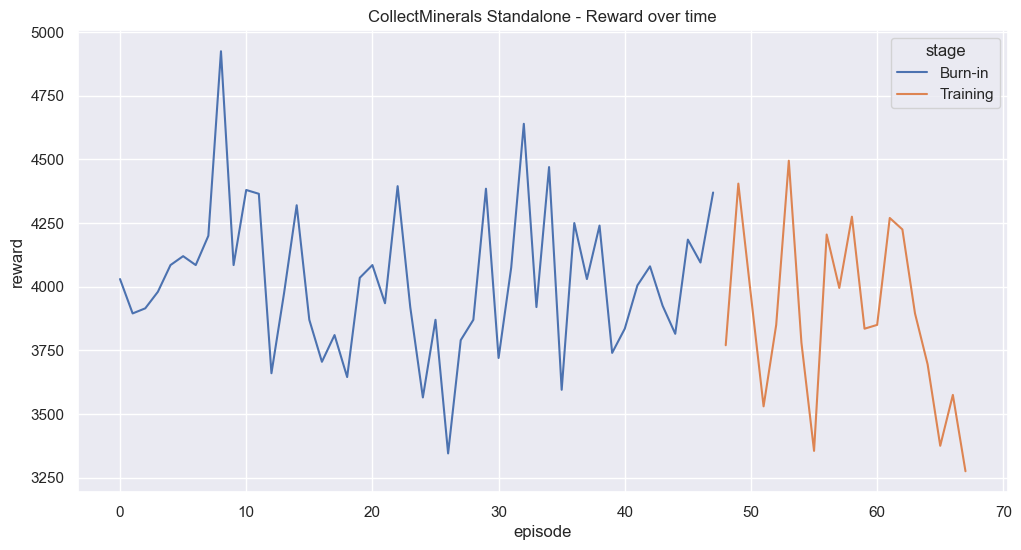

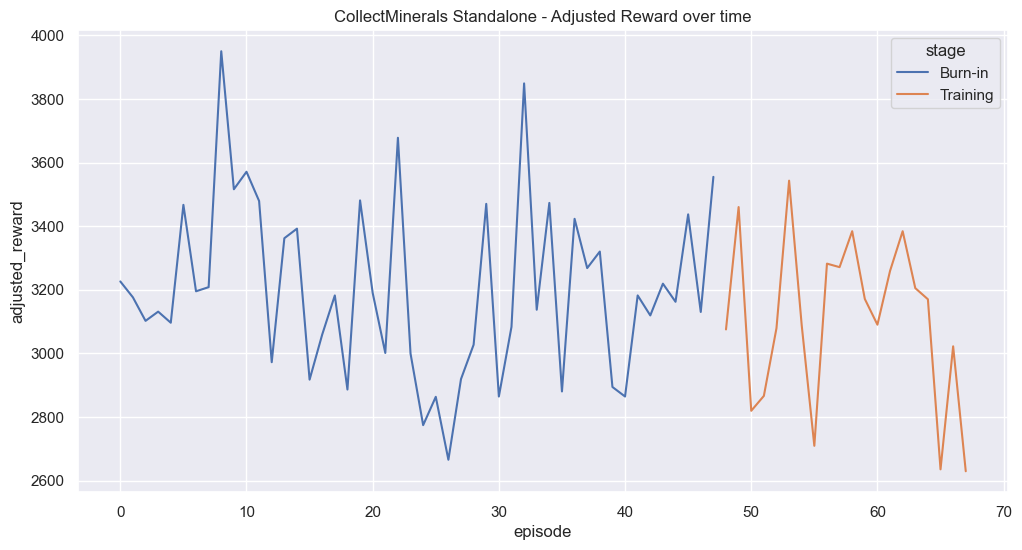

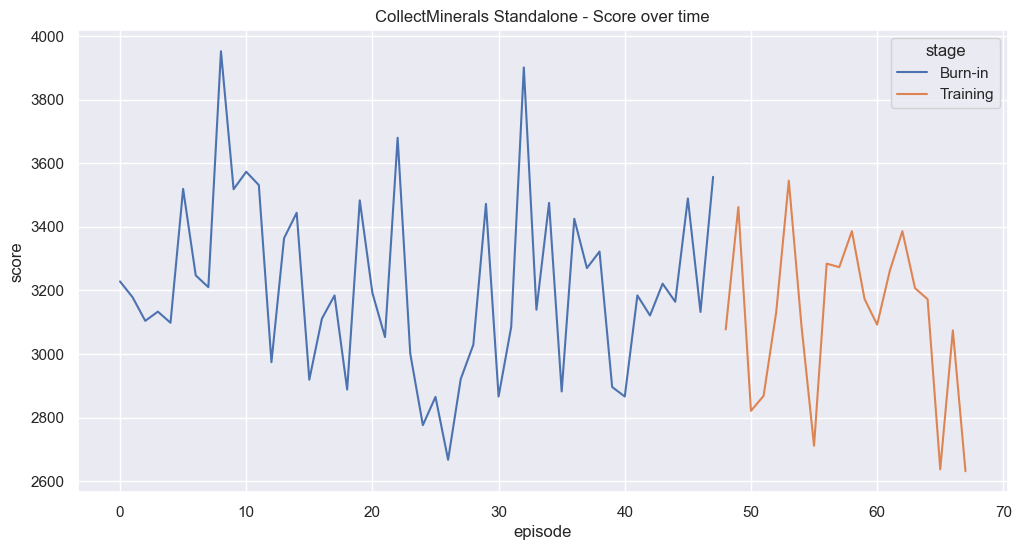

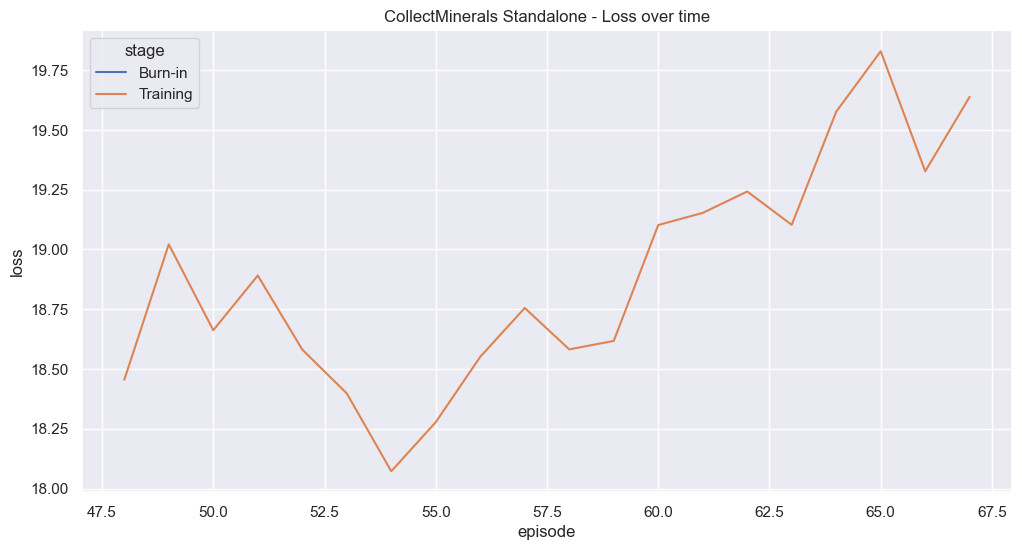

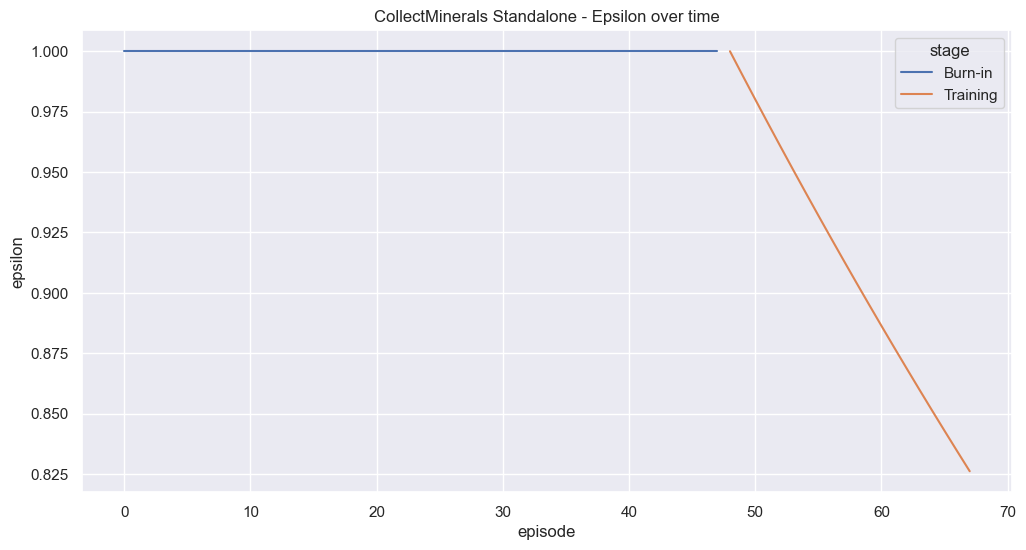

map_name  reward  adjusted_reward  steps  epsilon losses  \
0  CollectMineralsAndGas  4030.0          3226.31    211      1.0     []   
1  CollectMineralsAndGas  3895.0          3176.26    211      1.0     []   
2  CollectMineralsAndGas  3915.0          3102.30    211      1.0     []   
3  CollectMineralsAndGas  3980.0          3131.31    211      1.0     []   
4  CollectMineralsAndGas  4085.0          3096.41    211      1.0     []   

   emissions   score  is_burnin  is_training  is_exploit  is_random_mode  \
0   0.000435  3228.0       True        False       False           False   
1   0.000881  3178.0       True        False       False           False   
2   0.001301  3104.0       True        False       False           False   
3   0.001731  3133.0       True        False       False           False   
4   0.002170  3098.0       True        False       False           False   

  initial_stage final_stage  episode  loss  \
0       burn-in     burn-in        0   NaN   
1       burn-in     burn-in        1   NaN   
2       burn-in     burn-in        2   NaN   
3       burn-in     burn-in        3   NaN   
4       burn-in     burn-in        4   NaN   

                               invalid_action_counts  \
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts    stage  
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in

In [62]:
test_collect_minerals_model_id = f"test_{base_model_id}_collect_minerals"
episode_stats, agent_stats, aggregated_stats = load_stats(test_collect_minerals_model_id, model_name="CollectMinerals Standalone")
episode_stats.head()

Total episodes: 548
Total burnin episodes: 48
Total random mode episodes: 0
Total episodes: 500
Total exploit episodes: 0
Unique maps in episode stats:  ['CollectMineralsAndGas']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


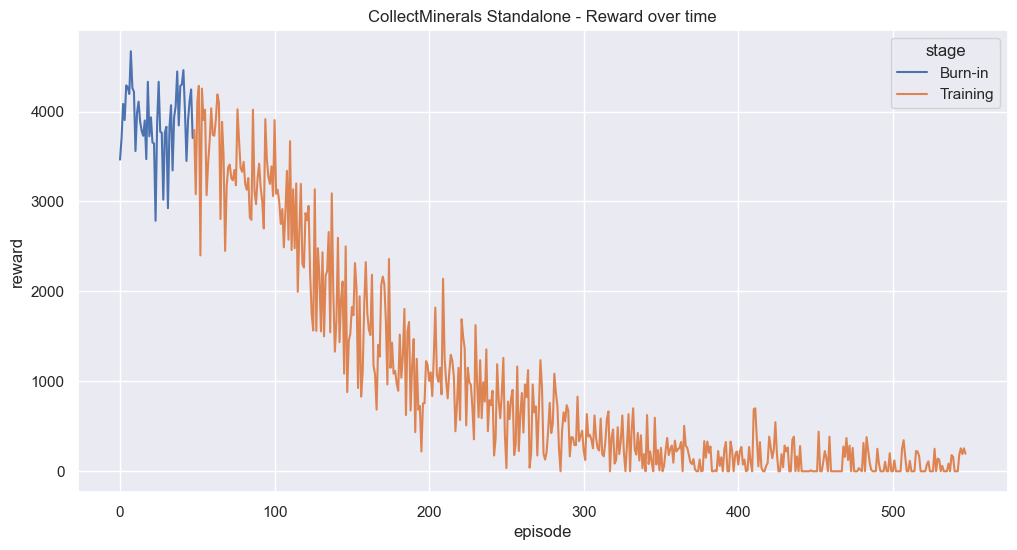

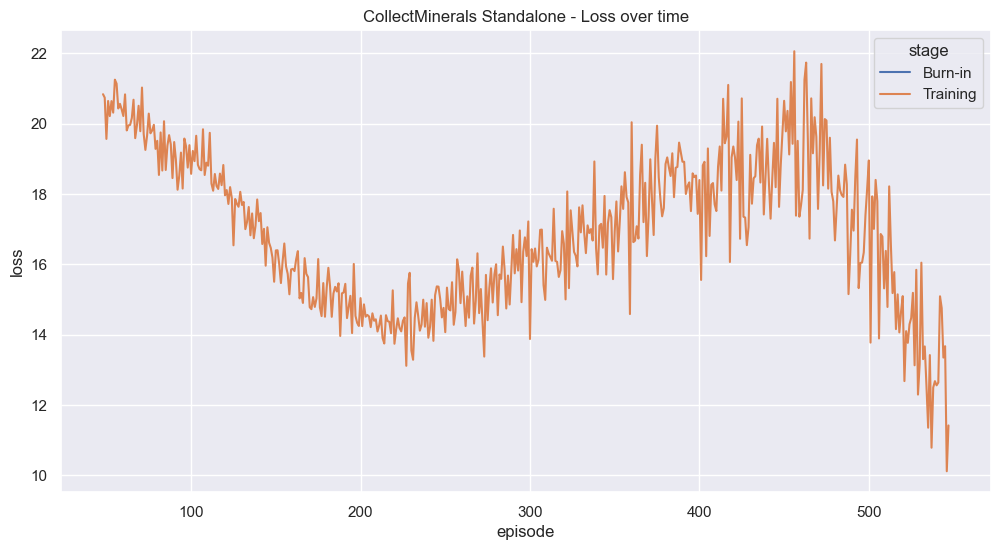

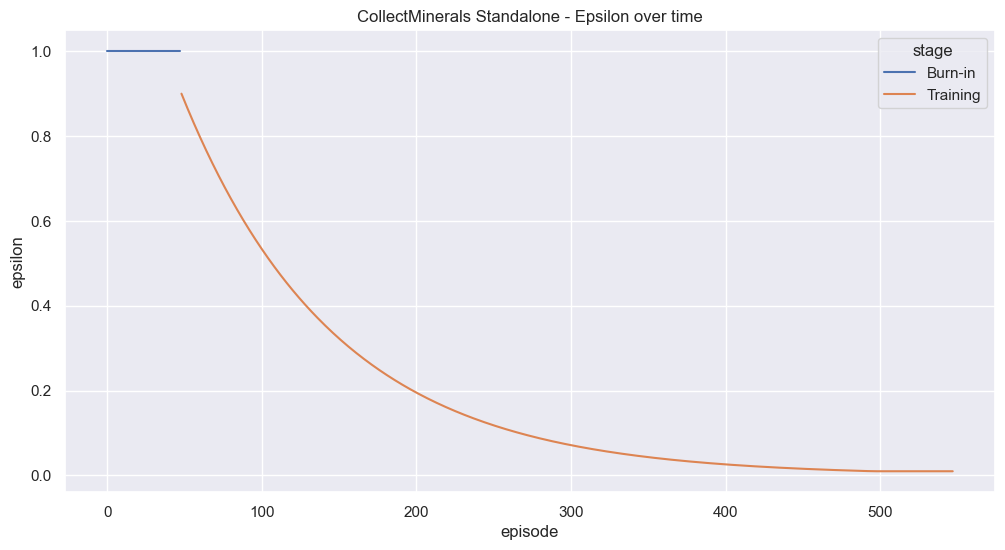

map_name  reward  steps  epsilon losses  emissions  is_burnin  \
0  CollectMineralsAndGas  3465.0    211      1.0     []   0.000488       True   
1  CollectMineralsAndGas  3705.0    211      1.0     []   0.000977       True   
2  CollectMineralsAndGas  4085.0    211      1.0     []   0.001458       True   
3  CollectMineralsAndGas  3905.0    211      1.0     []   0.001917       True   
4  CollectMineralsAndGas  4290.0    211      1.0     []   0.002383       True   

   is_training  is_exploit  is_random_mode initial_stage final_stage  episode  \
0        False       False           False       burn-in     burn-in        0   
1        False       False           False       burn-in     burn-in        1   
2        False       False           False       burn-in     burn-in        2   
3        False       False           False       burn-in     burn-in        3   
4        False       False           False       burn-in     burn-in        4   

   loss                              invalid_action_counts  \
0   NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
1   NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
2   NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
3   NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   
4   NaN  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...   

                                 valid_action_counts    stage  
0  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
1  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
2  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
3  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in  
4  {'ATTACK_WITH_SINGLE_UNIT': 0, 'BUILD_BARRACKS...  Burn-in

In [57]:
episode_stats, agent_stats, aggregated_stats = load_stats(collect_minerals_model_id, model_name="CollectMinerals Standalone")
episode_stats.head()

Total episodes: 300
Total burnin episodes: 71
Total random mode episodes: 0
Total episodes: 229
Total exploit episodes: 0
Unique maps in episode stats:  ['CollectMineralsAndGas']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


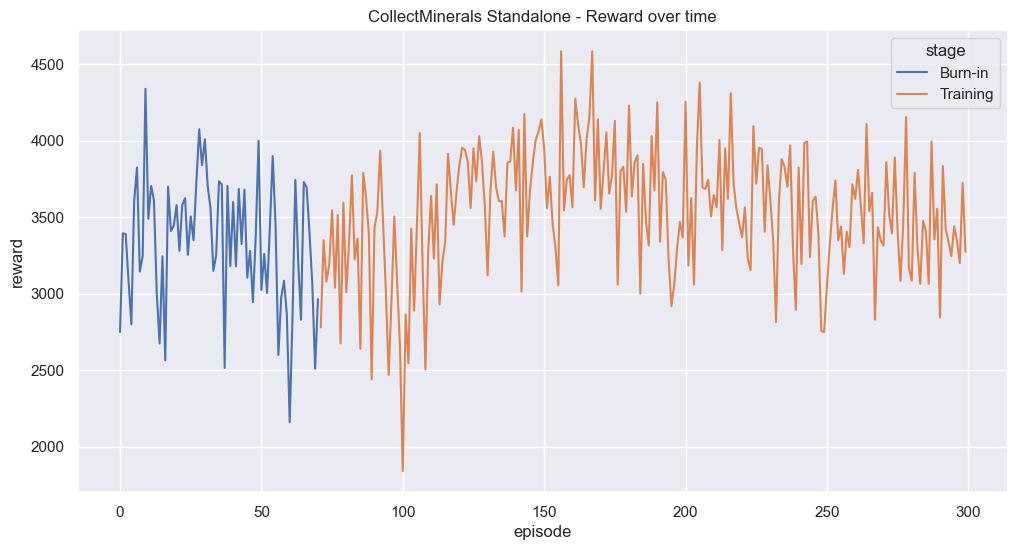

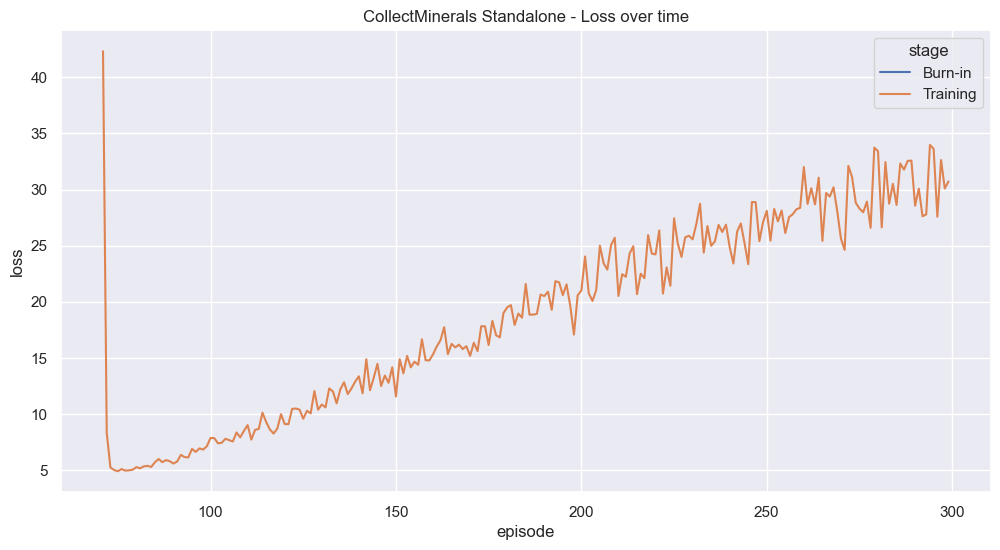

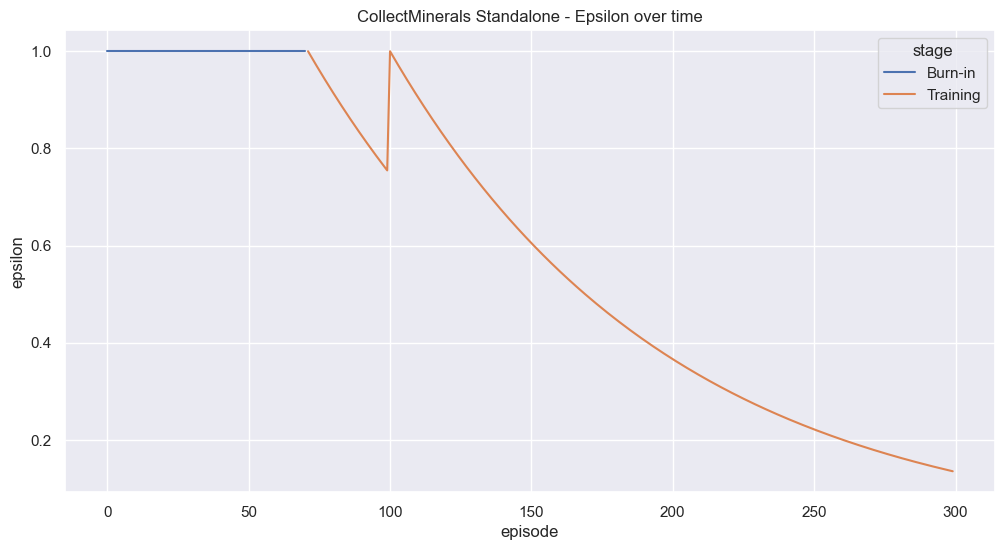

map_name  reward  steps  epsilon losses  emissions  score  \
0  CollectMineralsAndGas  2750.0    141      1.0     []   0.000221      0   
1  CollectMineralsAndGas  3395.0    141      1.0     []   0.000463      0   
2  CollectMineralsAndGas  3390.0    141      1.0     []   0.000711      0   
3  CollectMineralsAndGas  3090.0    141      1.0     []   0.000957      0   
4  CollectMineralsAndGas  2800.0    141      1.0     []   0.001202      0   

   is_training  is_exploit  is_random_mode  episode    stage  loss  
0        False       False           False        0  Burn-in   NaN  
1        False       False           False        1  Burn-in   NaN  
2        False       False           False        2  Burn-in   NaN  
3        False       False           False        3  Burn-in   NaN  
4        False       False           False        4  Burn-in   NaN

In [49]:
episode_stats, agent_stats, aggregated_stats = load_stats(collect_minerals_model_id, model_name="CollectMinerals Standalone")
episode_stats.head()

In [38]:
agent_stats.head(10)

map_name  step_count  episode_count  total_reward  \
0  CollectMineralsAndGas       42300            300     1045710.0   

   total_score  total_emissions  
0            0        10.252701

In [39]:
aggregated_stats.head(10)

map_name                                            rewards  \
0  CollectMineralsAndGas  [2750.0, 3395.0, 3390.0, 3090.0, 2800.0, 3605....   

                                              scores  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            epsilons  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                              losses  \
0  [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...   

                                               steps  \
0  [141, 141, 141, 141, 141, 141, 141, 141, 141, ...   

                                           emissions  max_reward  max_score  
0  [0.00022097196751884513, 0.0004629719376525588...      4585.0          0

# Build marines

Total episodes: 300
Total burnin episodes: 33
Total random mode episodes: 0
Total episodes: 267
Total exploit episodes: 0
Unique maps in episode stats:  ['BuildMarines']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


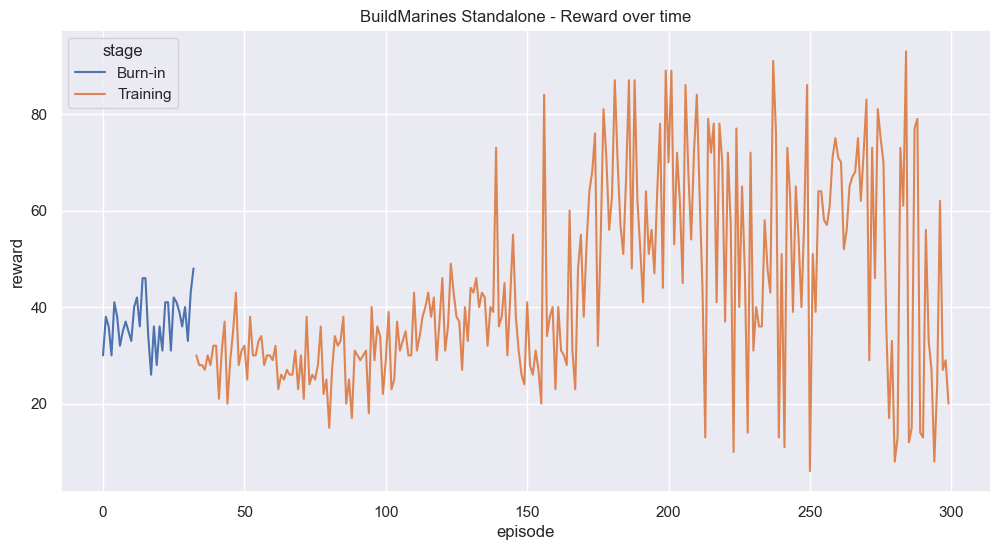

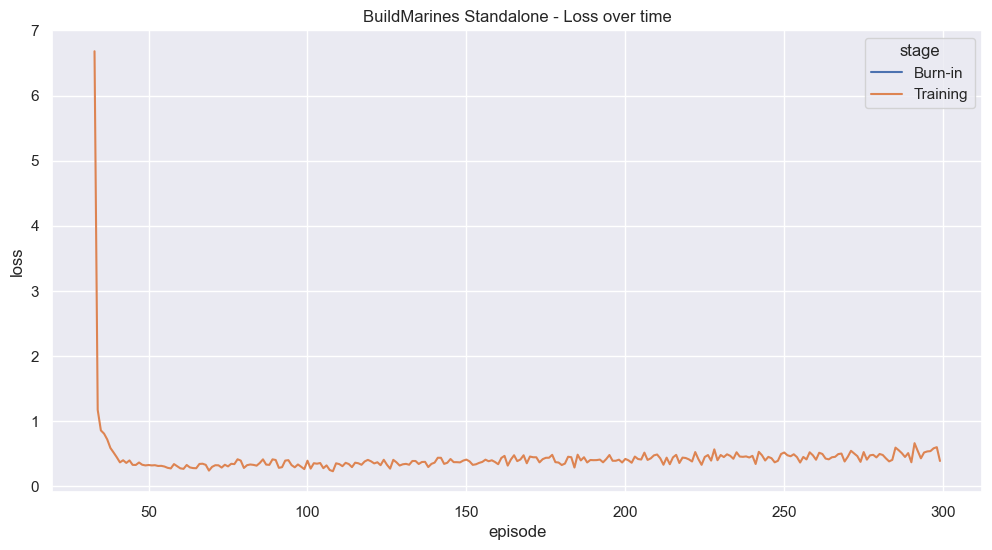

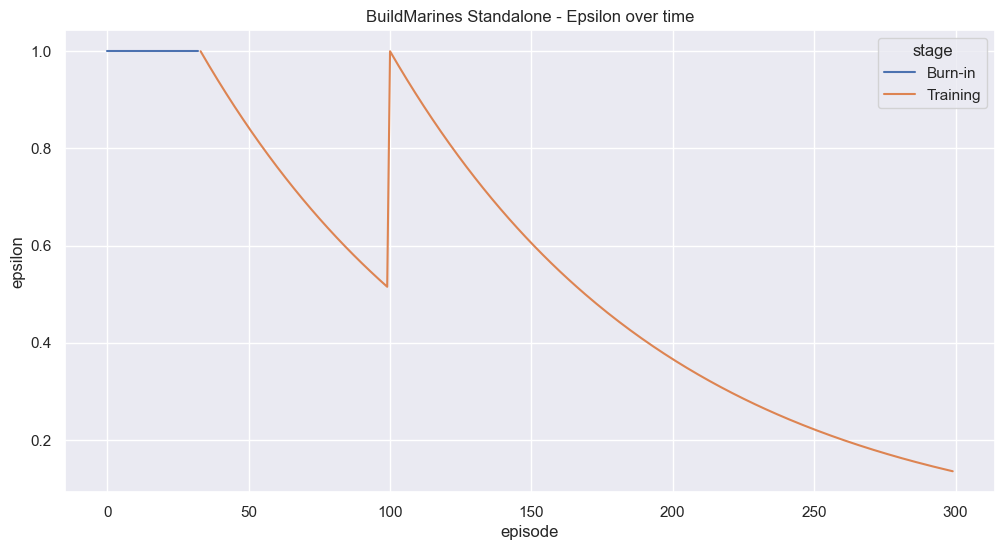

map_name  reward  steps  epsilon losses  emissions  score  is_training  \
0  BuildMarines    30.0    301      1.0     []   0.000702      0        False   
1  BuildMarines    38.0    301      1.0     []   0.001689      0        False   
2  BuildMarines    36.0    301      1.0     []   0.002645      0        False   
3  BuildMarines    30.0    301      1.0     []   0.003642      0        False   
4  BuildMarines    41.0    301      1.0     []   0.004592      0        False   

   is_exploit  is_random_mode  episode    stage  loss  
0       False           False        0  Burn-in   NaN  
1       False           False        1  Burn-in   NaN  
2       False           False        2  Burn-in   NaN  
3       False           False        3  Burn-in   NaN  
4       False           False        4  Burn-in   NaN

In [50]:
episode_stats, agent_stats, aggregated_stats = load_stats(build_marines_model_id, model_name="BuildMarines Standalone")
episode_stats.head()

# Defeat Roaches

Total episodes: 300
Total burnin episodes: 300
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 0
Unique maps in episode stats:  ['DefeatRoaches']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


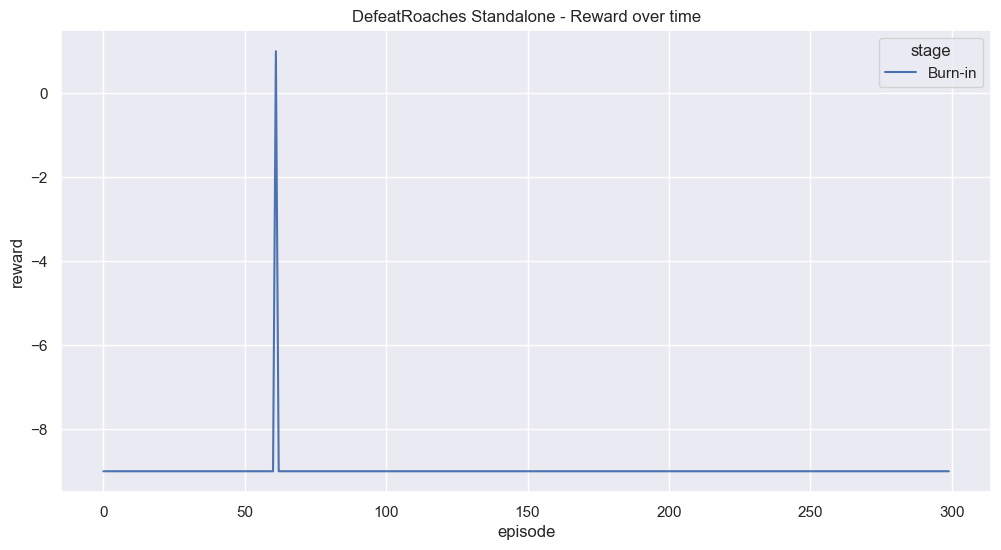

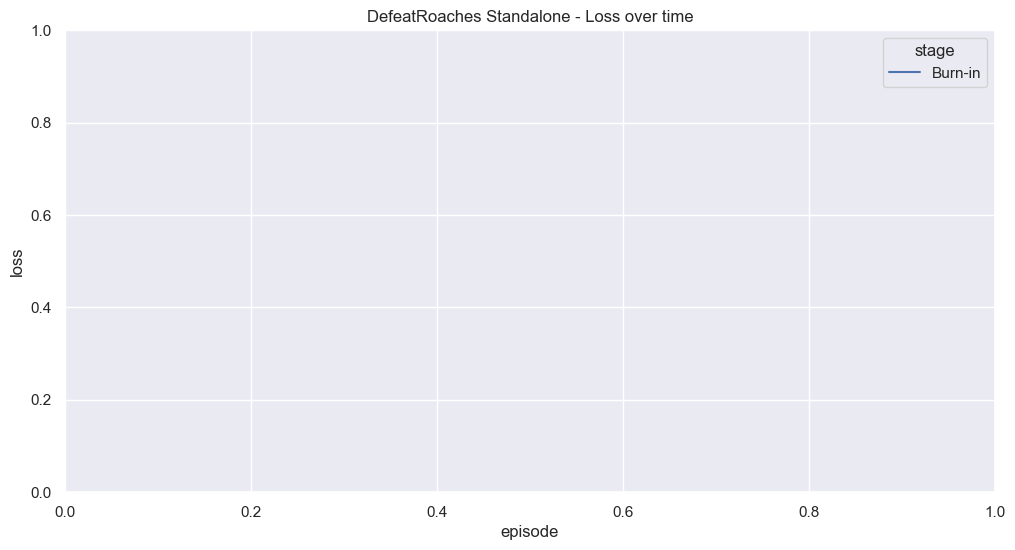

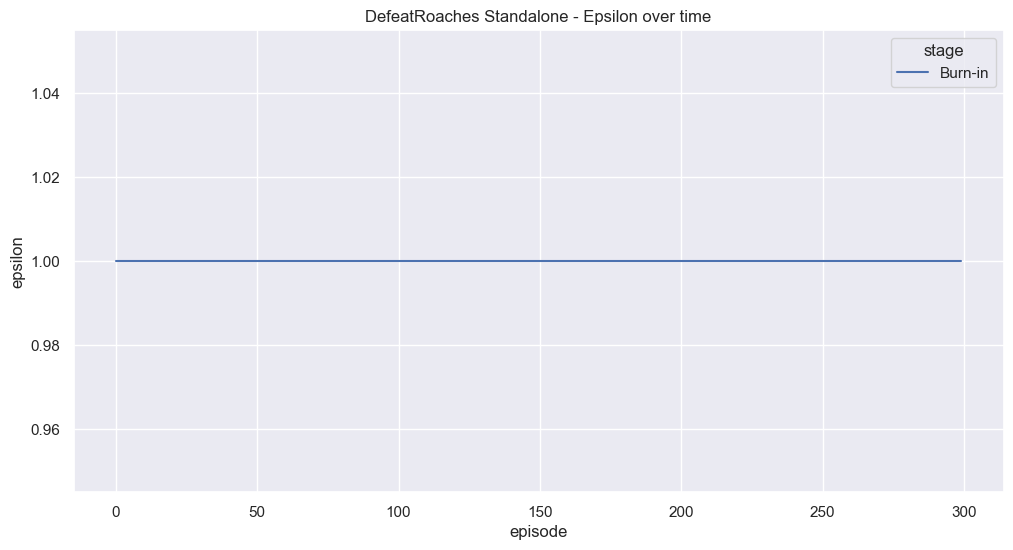

map_name  reward  steps  epsilon losses  emissions  score  \
0  DefeatRoaches    -9.0     30      1.0     []   0.000082      0   
1  DefeatRoaches    -9.0     19      1.0     []   0.000149      0   
2  DefeatRoaches    -9.0     26      1.0     []   0.000220      0   
3  DefeatRoaches    -9.0     20      1.0     []   0.000288      0   
4  DefeatRoaches    -9.0     21      1.0     []   0.000355      0   

   is_training  is_exploit  is_random_mode  episode    stage  loss  
0        False       False           False        0  Burn-in   NaN  
1        False       False           False        1  Burn-in   NaN  
2        False       False           False        2  Burn-in   NaN  
3        False       False           False        3  Burn-in   NaN  
4        False       False           False        4  Burn-in   NaN

In [51]:
episode_stats, agent_stats, aggregated_stats = load_stats(defeat_roaches_model_id, model_name="DefeatRoaches Standalone")
episode_stats.head()

# Defeat Zerglings

Total episodes: 300
Total burnin episodes: 300
Total random mode episodes: 0
Total episodes: 0
Total exploit episodes: 0
Unique maps in episode stats:  ['DefeatZerglingsAndBanelings']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


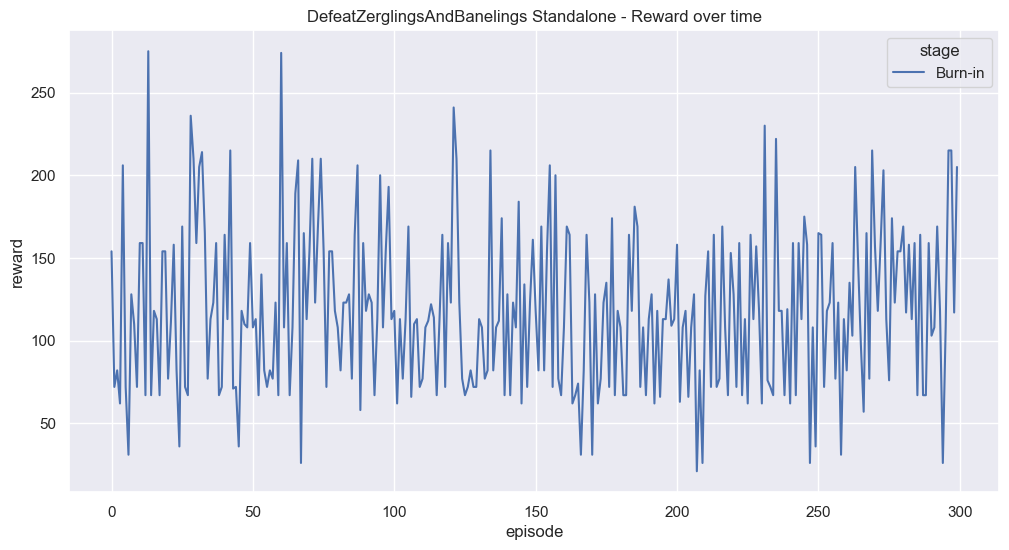

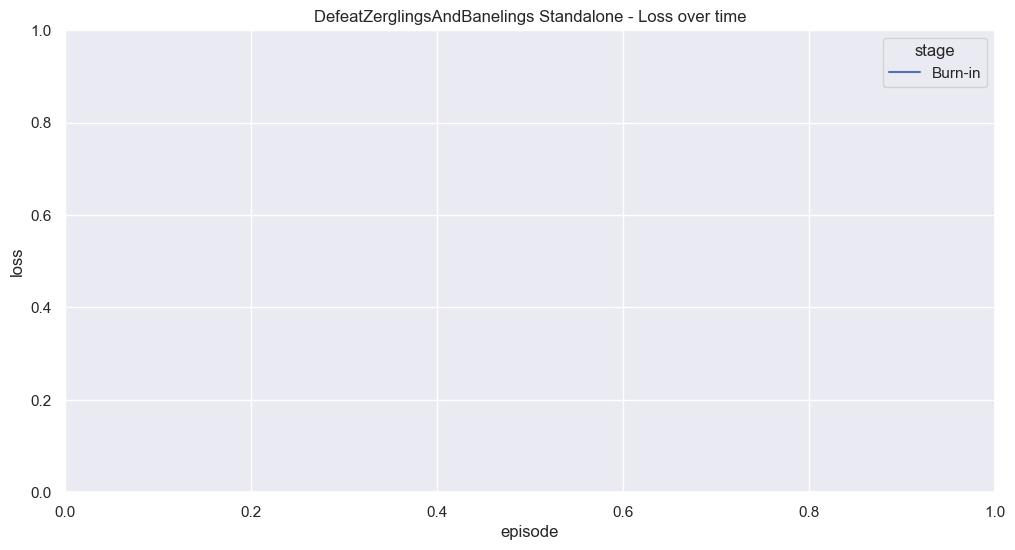

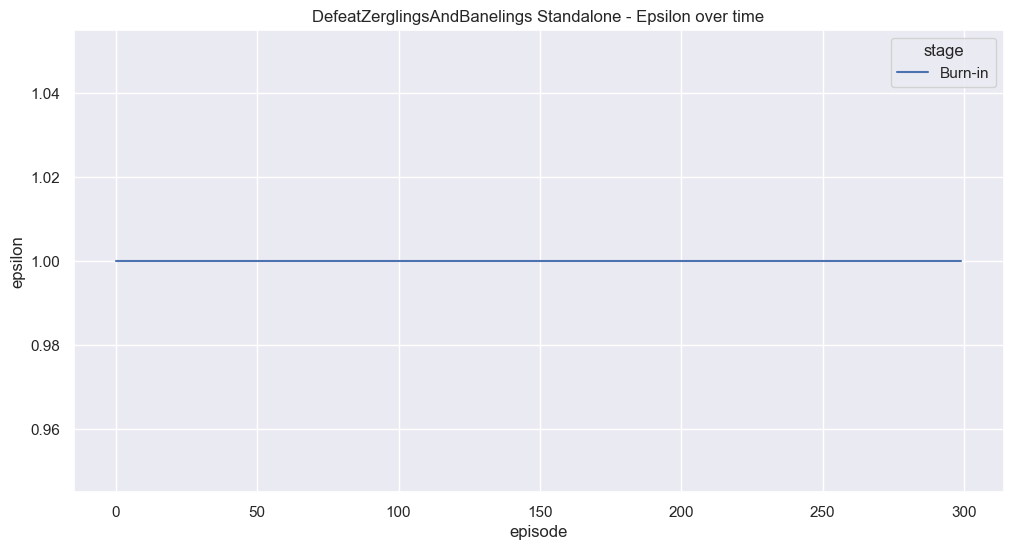

map_name  reward  steps  epsilon losses  emissions  \
0  DefeatZerglingsAndBanelings   154.0     18      1.0     []   0.000080   
1  DefeatZerglingsAndBanelings    72.0     27      1.0     []   0.000153   
2  DefeatZerglingsAndBanelings    82.0     19      1.0     []   0.000222   
3  DefeatZerglingsAndBanelings    62.0     16      1.0     []   0.000293   
4  DefeatZerglingsAndBanelings   206.0     41      1.0     []   0.000735   

   score  is_training  is_exploit  is_random_mode  episode    stage  loss  
0      0        False       False           False        0  Burn-in   NaN  
1      0        False       False           False        1  Burn-in   NaN  
2      0        False       False           False        2  Burn-in   NaN  
3      0        False       False           False        3  Burn-in   NaN  
4      0        False       False           False        4  Burn-in   NaN

In [54]:
episode_stats, agent_stats, aggregated_stats = load_stats(defeat_zerglings_model_id, model_name="DefeatZerglingsAndBanelings Standalone")
episode_stats.head()

# Simple64

Total episodes: 300
Total burnin episodes: 24
Total random mode episodes: 0
Total episodes: 276
Total exploit episodes: 0
Unique maps in episode stats:  ['Simple64']


D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\anaconda3\envs\tfm\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


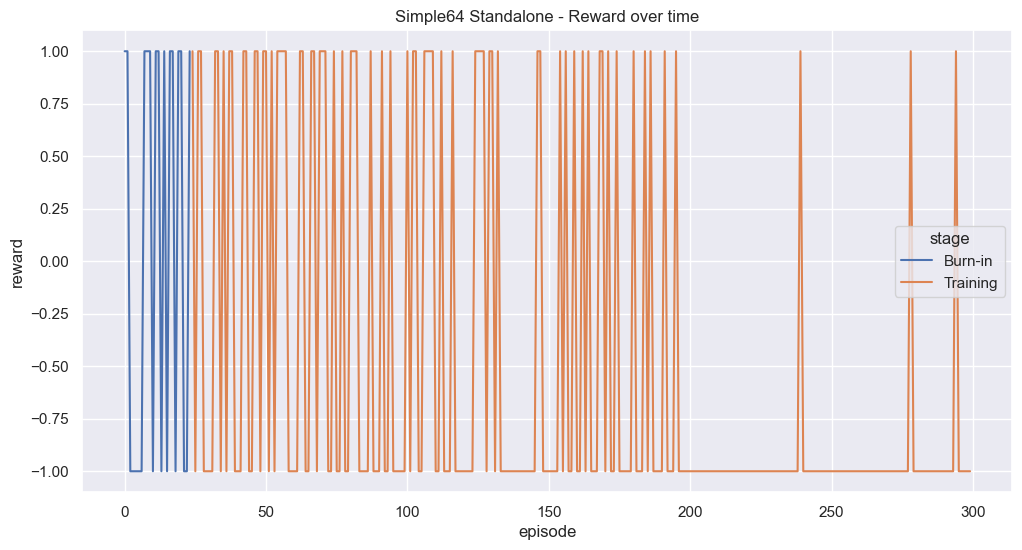

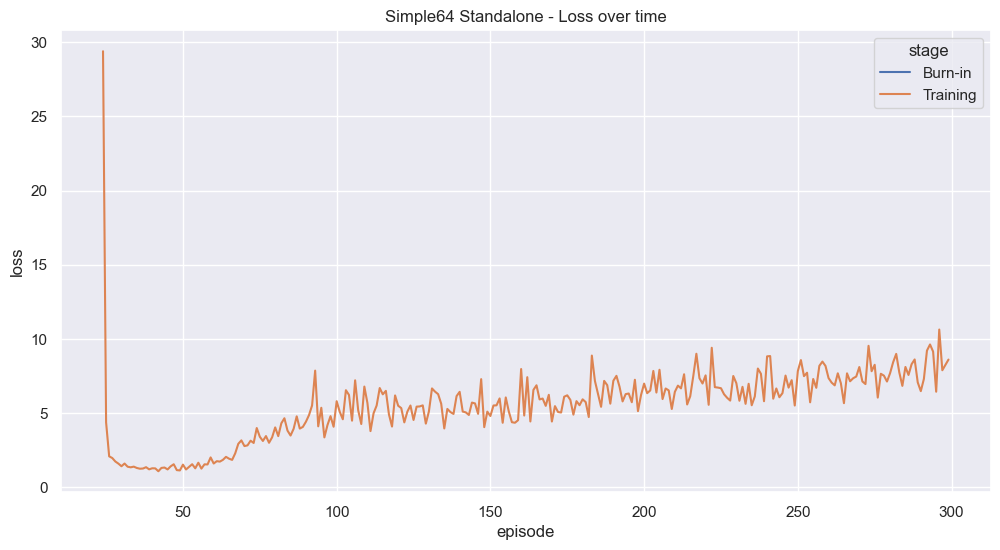

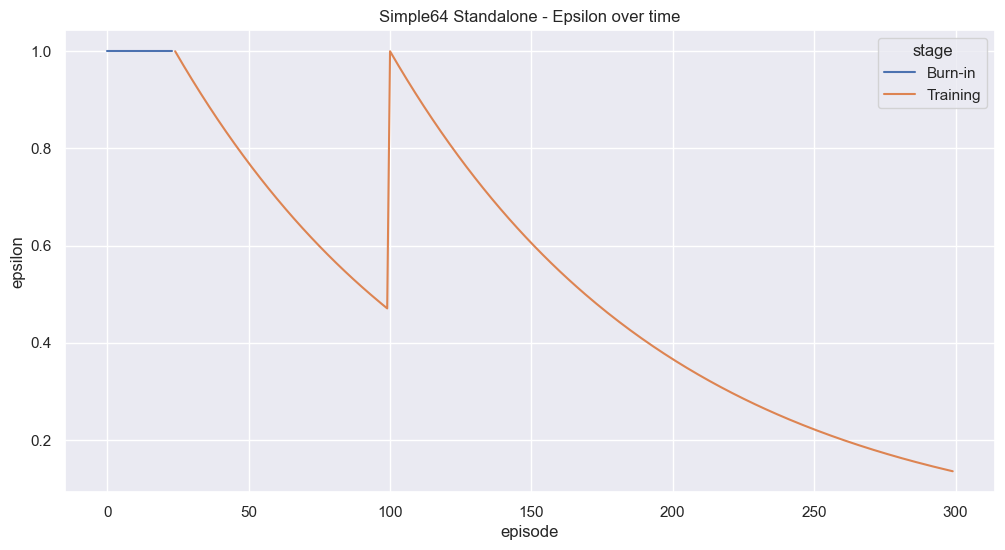

map_name  reward  steps  epsilon losses  emissions  score  is_training  \
0  Simple64     1.0    241      1.0     []   0.000915      0        False   
1  Simple64     1.0    277      1.0     []   0.002814      0        False   
2  Simple64    -1.0    451      1.0     []   0.007934      0        False   
3  Simple64    -1.0    667      1.0     []   0.015654      0        False   
4  Simple64    -1.0    456      1.0     []   0.014736      0        False   

   is_exploit  is_random_mode  episode    stage  loss  
0       False           False        0  Burn-in   NaN  
1       False           False        1  Burn-in   NaN  
2       False           False        2  Burn-in   NaN  
3       False           False        3  Burn-in   NaN  
4       False           False        4  Burn-in   NaN

In [55]:
episode_stats, agent_stats, aggregated_stats = load_stats(simple64_model_id, model_name="Simple64 Standalone")
episode_stats.head()